In [12]:
"""
TUH Abnormal Dataset
"""

import glob, os
import numpy as np
from tqdm import tqdm
import torch

from IPython.display import clear_output

#from src.model import EEGModel
from src.read_data import build_data
from src.make_features import train_test, standardize_data, data_loader
#from src.train import train_model, print_acc

from torch_geometric.data import Data, TemporalData, HeteroData
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse

def norm_adj(train_graphs, test_graphs):
    for i in range(train_graphs.shape[0]):
        for j in range(train_graphs.shape[1]):
                min_ = (train_graphs[i, j, :, :]).min()
                max_ = (train_graphs[i, j, :, :]).max()
                train_graphs[i, j, :,  :] = (train_graphs[i, j, :,  :] - min_)/(max_ - min_)
                
    for i in range(test_graphs.shape[0]):
        for j in range(test_graphs.shape[1]):
            min_ = (test_graphs[i, j, :, :]).min()
            max_ = (test_graphs[i, j, :, :]).max()
            test_graphs[i, j, :, :] = (test_graphs[i, j, :,  :] - min_)/(max_ - min_)
            
    return train_graphs, test_graphs


def norm_adj(train_graphs, test_graphs):
    for i in range(train_graphs.shape[2]):
        for j in range(train_graphs.shape[3]):
            if train_graphs[:, :, i, j].sum != 0:
                min_ = (train_graphs[:, :, i, j]).min()
                max_ = (train_graphs[:, :, i, j]).max()
                train_graphs[:, :, i,  j] = (train_graphs[:, :, i,  j] - min_)/(max_ - min_)
                test_graphs[:, :, i, j] = (test_graphs[:, :, i,  j] - min_)/(max_ - min_)
            if i == j:
                train_graphs[:, :, i, j] = 1
            
    return train_graphs, test_graphs

def norm_adj(train_graphs, test_graphs):
    for i in range(train_graphs.shape[0]):
        for j in range(train_graphs.shape[1]):
                min_ = (train_graphs[i, j, :, :]).min()
                max_ = (train_graphs[i, j, :, :]).max()
                train_graphs[i, j, :,  :] = (train_graphs[i, j, :,  :] - min_)/(max_ - min_)
                
    for i in range(test_graphs.shape[0]):
        for j in range(test_graphs.shape[1]):
            min_ = (test_graphs[i, j, :, :]).min()
            max_ = (test_graphs[i, j, :, :]).max()
            test_graphs[i, j, :, :] = (test_graphs[i, j, :,  :] - min_)/(max_ - min_)
            
    return train_graphs, test_graphs
    
SAVED_DATA = True
SAVED_FEATURES = False
CONN_TYPES = ["coh"]#, "ciplv", "coh", "pc"]
NUM_EPOCHS = 30 #This is based on Cross validation experiments
BATCH_SIZE = 128
DEVICE = torch.device("cpu") #torch.device("mps")

SAVED_RESULTS = {}

# Files names on disk
train_files = []
for file in glob.glob("../../../../tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/*/*/*.edf"):
    train_files.append(file)
print("Train Data:", len(train_files))
test_files = []
for file in glob.glob("../../../../tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/eval/*/*/*.edf"):
    test_files.append(file)
print("Test Data:", len(test_files))

for conn in CONN_TYPES:    
    print(conn)
    if SAVED_FEATURES:
        train_X = np.load("../saved_npy_tuh/features/train_X.npy") #samples, #epochs, #channels, #time points)
        train_y = np.load("../saved_npy_tuh/features/train_y.npy")
        train_graphs = np.load("../saved_npy_tuh/features/train_graphs_"+conn+".npy")
        test_y = np.load("../saved_npy_tuh/features/test_y.npy")
        test_X = np.load("../saved_npy_tuh/features/test_X.npy")
        test_graphs = np.load("../saved_npy_tuh/features/test_graphs_"+conn+".npy")
        train_X = np.moveaxis(train_X, 1, -1)
        test_X = np.moveaxis(test_X, 1, -1)
        train_graphs, test_graphs = norm_adj(train_graphs, test_graphs)
        #train_X, test_X = standardize_data(train_X, test_X)
        
    else:
        if SAVED_DATA:
            # Saved arrays on disk
            train_X_files = ["../saved_npy_tuh/features/train_X"+str(i)+".npy" for i in range(0, len(train_files), 100)]
            train_y_files = ["../saved_npy_tuh/features/train_y"+str(i)+".npy" for i in range(0, len(train_files), 100)]
            train_X = np.vstack([np.load(file).astype(np.float16) for i, file in enumerate(train_X_files)])
            train_y = np.vstack([np.load(file).astype(np.float16) for i, file in enumerate(train_y_files)])
            test_X = np.load("../saved_npy_tuh/features/test_X.npy").astype(np.float16)
            test_y = np.load("../saved_npy_tuh/features/test_y.npy").astype(np.float16)
            
        else:
            num_windows = 200
            window_size = 200
            for i in range(0, len(train_files), 100):
                train_X, train_y = build_data(train_files[i:i+100], use_windows=False, window_size=window_size, num_windows=num_windows)
                np.save("../saved_npy_tuh/features/train_X"+str(i)+".npy", train_X.astype(np.float16))
                np.save("../saved_npy_tuh/features/train_y"+str(i)+".npy", train_y.astype(np.float16))
            test_X, test_y = build_data(test_files, use_windows=False, window_size=window_size, num_windows=num_windows)
            np.save("../saved_npy_tuh/features/test_X.npy", test_X.astype(np.float16))
            np.save("../saved_npy_tuh/features/test_y.npy", test_y.astype(np.float16))
            clear_output()
    
            train_X_files = ["../saved_npy_tuh/features/train_X"+str(i)+".npy" for i in range(0, len(train_files), 100)]
            train_y_files = ["../saved_npy_tuh/features/train_y"+str(i)+".npy" for i in range(0, len(train_files), 100)]
            train_X = np.vstack([np.load(file) for file in train_X_files])
            train_y = np.vstack([np.load(file) for file in train_y_files])
            test_X = np.load("../saved_npy_tuh/features/test_X.npy")
            test_y = np.load("../saved_npy_tuh/features/test_y.npy")

        np.save("../saved_npy_tuh/features/train_X.npy", train_X)
        np.save("../saved_npy_tuh/features/train_y.npy", train_y)
        np.save("../saved_npy_tuh/features/test_y.npy", test_y)
        np.save("../saved_npy_tuh/features/test_X.npy", test_X)
        print("make features")
        _ , train_graphs, _, _ , test_graphs, _ = train_test(train_X=train_X, 
                                                             test_X=test_X, 
                                                             train_y=train_y, 
                                                             test_y=test_y, 
                                                             method=conn)
        
        np.save("../saved_npy_tuh/features/train_X.npy", train_X)
        np.save("../saved_npy_tuh/features/train_y.npy", train_y)
        np.save("../saved_npy_tuh/features/train_graphs_"+conn+".npy", train_graphs)
        np.save("../saved_npy_tuh/features/test_y.npy", test_y)
        np.save("../saved_npy_tuh/features/test_X.npy", test_X)
        np.save("../saved_npy_tuh/features/test_graphs_"+conn+".npy", test_graphs)

Train Data: 2717
Test Data: 276
coh
make features
read_data
(2717, 200, 19, 200) (276, 200, 19, 200)
Gen features
calculating connectivity


100%|██████████| 2717/2717 [6:24:24<00:00,  8.49s/it]    


Gen features
calculating connectivity


100%|██████████| 276/276 [37:10<00:00,  8.08s/it]


(2717, 200, 19, 200) (276, 200, 19, 200)


In [9]:
x = np.load("../saved_npy_ep/features/train_y.npy")
x4z

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float16)

In [5]:
import numpy as np

x = np.load("../saved_npy_tuh/features/test_graphs_coh.npy")
x.shape

(276, 200, 19, 19)

In [16]:
!ls ../../../../tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar

aaaaaaav_s004_t000.edf aaaaalkm_s001_t000.edf aaaaantr_s001_t000.edf
aaaaaabn_s005_t000.edf aaaaalkt_s001_t000.edf aaaaantx_s001_t000.edf
aaaaaaff_s002_t000.edf aaaaalla_s001_t001.edf aaaaanui_s001_t002.edf
aaaaaalk_s002_t000.edf aaaaalli_s001_t000.edf aaaaanuq_s001_t000.edf
aaaaaama_s002_t000.edf aaaaallr_s001_t000.edf aaaaanus_s001_t000.edf
aaaaaanr_s003_t000.edf aaaaallu_s001_t001.edf aaaaanut_s001_t000.edf
aaaaaanx_s003_t001.edf aaaaallv_s001_t001.edf aaaaanut_s002_t000.edf
aaaaaapr_s002_t001.edf aaaaally_s001_t000.edf aaaaanuu_s001_t000.edf
aaaaaaqb_s004_t000.edf aaaaalmb_s001_t001.edf aaaaanuu_s002_t009.edf
aaaaaaqu_s002_t001.edf aaaaalmf_s002_t000.edf aaaaanuy_s001_t000.edf
aaaaaary_s002_t000.edf aaaaalmg_s001_t000.edf aaaaanvc_s001_t000.edf
aaaaaary_s003_t000.edf aaaaalmi_s001_t001.edf aaaaanvd_s001_t000.edf
aaaaaavs_s002_t001.edf aaaaalmj_s001_t000.edf aaaaanvd_s002_t000.edf
aaaaaawu_s004_t000.edf aaaaalmj_s002_t002.edf aaaaanvd_s006_t002.edf
aaaaaawu_s005_t000.edf aaaaalmj_s0

In [22]:
import mne

data = mne.io.read_raw_edf(file, preload=True)
data.info

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/eval/normal/01_tcp_ar/aaaaanlp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372249  =      0.000 ...  1488.996 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 31 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2012-08-24 12:07:36 UTC
 nchan: 31
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: aaaaanlp, sex: 2, last_name: aaaaanlp>
>

In [11]:
train_graphs.shape

(2717, 200, 19, 19)

In [9]:
train_graphs[0, 4, :2, :2]

array([[0.        , 0.59664006],
       [0.59664006, 0.        ]])

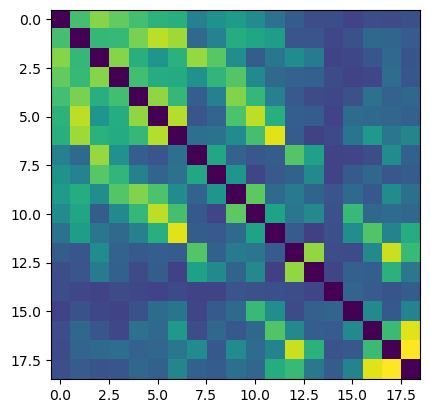

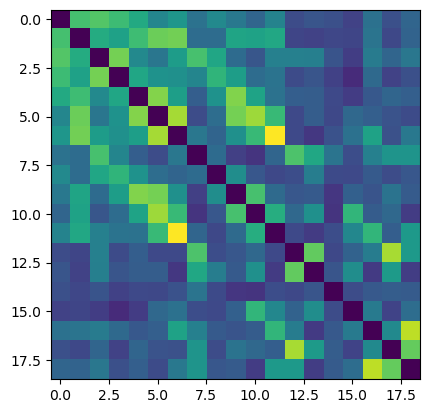

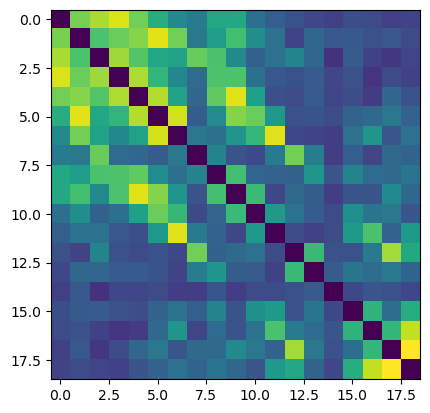

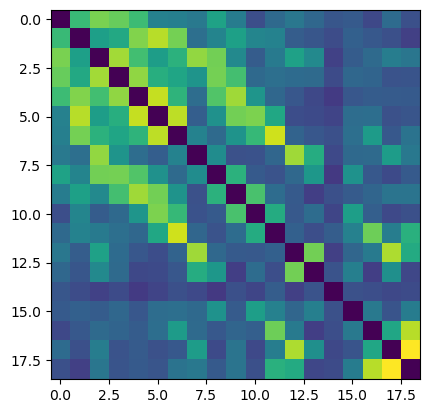

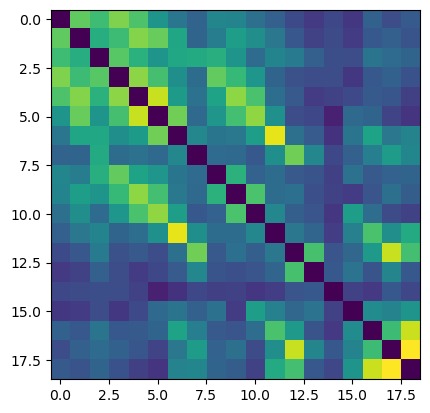

In [6]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(train_graphs[0, i])
    plt.show()

In [16]:
train_y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float16)

In [9]:
file = train_files[0]

import mne

all_data_sex = []
for file in tqdm(train_files):
    data_raw = mne.io.read_raw_edf(file, preload=True)
    sex = data_raw.info["subject_info"]["sex"]
    all_data_sex.append(sex)

  0%|          | 0/2717 [00:00<?, ?it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakte_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaeqd_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...


  0%|          | 2/2717 [00:00<02:43, 16.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabhz_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ...  1232.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaactf_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


  0%|          | 4/2717 [00:00<03:13, 14.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamwm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahwd_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297999  =      0.000 ...  1191.996 secs...


  0%|          | 6/2717 [00:00<03:03, 14.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakmn_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaewf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364249  =      0.000 ...  1456.996 secs...


  0%|          | 8/2717 [00:00<03:23, 13.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajud_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 532499  =      0.000 ...  2129.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapaa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390749  =      0.000 ...  1562.996 secs...


  0%|          | 10/2717 [00:00<04:24, 10.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajvt_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306499  =      0.000 ...  1225.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaallw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369749  =      0.000 ...  1478.996 secs...


  0%|          | 12/2717 [00:01<04:45,  9.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajlr_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306499  =      0.000 ...  1225.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanji_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 757499  =      0.000 ...  3029.996 secs...


  1%|          | 14/2717 [00:01<05:46,  7.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajru_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapkk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 475999  =      0.000 ...  1903.996 secs...


  1%|          | 16/2717 [00:01<05:08,  8.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalqq_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakkm_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328249  =      0.000 ...  1312.996 secs...


  1%|          | 18/2717 [00:01<04:20, 10.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuw_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305663  =      0.000 ...  1193.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakkm_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 612499  =      0.000 ...  2449.996 secs...


  1%|          | 20/2717 [00:01<04:47,  9.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaplz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331999  =      0.000 ...  1327.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakyc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322999  =      0.000 ...  1291.996 secs...


  1%|          | 22/2717 [00:02<04:11, 10.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqy_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2140927  =      0.000 ...  8362.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalwk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353499  =      0.000 ...  1413.996 secs...


  1%|          | 24/2717 [00:03<09:04,  4.95it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahoh_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamga_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 287999  =      0.000 ...  1151.996 secs...


  1%|          | 26/2717 [00:03<07:04,  6.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanjo_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 727999  =      0.000 ...  2911.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapax_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 740863  =      0.000 ...  2893.996 secs...


  1%|          | 28/2717 [00:03<07:46,  5.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiyr_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalzi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347999  =      0.000 ...  1391.996 secs...


  1%|          | 30/2717 [00:03<06:14,  7.18it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaict_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 810999  =      0.000 ...  3243.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadsy_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344063  =      0.000 ...  1343.996 secs...


  1%|          | 32/2717 [00:04<06:44,  6.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamsh_s002_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 498499  =      0.000 ...  1993.996 secs...


  1%|          | 33/2717 [00:04<06:51,  6.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiym_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308749  =      0.000 ...  1234.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaouk_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...


  1%|▏         | 35/2717 [00:04<05:22,  8.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalls_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaammr_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


  1%|▏         | 37/2717 [00:04<04:22, 10.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadus_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298749  =      0.000 ...  1194.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizb_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335999  =      0.000 ...  1343.996 secs...


  1%|▏         | 39/2717 [00:04<03:43, 11.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaknz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizb_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 290749  =      0.000 ...  1162.996 secs...


  2%|▏         | 41/2717 [00:04<03:26, 12.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 365999  =      0.000 ...  1463.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaots_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323583  =      0.000 ...  1263.996 secs...


  2%|▏         | 43/2717 [00:04<03:28, 12.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanys_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 459499  =      0.000 ...  1837.996 secs...


  2%|▏         | 45/2717 [00:04<03:36, 12.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaopm_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336249  =      0.000 ...  1344.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamdu_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 283749  =      0.000 ...  1134.996 secs...


  2%|▏         | 47/2717 [00:05<03:17, 13.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaifo_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295499  =      0.000 ...  1181.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaofu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanuo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ..

  2%|▏         | 50/2717 [00:05<03:05, 14.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaibl_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312831  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamge_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 291749  =      0.000 ...  1166.996 secs...


  2%|▏         | 52/2717 [00:05<02:54, 15.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajpf_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297999  =      0.000 ...  1191.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaeuh_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...


  2%|▏         | 54/2717 [00:05<02:52, 15.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanjc_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 258249  =      0.000 ...  1032.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapvx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349999  =      0.000 ...  1399.996 secs...


  2%|▏         | 56/2717 [00:05<02:59, 14.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaprf_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331263  =      0.000 ...  1293.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqo_s031_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295749  =      0.000 ...  1182.996 secs...


  2%|▏         | 58/2717 [00:05<03:15, 13.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapcr_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 442499  =      0.000 ...  1769.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajww_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


  2%|▏         | 60/2717 [00:05<03:04, 14.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaifp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajmq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319499  =      0.000 ...  1277.996 secs...


  2%|▏         | 62/2717 [00:06<02:59, 14.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakyz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamdu_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 367749  =      0.000 ...  1470.996 secs...


  2%|▏         | 64/2717 [00:06<03:46, 11.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoxa_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 624895  =      0.000 ...  2440.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaeeq_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


  2%|▏         | 66/2717 [00:06<04:35,  9.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaldl_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314749  =      0.000 ...  1258.996 secs...


  3%|▎         | 68/2717 [00:06<04:05, 10.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamsh_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoui_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344499  =      0.000 ...  1377.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiyr_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335249  =      0.000 ..

  3%|▎         | 71/2717 [00:06<03:19, 13.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaooo_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 871679  =      0.000 ...  3404.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaonl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 392249  =      0.000 ...  1568.996 secs...


  3%|▎         | 73/2717 [00:07<04:28,  9.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanuk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355499  =      0.000 ...  1421.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamoa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315499  =      0.000 ...  1261.996 secs...


  3%|▎         | 75/2717 [00:07<03:56, 11.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahvc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 407295  =      0.000 ...  1590.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanqj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348999  =      0.000 ...  1395.996 secs...


  3%|▎         | 77/2717 [00:07<03:32, 12.43it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaojm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317749  =      0.000 ...  1270.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamug_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322999  =      0.000 ...  1291.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalal_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321749  =      0.000 ..

  3%|▎         | 80/2717 [00:07<03:01, 14.50it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaosd_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  1240.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiey_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ...  1230.996 secs...


  3%|▎         | 82/2717 [00:07<02:53, 15.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiey_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaowz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347999  =      0.000 ...  1391.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapck_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337749  =      0.000 ..

  3%|▎         | 85/2717 [00:07<02:36, 16.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakoy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamad_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357999  =      0.000 ...  1431.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajvt_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ..

  3%|▎         | 88/2717 [00:08<02:28, 17.72it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaannj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 647679  =      0.000 ...  1264.998 secs...


  3%|▎         | 90/2717 [00:08<02:51, 15.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamff_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286999  =      0.000 ...  1147.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajob_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...


  3%|▎         | 92/2717 [00:08<02:42, 16.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadng_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahce_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...


  3%|▎         | 94/2717 [00:08<02:34, 16.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanoa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalwg_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 292249  =      0.000 ...  1168.996 secs...


  4%|▎         | 96/2717 [00:08<02:33, 17.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiat_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311499  =      0.000 ...  1245.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...


  4%|▎         | 98/2717 [00:08<02:34, 16.90it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaly_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298749  =      0.000 ...  1194.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakpu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 562249  =      0.000 ...  2248.996 secs...


  4%|▎         | 100/2717 [00:08<03:04, 14.22it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaorp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339249  =      0.000 ...  1356.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanwp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352999  =      0.000 ...  1411.996 secs...


  4%|▍         | 102/2717 [00:08<02:51, 15.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaptg_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316415  =      0.000 ...  1235.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanjz_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329499  =      0.000 ...  1317.996 secs...


  4%|▍         | 104/2717 [00:09<02:47, 15.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapxf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 739583  =      0.000 ...  2888.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapap_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375249  =      0.000 ...  1500.996 secs...


  4%|▍         | 106/2717 [00:09<03:49, 11.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafpj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319499  =      0.000 ...  1277.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiud_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...


  4%|▍         | 108/2717 [00:09<03:29, 12.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafpj_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319749  =      0.000 ...  1278.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaofd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350999  =      0.000 ...  1403.996 secs...


  4%|▍         | 110/2717 [00:09<03:11, 13.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqt_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajnr_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


  4%|▍         | 112/2717 [00:09<02:59, 14.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaobe_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345749  =      0.000 ...  1382.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaelp_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


  4%|▍         | 114/2717 [00:09<02:49, 15.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakgl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299249  =      0.000 ...  1196.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaehn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 365499  =      0.000 ...  1461.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaobe_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371249  =      0.000 ..

  4%|▍         | 117/2717 [00:09<02:31, 17.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaelp_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanvn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 424499  =      0.000 ...  1697.996 secs...


  4%|▍         | 119/2717 [00:10<02:28, 17.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanog_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 280499  =      0.000 ...  1121.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamgt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351999  =      0.000 ...  1407.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanog_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348249  =      0.000 ..

  4%|▍         | 122/2717 [00:10<02:22, 18.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcu_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298499  =      0.000 ...  1193.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanox_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamur_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ..

  5%|▍         | 125/2717 [00:10<02:17, 18.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanpx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316749  =      0.000 ...  1266.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaampk_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...


  5%|▍         | 127/2717 [00:10<02:15, 19.13it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqu_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 285951  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaieb_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331519  =      0.000 ...  1294.996 secs...


  5%|▍         | 129/2717 [00:10<02:39, 16.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapqi_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 276499  =      0.000 ...  1105.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajyp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamns_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311749  =      0.000 ..

  5%|▍         | 132/2717 [00:10<02:21, 18.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346999  =      0.000 ...  1387.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324999  =      0.000 ...  1299.996 secs...


  5%|▍         | 134/2717 [00:10<02:23, 18.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336249  =      0.000 ...  1344.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakix_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...


  5%|▌         | 136/2717 [00:11<02:25, 17.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakef_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapnx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340249  =      0.000 ...  1360.996 secs...


  5%|▌         | 138/2717 [00:11<02:34, 16.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalhp_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295423  =      0.000 ...  1153.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamjo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315999  =      0.000 ...  1263.996 secs...


  5%|▌         | 140/2717 [00:11<02:34, 16.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaokb_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314999  =      0.000 ...  1259.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqp_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305749  =      0.000 ...  1222.996 secs...


  5%|▌         | 142/2717 [00:11<02:35, 16.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakpq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabue_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...


  5%|▌         | 144/2717 [00:11<02:33, 16.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamto_s014_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 341749  =      0.000 ...  1366.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajkv_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...


  5%|▌         | 146/2717 [00:11<02:42, 15.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabdn_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 414249  =      0.000 ...  1656.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalpr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306249  =      0.000 ...  1224.996 secs...


  5%|▌         | 148/2717 [00:11<02:55, 14.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoiu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358249  =      0.000 ...  1432.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaisv_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320999  =      0.000 ...  1283.996 secs...


  6%|▌         | 150/2717 [00:11<02:58, 14.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadir_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337499  =      0.000 ...  1349.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapgb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 405749  =      0.000 ...  1622.996 secs...


  6%|▌         | 152/2717 [00:12<02:51, 14.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoze_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346749  =      0.000 ...  1386.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqq_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289535  =      0.000 ...  1130.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaotb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ..

  6%|▌         | 155/2717 [00:12<03:06, 13.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajdn_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...


  6%|▌         | 157/2717 [00:12<03:14, 13.13it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamyn_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 292499  =      0.000 ...  1169.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanuc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357249  =      0.000 ...  1428.996 secs...


  6%|▌         | 159/2717 [00:12<03:10, 13.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamwa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakjn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiud_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ..

  6%|▌         | 162/2717 [00:12<02:53, 14.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabom_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanxa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


  6%|▌         | 164/2717 [00:12<02:45, 15.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalcu_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318249  =      0.000 ...  1272.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaksx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306249  =      0.000 ...  1224.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalkw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349249  =      0.000 ..

  6%|▌         | 167/2717 [00:13<02:31, 16.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebk_s016_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327499  =      0.000 ...  1309.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanuz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaandq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ..

  6%|▋         | 170/2717 [00:13<02:20, 18.10it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebk_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340249  =      0.000 ...  1360.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaafs_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310749  =      0.000 ...  1242.996 secs...


  6%|▋         | 172/2717 [00:13<02:29, 17.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagmy_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390249  =      0.000 ...  1560.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


  6%|▋         | 174/2717 [00:13<02:44, 15.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahzn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329249  =      0.000 ...  1316.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalxt_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...


  6%|▋         | 176/2717 [00:13<02:47, 15.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapcr_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 775935  =      0.000 ...  3030.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanhm_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 763249  =      0.000 ...  3052.996 secs...


  7%|▋         | 178/2717 [00:14<04:46,  8.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakea_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295749  =      0.000 ...  1182.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamni_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...


  7%|▋         | 180/2717 [00:14<04:03, 10.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanbd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 266499  =      0.000 ...  1065.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapxx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299749  =      0.000 ...  1198.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakbm_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ..

  7%|▋         | 183/2717 [00:14<03:14, 13.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaahf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamjh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...


  7%|▋         | 185/2717 [00:14<02:56, 14.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanai_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqo_s027_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


  7%|▋         | 187/2717 [00:14<02:51, 14.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaocx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334249  =      0.000 ...  1336.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqo_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309999  =      0.000 ...  1239.996 secs...


  7%|▋         | 189/2717 [00:14<02:40, 15.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajrj_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 611583  =      0.000 ...  2388.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapuc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327499  =      0.000 ...  1309.996 secs...


  7%|▋         | 191/2717 [00:15<03:50, 10.94it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaplh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340749  =      0.000 ...  1362.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoxy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354749  =      0.000 ...  1418.996 secs...


  7%|▋         | 193/2717 [00:15<03:23, 12.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapge_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368999  =      0.000 ...  1475.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapnc_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315903  =      0.000 ...  1233.996 secs...


  7%|▋         | 195/2717 [00:15<03:11, 13.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamdc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377249  =      0.000 ...  1508.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagnh_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 428499  =      0.000 ...  1713.996 secs...


  7%|▋         | 197/2717 [00:15<03:28, 12.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuh_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajtl_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...


  7%|▋         | 199/2717 [00:15<03:08, 13.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiwr_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakza_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325499  =      0.000 ...  1301.996 secs...


  7%|▋         | 201/2717 [00:15<02:54, 14.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuw_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315647  =      0.000 ...  1232.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


  7%|▋         | 203/2717 [00:15<02:43, 15.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiwr_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamxj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebx_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308223  =      0.000 ..

  8%|▊         | 206/2717 [00:15<02:27, 17.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapsq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebx_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


  8%|▊         | 208/2717 [00:16<02:31, 16.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanxf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369499  =      0.000 ...  1477.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaarq_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362499  =      0.000 ...  1449.996 secs...


  8%|▊         | 210/2717 [00:16<02:40, 15.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaobx_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 403749  =      0.000 ...  1614.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahun_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346749  =      0.000 ...  1386.996 secs...


  8%|▊         | 212/2717 [00:16<02:34, 16.18it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaojw_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakiy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 483999  =      0.000 ...  1935.996 secs...


  8%|▊         | 214/2717 [00:16<03:05, 13.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaorw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapek_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 389249  =      0.000 ...  1556.996 secs...


  8%|▊         | 216/2717 [00:16<03:04, 13.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakvy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoek_s029_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 395007  =      0.000 ...  1542.996 secs...


  8%|▊         | 218/2717 [00:16<02:59, 13.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakvy_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346749  =      0.000 ...  1386.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadnb_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334999  =      0.000 ...  1339.996 secs...


  8%|▊         | 220/2717 [00:16<02:44, 15.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamkv_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360249  =      0.000 ...  1440.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalto_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307967  =      0.000 ...  1202.996 secs...


  8%|▊         | 222/2717 [00:17<02:36, 15.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakrx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352749  =      0.000 ...  1410.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaankz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304999  =      0.000 ...  1219.996 secs...


  8%|▊         | 224/2717 [00:17<02:28, 16.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanqc_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuy_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajns_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 430249  =      0.000 ..

  8%|▊         | 227/2717 [00:17<02:58, 13.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamow_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaphp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331749  =      0.000 ...  1326.996 secs...


  8%|▊         | 229/2717 [00:17<03:09, 13.13it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoak_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316749  =      0.000 ...  1266.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajxi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351499  =      0.000 ...  1405.996 secs...


  9%|▊         | 231/2717 [00:17<02:55, 14.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaong_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369999  =      0.000 ...  1479.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabii_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


  9%|▊         | 233/2717 [00:17<02:43, 15.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakks_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 799249  =      0.000 ...  3196.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaambr_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326399  =      0.000 ...  1274.996 secs...


  9%|▊         | 235/2717 [00:18<04:03, 10.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaliz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaauj_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakbt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ..

  9%|▉         | 238/2717 [00:18<03:17, 12.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapbz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  1240.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapaw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 341499  =      0.000 ...  1365.996 secs...


  9%|▉         | 240/2717 [00:18<03:07, 13.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaktn_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313249  =      0.000 ...  1252.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajat_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319249  =      0.000 ...  1276.996 secs...


  9%|▉         | 242/2717 [00:18<03:04, 13.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajat_s016_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340223  =      0.000 ...  1328.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamhb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 476499  =      0.000 ...  1905.996 secs...


  9%|▉         | 244/2717 [00:18<03:43, 11.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajwa_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299249  =      0.000 ...  1196.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajxm_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...


  9%|▉         | 246/2717 [00:18<03:14, 12.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaancc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


  9%|▉         | 248/2717 [00:19<03:02, 13.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamlc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajtl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 753749  =      0.000 ...  3014.996 secs...


  9%|▉         | 250/2717 [00:19<03:30, 11.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalno_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajfw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306249  =      0.000 ...  1224.996 secs...


  9%|▉         | 252/2717 [00:19<03:04, 13.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamos_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapnc_s019_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 876031  =      0.000 ...  3421.996 secs...


  9%|▉         | 254/2717 [00:19<03:46, 10.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajez_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364249  =      0.000 ...  1456.996 secs...


  9%|▉         | 256/2717 [00:19<03:24, 12.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalhy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293999  =      0.000 ...  1175.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaovm_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 449279  =      0.000 ..

 10%|▉         | 259/2717 [00:19<02:49, 14.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaeer_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334999  =      0.000 ...  1339.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamnt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 10%|▉         | 261/2717 [00:20<02:38, 15.48it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanso_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapas_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 380249  =      0.000 ...  1520.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321535  =      0.000 ..

 10%|▉         | 264/2717 [00:20<02:53, 14.18it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafge_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358499  =      0.000 ...  1433.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanrd_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342749  =      0.000 ...  1370.996 secs...


 10%|▉         | 266/2717 [00:20<02:48, 14.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapgt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 440249  =      0.000 ...  1760.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaegi_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356999  =      0.000 ...  1427.996 secs...


 10%|▉         | 268/2717 [00:20<02:45, 14.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanyi_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295499  =      0.000 ...  1181.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahyq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 762999  =      0.000 ...  3051.996 secs...


 10%|▉         | 270/2717 [00:20<03:20, 12.18it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakro_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahcw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


 10%|█         | 272/2717 [00:20<02:59, 13.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuy_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadom_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ..

 10%|█         | 275/2717 [00:21<02:36, 15.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaacz_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanps_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318499  =      0.000 ...  1273.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaksw_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ..

 10%|█         | 278/2717 [00:21<02:20, 17.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaappi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 373249  =      0.000 ...  1492.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaksw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314499  =      0.000 ...  1257.996 secs...


 10%|█         | 280/2717 [00:21<02:25, 16.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapib_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295249  =      0.000 ...  1180.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoou_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


 10%|█         | 282/2717 [00:21<02:25, 16.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanie_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320749  =      0.000 ...  1282.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalhh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357249  =      0.000 ...  1428.996 secs...


 10%|█         | 284/2717 [00:21<02:41, 15.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacsa_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321499  =      0.000 ...  1285.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanog_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...


 11%|█         | 286/2717 [00:21<02:40, 15.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamlk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298999  =      0.000 ...  1195.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaojj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323249  =      0.000 ...  1292.996 secs...


 11%|█         | 288/2717 [00:21<02:29, 16.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaorj_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 247999  =      0.000 ...   991.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakgc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372479  =      0.000 ...  1454.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabju_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324999  =      0.000 ..

 11%|█         | 291/2717 [00:21<02:12, 18.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakux_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317749  =      0.000 ...  1270.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaofv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371249  =      0.000 ...  1484.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajsu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298749  =      0.000 ..

 11%|█         | 294/2717 [00:22<02:07, 18.94it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajhk_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahjt_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ..

 11%|█         | 297/2717 [00:22<01:58, 20.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaovz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331749  =      0.000 ...  1326.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebv_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384511  =      0.000 ...  1501.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajuc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 292999  =      0.000 ..

 11%|█         | 300/2717 [00:22<02:29, 16.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakbz_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaool_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 446463  =      0.000 ...  1743.996 secs...


 11%|█         | 302/2717 [00:22<02:49, 14.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaool_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390749  =      0.000 ...  1562.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamto_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317749  =      0.000 ...  1270.996 secs...


 11%|█         | 304/2717 [00:22<02:48, 14.30it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoyk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 409999  =      0.000 ...  1639.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapfw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325499  =      0.000 ...  1301.996 secs...


 11%|█▏        | 306/2717 [00:22<02:40, 15.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaouj_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323249  =      0.000 ...  1292.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalzw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...


 11%|█▏        | 308/2717 [00:23<02:29, 16.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalqe_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalzw_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 11%|█▏        | 310/2717 [00:23<02:24, 16.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfs_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaouw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321749  =      0.000 ...  1286.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaannp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 275499  =      0.000 ..

 12%|█▏        | 313/2717 [00:23<02:08, 18.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaojw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...  1251.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaat_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388249  =      0.000 ...  1552.996 secs...


 12%|█▏        | 315/2717 [00:23<02:19, 17.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagxr_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303871  =      0.000 ...  1186.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363999  =      0.000 ...  1455.996 secs...


 12%|█▏        | 317/2717 [00:23<02:28, 16.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakzv_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360749  =      0.000 ...  1442.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakkb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337749  =      0.000 ...  1350.996 secs...


 12%|█▏        | 319/2717 [00:23<02:20, 17.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamgf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaicl_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqf_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323249  =      0.000 ..

 12%|█▏        | 322/2717 [00:23<02:14, 17.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanjh_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343249  =      0.000 ...  1372.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaavr_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357749  =      0.000 ...  1430.996 secs...


 12%|█▏        | 324/2717 [00:23<02:18, 17.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaantp_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343499  =      0.000 ...  1373.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamtc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382749  =      0.000 ...  1530.996 secs...


 12%|█▏        | 326/2717 [00:24<02:44, 14.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakmp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299749  =      0.000 ...  1198.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaallt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336499  =      0.000 ...  1345.996 secs...


 12%|█▏        | 328/2717 [00:24<02:43, 14.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaewg_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoir_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...


 12%|█▏        | 330/2717 [00:24<02:33, 15.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakep_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakan_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313249  =      0.000 ...  1252.996 secs...


 12%|█▏        | 332/2717 [00:24<02:33, 15.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafxx_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 812499  =      0.000 ...  3249.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamfx_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319999  =      0.000 ...  1279.996 secs...


 12%|█▏        | 334/2717 [00:24<03:30, 11.31it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaambf_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 550749  =      0.000 ...  2202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaloy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295499  =      0.000 ...  1181.996 secs...


 12%|█▏        | 336/2717 [00:25<04:15,  9.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakvq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295749  =      0.000 ...  1182.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaott_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312499  =      0.000 ...  1249.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakdw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ..

 12%|█▏        | 339/2717 [00:25<03:27, 11.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanqi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331999  =      0.000 ...  1327.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalao_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 13%|█▎        | 341/2717 [00:25<03:16, 12.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanuh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322249  =      0.000 ...  1288.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaljb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321749  =      0.000 ...  1286.996 secs...


 13%|█▎        | 343/2717 [00:25<03:05, 12.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanlm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanca_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...


 13%|█▎        | 345/2717 [00:25<02:47, 14.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakkh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363749  =      0.000 ...  1454.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiev_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 13%|█▎        | 347/2717 [00:25<02:43, 14.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoek_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 871423  =      0.000 ...  3403.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoek_s015_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 472575  =      0.000 ...  1845.996 secs...


 13%|█▎        | 349/2717 [00:26<03:47, 10.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 685249  =      0.000 ...  2740.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...


 13%|█▎        | 351/2717 [00:26<04:42,  8.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanud_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanqz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 341249  =      0.000 ...  1364.996 secs...


 13%|█▎        | 353/2717 [00:26<04:06,  9.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuw_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323071  =      0.000 ...  1261.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamhb_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 573951  =      0.000 ...  1120.998 secs...


 13%|█▎        | 355/2717 [00:26<04:15,  9.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiwr_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapzm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 394499  =      0.000 ...  1577.996 secs...


 13%|█▎        | 357/2717 [00:26<03:42, 10.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalgw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaptf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309999  =      0.000 ...  1239.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacej_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ..

 13%|█▎        | 360/2717 [00:27<02:57, 13.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357499  =      0.000 ...  1429.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaammf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...


 13%|█▎        | 362/2717 [00:27<02:54, 13.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaantn_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 262999  =      0.000 ...  1051.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakjo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 13%|█▎        | 364/2717 [00:27<02:48, 13.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalto_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoew_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327999  =      0.000 ...  1311.996 secs...


 13%|█▎        | 366/2717 [00:27<02:42, 14.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaju_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299249  =      0.000 ...  1196.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakro_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339249  =      0.000 ...  1356.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanqc_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326749  =      0.000 ..

 14%|█▎        | 369/2717 [00:27<02:36, 15.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamki_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaankz_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...


 14%|█▎        | 371/2717 [00:27<02:39, 14.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfi_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamki_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaows_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319749  =      0.000 ..

 14%|█▍        | 374/2717 [00:27<02:30, 15.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapyd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312249  =      0.000 ...  1248.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagpk_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ...  1232.996 secs...


 14%|█▍        | 376/2717 [00:28<02:28, 15.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapho_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335499  =      0.000 ...  1341.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajfq_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335999  =      0.000 ..

 14%|█▍        | 379/2717 [00:28<02:14, 17.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalnt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342749  =      0.000 ...  1370.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaool_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323839  =      0.000 ...  1264.996 secs...


 14%|█▍        | 381/2717 [00:28<02:15, 17.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacod_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357999  =      0.000 ...  1431.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalax_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317749  =      0.000 ...  1270.996 secs...


 14%|█▍        | 383/2717 [00:28<02:14, 17.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoru_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377999  =      0.000 ...  1511.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaoy_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305749  =      0.000 ...  1222.996 secs...


 14%|█▍        | 385/2717 [00:28<02:17, 17.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafif_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324249  =      0.000 ...  1296.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaovt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 435999  =      0.000 ...  1743.996 secs...


 14%|█▍        | 387/2717 [00:28<02:40, 14.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamnr_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 281855  =      0.000 ...  1100.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebx_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 14%|█▍        | 389/2717 [00:28<02:38, 14.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajra_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313249  =      0.000 ...  1252.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaejm_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


 14%|█▍        | 391/2717 [00:29<02:27, 15.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapmt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325749  =      0.000 ...  1302.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...


 14%|█▍        | 393/2717 [00:29<02:30, 15.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalzd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaces_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298499  =      0.000 ...  1193.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamic_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ..

 15%|█▍        | 396/2717 [00:29<02:17, 16.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiua_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapny_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


 15%|█▍        | 398/2717 [00:29<02:11, 17.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahun_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakan_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377999  =      0.000 ...  1511.996 secs...


 15%|█▍        | 400/2717 [00:29<02:12, 17.50it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaambn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ...  1233.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaorh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328499  =      0.000 ...  1313.996 secs...


 15%|█▍        | 402/2717 [00:29<02:14, 17.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafiy_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoru_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaehr_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327499  =      0.000 ..

 15%|█▍        | 405/2717 [00:29<02:07, 18.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamkt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366499  =      0.000 ...  1465.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaonx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364249  =      0.000 ...  1456.996 secs...


 15%|█▍        | 407/2717 [00:29<02:25, 15.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafqu_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 418999  =      0.000 ...  1675.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajfq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 15%|█▌        | 409/2717 [00:30<02:43, 14.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaksq_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 411749  =      0.000 ...  1646.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapls_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoso_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 415249  =      0.000 ..

 15%|█▌        | 412/2717 [00:30<02:27, 15.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabhz_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamde_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317499  =      0.000 ...  1269.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamhd_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338999  =      0.000 ..

 15%|█▌        | 415/2717 [00:30<02:15, 17.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaju_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310999  =      0.000 ...  1243.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahnb_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294499  =      0.000 ...  1177.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamnk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 401749  =      0.000 ..

 15%|█▌        | 418/2717 [00:30<02:24, 15.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapaq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318749  =      0.000 ...  1274.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalqm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361249  =      0.000 ...  1444.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanng_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330499  =      0.000 ..

 15%|█▌        | 421/2717 [00:30<02:21, 16.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalgj_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalym_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298999  =      0.000 ...  1195.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanmw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333749  =      0.000 ..

 16%|█▌        | 424/2717 [00:31<02:11, 17.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanmw_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 386249  =      0.000 ...  1544.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajzx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...


 16%|█▌        | 426/2717 [00:31<02:08, 17.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaptf_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 426495  =      0.000 ...  1665.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoek_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 644095  =      0.000 ...  2515.996 secs...


 16%|█▌        | 428/2717 [00:31<02:33, 14.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadmi_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamyv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309999  =      0.000 ...  1239.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaeog_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ..

 16%|█▌        | 431/2717 [00:31<02:19, 16.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaacz_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376249  =      0.000 ...  1504.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanpl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 16%|█▌        | 433/2717 [00:31<02:26, 15.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapjp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalof_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 16%|█▌        | 435/2717 [00:31<02:20, 16.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacrz_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 692223  =      0.000 ...  1351.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaammw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...


 16%|█▌        | 437/2717 [00:31<03:09, 12.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakis_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298999  =      0.000 ...  1195.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajzt_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...


 16%|█▌        | 439/2717 [00:32<02:50, 13.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapma_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360749  =      0.000 ...  1442.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaplf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...


 16%|█▌        | 441/2717 [00:32<02:35, 14.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapsj_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 510749  =      0.000 ...  2042.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafgz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 16%|█▋        | 443/2717 [00:32<02:58, 12.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadji_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298499  =      0.000 ...  1193.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaacq_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335749  =      0.000 ...  1342.996 secs...


 16%|█▋        | 445/2717 [00:32<02:39, 14.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamka_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanzf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352249  =      0.000 ...  1408.996 secs...


 16%|█▋        | 447/2717 [00:32<02:33, 14.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaopb_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340749  =      0.000 ...  1362.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaappr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 448749  =      0.000 ...  1794.996 secs...


 17%|█▋        | 449/2717 [00:32<02:47, 13.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaru_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298749  =      0.000 ...  1194.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaolc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  1240.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajdj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317749  =      0.000 ..

 17%|█▋        | 452/2717 [00:32<02:23, 15.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalvi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364249  =      0.000 ...  1456.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaovx_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326999  =      0.000 ...  1307.996 secs...


 17%|█▋        | 454/2717 [00:33<02:17, 16.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapnh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoyt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 563999  =      0.000 ...  2255.996 secs...


 17%|█▋        | 456/2717 [00:33<02:46, 13.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaikw_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakbz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...


 17%|█▋        | 458/2717 [00:33<02:44, 13.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaantt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaozy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375749  =      0.000 ...  1502.996 secs...


 17%|█▋        | 460/2717 [00:33<02:34, 14.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaokr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalat_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...


 17%|█▋        | 462/2717 [00:33<02:23, 15.68it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapdb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355583  =      0.000 ...  1388.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafaf_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293999  =      0.000 ...  1175.996 secs...


 17%|█▋        | 464/2717 [00:33<02:20, 16.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamlt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310999  =      0.000 ...  1243.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanou_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 17%|█▋        | 466/2717 [00:33<02:15, 16.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaocy_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 277749  =      0.000 ...  1110.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadsy_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320749  =      0.000 ...  1282.996 secs...


 17%|█▋        | 468/2717 [00:33<02:15, 16.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajwv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313499  =      0.000 ...  1253.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanhd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334749  =      0.000 ...  1338.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoiz_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 451583  =      0.000 ..

 17%|█▋        | 471/2717 [00:34<02:05, 17.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalxb_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalxb_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


 17%|█▋        | 473/2717 [00:34<02:08, 17.43it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanrb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339999  =      0.000 ...  1359.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoxn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321499  =      0.000 ...  1285.996 secs...


 17%|█▋        | 475/2717 [00:34<02:12, 16.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahuc_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 393499  =      0.000 ...  1573.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalmh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320999  =      0.000 ...  1283.996 secs...


 18%|█▊        | 477/2717 [00:34<02:25, 15.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanqo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356999  =      0.000 ...  1427.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapks_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361999  =      0.000 ...  1447.996 secs...


 18%|█▊        | 479/2717 [00:34<02:16, 16.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaomd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamke_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308479  =      0.000 ...  1204.996 secs...


 18%|█▊        | 481/2717 [00:34<02:11, 16.94it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajra_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 281249  =      0.000 ...  1124.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaibr_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336999  =      0.000 ...  1347.996 secs...


 18%|█▊        | 483/2717 [00:34<02:08, 17.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalsr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaandx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333249  =      0.000 ...  1332.996 secs...


 18%|█▊        | 485/2717 [00:34<02:07, 17.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapvd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333249  =      0.000 ...  1332.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebk_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaool_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 457749  =      0.000 ..

 18%|█▊        | 488/2717 [00:35<02:26, 15.22it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebk_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310749  =      0.000 ...  1242.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaocr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamwu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346623  =      0.000 ..

 18%|█▊        | 491/2717 [00:35<02:22, 15.57it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaovx_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 391249  =      0.000 ...  1564.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapwc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324351  =      0.000 ...  1266.996 secs...


 18%|█▊        | 493/2717 [00:35<02:18, 16.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajoz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ...  1230.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogs_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333749  =      0.000 ...  1334.996 secs...


 18%|█▊        | 495/2717 [00:35<02:18, 16.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanjn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 403249  =      0.000 ...  1612.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaru_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


 18%|█▊        | 497/2717 [00:35<02:43, 13.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcn_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325887  =      0.000 ...  1272.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakdh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350249  =      0.000 ...  1400.996 secs...


 18%|█▊        | 499/2717 [00:35<02:35, 14.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajpc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamca_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306249  =      0.000 ...  1224.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapgt_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2714879  =      0.000 .

 18%|█▊        | 502/2717 [00:36<05:57,  6.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajrt_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328999  =      0.000 ...  1315.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaannv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375749  =      0.000 ...  1502.996 secs...


 19%|█▊        | 504/2717 [00:37<05:17,  6.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanie_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296191  =      0.000 ...  1156.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaker_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330499  =      0.000 ...  1321.996 secs...


 19%|█▊        | 506/2717 [00:37<04:34,  8.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaavr_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356499  =      0.000 ...  1425.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoyp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337999  =      0.000 ...  1351.996 secs...


 19%|█▊        | 508/2717 [00:37<03:50,  9.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajdn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanig_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...  1251.996 secs...


 19%|█▉        | 510/2717 [00:37<03:18, 11.11it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafxx_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310749  =      0.000 ...  1242.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamfx_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 19%|█▉        | 512/2717 [00:37<02:53, 12.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapbp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337749  =      0.000 ...  1350.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalvm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 19%|█▉        | 514/2717 [00:37<02:38, 13.94it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanag_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaallk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319249  =      0.000 ...  1276.996 secs...


 19%|█▉        | 516/2717 [00:37<02:42, 13.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamfg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332749  =      0.000 ...  1330.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoek_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317499  =      0.000 ...  1269.996 secs...


 19%|█▉        | 518/2717 [00:37<02:29, 14.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakkg_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 260499  =      0.000 ...  1041.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoec_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 406249  =      0.000 ...  1624.996 secs...


 19%|█▉        | 520/2717 [00:38<02:20, 15.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogj_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308999  =      0.000 ...  1235.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqy_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319749  =      0.000 ...  1278.996 secs...


 19%|█▉        | 522/2717 [00:38<02:18, 15.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapgh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 424999  =      0.000 ...  1699.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoxt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 412499  =      0.000 ...  1649.996 secs...


 19%|█▉        | 524/2717 [00:38<02:12, 16.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaklv_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298999  =      0.000 ...  1195.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaler_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317999  =      0.000 ...  1271.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakhw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ..

 19%|█▉        | 527/2717 [00:38<02:05, 17.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamjx_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289749  =      0.000 ...  1158.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamjx_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 273749  =      0.000 ...  1094.996 secs...


 19%|█▉        | 529/2717 [00:38<02:08, 17.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahwd_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335249  =      0.000 ...  1340.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaowt_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366249  =      0.000 ...  1464.996 secs...


 20%|█▉        | 531/2717 [00:38<02:10, 16.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaampk_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanad_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354499  =      0.000 ...  1417.996 secs...


 20%|█▉        | 533/2717 [00:38<02:30, 14.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakms_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaantn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...


 20%|█▉        | 535/2717 [00:39<02:33, 14.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiat_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312575  =      0.000 ...  1220.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamnd_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakml_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368249  =      0.000 ..

 20%|█▉        | 538/2717 [00:39<02:22, 15.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamnd_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaicm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293249  =      0.000 ...  1172.996 secs...


 20%|█▉        | 540/2717 [00:39<02:14, 16.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqg_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286749  =      0.000 ...  1146.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajfq_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298249  =      0.000 ...  1192.996 secs...


 20%|█▉        | 542/2717 [00:39<02:13, 16.25it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaieb_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamto_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331999  =      0.000 ...  1327.996 secs...


 20%|██        | 544/2717 [00:39<02:13, 16.30it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanhg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308749  =      0.000 ...  1234.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaifo_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298749  =      0.000 ...  1194.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiia_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306499  =      0.000 ..

 20%|██        | 547/2717 [00:39<02:19, 15.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajpy_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 895499  =      0.000 ...  3581.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapcr_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 285439  =      0.000 ...  1114.996 secs...


 20%|██        | 549/2717 [00:40<03:02, 11.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajtx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalei_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaprf_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 270335  =      0.000 ..

 20%|██        | 552/2717 [00:40<02:30, 14.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalei_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 395499  =      0.000 ...  1581.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacsy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323999  =      0.000 ...  1295.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiyr_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ..

 20%|██        | 555/2717 [00:40<02:16, 15.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaozz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322499  =      0.000 ...  1289.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoqw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388749  =      0.000 ...  1554.996 secs...


 21%|██        | 557/2717 [00:40<02:11, 16.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaict_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagvm_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...


 21%|██        | 559/2717 [00:40<02:05, 17.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalqf_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308749  =      0.000 ...  1234.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaggf_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320499  =      0.000 ...  1281.996 secs...


 21%|██        | 561/2717 [00:40<02:10, 16.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadir_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320749  =      0.000 ...  1282.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoek_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355249  =      0.000 ...  1420.996 secs...


 21%|██        | 563/2717 [00:40<02:14, 16.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacnq_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327749  =      0.000 ...  1310.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaggf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...


 21%|██        | 565/2717 [00:40<02:18, 15.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanbm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagvr_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310999  =      0.000 ...  1243.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoom_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388999  =      0.000 ..

 21%|██        | 568/2717 [00:41<02:10, 16.48it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapfv_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapiz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 401499  =      0.000 ...  1605.996 secs...


 21%|██        | 570/2717 [00:41<02:04, 17.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanpk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaouk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348249  =      0.000 ...  1392.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ..

 21%|██        | 573/2717 [00:41<01:57, 18.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamad_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336499  =      0.000 ...  1345.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoek_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327999  =      0.000 ...  1311.996 secs...


 21%|██        | 575/2717 [00:41<02:03, 17.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanxi_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309999  =      0.000 ...  1239.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapfk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...


 21%|██        | 577/2717 [00:41<02:04, 17.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamsh_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315647  =      0.000 ...  1232.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaocy_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326999  =      0.000 ...  1307.996 secs...


 21%|██▏       | 579/2717 [00:41<02:00, 17.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanbp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalhp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313749  =      0.000 ...  1254.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaptm_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ..

 21%|██▏       | 582/2717 [00:41<01:53, 18.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaxa_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...


 21%|██▏       | 584/2717 [00:41<01:55, 18.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajpy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaasn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...


 22%|██▏       | 586/2717 [00:42<01:56, 18.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakvi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajww_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 22%|██▏       | 588/2717 [00:42<01:56, 18.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogd_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316249  =      0.000 ...  1264.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakob_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298999  =      0.000 ...  1195.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaifo_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310749  =      0.000 ..

 22%|██▏       | 591/2717 [00:42<01:50, 19.25it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamdj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324749  =      0.000 ...  1298.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamzm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaankj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ..

 22%|██▏       | 594/2717 [00:42<01:53, 18.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaonj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 414499  =      0.000 ...  1657.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaandf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344999  =      0.000 ...  1379.996 secs...


 22%|██▏       | 596/2717 [00:42<02:01, 17.43it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaifp_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382499  =      0.000 ...  1529.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaljg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362499  =      0.000 ...  1449.996 secs...


 22%|██▏       | 598/2717 [00:42<01:58, 17.90it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagpk_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375749  =      0.000 ...  1502.996 secs...


 22%|██▏       | 600/2717 [00:42<01:59, 17.66it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaouo_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307249  =      0.000 ...  1228.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaannh_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353749  =      0.000 ...  1414.996 secs...


 22%|██▏       | 602/2717 [00:42<02:05, 16.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabrc_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 411749  =      0.000 ...  1646.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaammt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 292499  =      0.000 ...  1169.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacrz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ..

 22%|██▏       | 605/2717 [00:43<01:54, 18.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagit_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakvp_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ...  1230.996 secs...


 22%|██▏       | 607/2717 [00:43<02:07, 16.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaonl_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335999  =      0.000 ...  1343.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalwk_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319499  =      0.000 ..

 22%|██▏       | 610/2717 [00:43<01:58, 17.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaopt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345749  =      0.000 ...  1382.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakrq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 23%|██▎       | 612/2717 [00:43<01:59, 17.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajat_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapkt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 256999  =      0.000 ..

 23%|██▎       | 615/2717 [00:43<01:51, 18.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqa_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349999  =      0.000 ...  1399.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamri_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319499  =      0.000 ...  1277.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaint_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307249  =      0.000 ..

 23%|██▎       | 618/2717 [00:43<01:54, 18.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanre_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315499  =      0.000 ...  1261.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamgc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363999  =      0.000 ...  1455.996 secs...


 23%|██▎       | 620/2717 [00:43<01:56, 17.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaptx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317249  =      0.000 ...  1268.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanjx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...


 23%|██▎       | 622/2717 [00:44<01:53, 18.44it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapao_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369999  =      0.000 ...  1479.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaftk_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 23%|██▎       | 624/2717 [00:44<01:59, 17.57it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanny_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafpj_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 633087  =      0.000 ...  2472.996 secs...


 23%|██▎       | 626/2717 [00:44<02:36, 13.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafpj_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalpt_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332249  =      0.000 ...  1328.996 secs...


 23%|██▎       | 628/2717 [00:44<02:30, 13.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapno_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318999  =      0.000 ...  1275.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakcv_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328249  =      0.000 ...  1312.996 secs...


 23%|██▎       | 630/2717 [00:44<02:18, 15.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoas_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 365999  =      0.000 ...  1463.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoas_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314749  =      0.000 ...  1258.996 secs...


 23%|██▎       | 632/2717 [00:44<02:15, 15.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalxi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalib_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  1240.996 secs...


 23%|██▎       | 634/2717 [00:44<02:15, 15.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebk_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 430499  =      0.000 ...  1721.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanvh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311551  =      0.000 ...  1216.996 secs...


 23%|██▎       | 636/2717 [00:45<02:29, 13.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiat_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaancb_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 266499  =      0.000 ...  1065.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapoy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308735  =      0.000 ..

 24%|██▎       | 639/2717 [00:45<02:09, 16.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakxq_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...  1251.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalcl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298999  =      0.000 ...  1195.996 secs...


 24%|██▎       | 641/2717 [00:45<02:03, 16.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabdn_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331999  =      0.000 ...  1327.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaftm_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362749  =      0.000 ...  1450.996 secs...


 24%|██▎       | 643/2717 [00:45<02:10, 15.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadli_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaactf_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336249  =      0.000 ...  1344.996 secs...


 24%|██▎       | 645/2717 [00:45<02:17, 15.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamxv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadli_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 406749  =      0.000 ...  1626.996 secs...


 24%|██▍       | 647/2717 [00:45<02:23, 14.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakuy_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 664999  =      0.000 ...  2659.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaactf_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...


 24%|██▍       | 649/2717 [00:45<02:48, 12.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalop_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapsm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...


 24%|██▍       | 651/2717 [00:46<02:35, 13.25it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaouz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295999  =      0.000 ...  1183.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaprf_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439807  =      0.000 ...  1717.996 secs...


 24%|██▍       | 653/2717 [00:46<02:33, 13.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajdn_s014_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299249  =      0.000 ...  1196.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaorz_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334999  =      0.000 ...  1339.996 secs...


 24%|██▍       | 655/2717 [00:46<02:20, 14.66it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305749  =      0.000 ...  1222.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapca_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 370499  =      0.000 ...  1481.996 secs...


 24%|██▍       | 657/2717 [00:46<02:18, 14.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoiw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 341499  =      0.000 ...  1365.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabbx_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...


 24%|██▍       | 659/2717 [00:46<02:29, 13.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamhz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanog_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357999  =      0.000 ...  1431.996 secs...


 24%|██▍       | 661/2717 [00:46<02:21, 14.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaopa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357749  =      0.000 ...  1430.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaandj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376249  =      0.000 ...  1504.996 secs...


 24%|██▍       | 663/2717 [00:46<02:12, 15.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakoq_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 393499  =      0.000 ...  1573.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakoq_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346749  =      0.000 ...  1386.996 secs...


 24%|██▍       | 665/2717 [00:47<02:35, 13.22it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajbn_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313249  =      0.000 ...  1252.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaosl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312499  =      0.000 ...  1249.996 secs...


 25%|██▍       | 667/2717 [00:47<02:21, 14.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapvk_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3364095  =      0.000 ... 13140.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalmz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...


 25%|██▍       | 669/2717 [00:48<08:56,  3.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizz_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325249  =      0.000 ...  1300.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanpz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...


 25%|██▍       | 671/2717 [00:48<07:12,  4.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajgj_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 420749  =      0.000 ...  1682.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapjf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 370499  =      0.000 ...  1481.996 secs...


 25%|██▍       | 673/2717 [00:48<05:41,  5.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapwl_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 495103  =      0.000 ...  1933.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafxq_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...


 25%|██▍       | 675/2717 [00:49<05:59,  5.68it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakie_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabue_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313999  =      0.000 ...  1255.996 secs...


 25%|██▍       | 677/2717 [00:49<04:44,  7.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacrt_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372249  =      0.000 ...  1488.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcn_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298249  =      0.000 ...  1192.996 secs...


 25%|██▍       | 679/2717 [00:49<04:17,  7.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahlk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakym_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ...  1230.996 secs...


 25%|██▌       | 681/2717 [00:49<03:57,  8.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagmy_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaamc_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309499  =      0.000 ...  1237.996 secs...


 25%|██▌       | 683/2717 [00:50<03:49,  8.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqo_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384255  =      0.000 ...  1500.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalns_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 254999  =      0.000 ...  1019.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ..

 25%|██▌       | 686/2717 [00:50<03:05, 10.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapjb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 407499  =      0.000 ...  1629.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamxr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322999  =      0.000 ...  1291.996 secs...


 25%|██▌       | 688/2717 [00:50<02:47, 12.10it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoro_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366749  =      0.000 ...  1466.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamad_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315249  =      0.000 ...  1260.996 secs...


 25%|██▌       | 690/2717 [00:50<02:33, 13.22it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajwp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaangs_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...


 25%|██▌       | 692/2717 [00:50<02:24, 13.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314749  =      0.000 ...  1258.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapuo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314499  =      0.000 ...  1257.996 secs...


 26%|██▌       | 694/2717 [00:50<02:21, 14.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakro_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 370749  =      0.000 ...  1482.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapgt_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ...  1230.996 secs...


 26%|██▌       | 696/2717 [00:50<02:38, 12.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakrm_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafhi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332999  =      0.000 ...  1331.996 secs...


 26%|██▌       | 698/2717 [00:51<02:29, 13.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahql_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ...  1232.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaainj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353535  =      0.000 ..

 26%|██▌       | 701/2717 [00:51<02:19, 14.48it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabiw_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 389249  =      0.000 ...  1556.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanie_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 26%|██▌       | 703/2717 [00:51<02:13, 15.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalhh_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378249  =      0.000 ...  1512.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajzk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306249  =      0.000 ...  1224.996 secs...


 26%|██▌       | 705/2717 [00:51<02:07, 15.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamso_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabiw_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 26%|██▌       | 707/2717 [00:51<02:04, 16.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoek_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315499  =      0.000 ...  1261.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajzc_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 727999  =      0.000 ...  2911.996 secs...


 26%|██▌       | 709/2717 [00:51<02:40, 12.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaappt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334499  =      0.000 ...  1337.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaohd_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  1323.996 secs...


 26%|██▌       | 711/2717 [00:51<02:38, 12.68it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakem_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajzc_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328749  =      0.000 ...  1314.996 secs...


 26%|██▌       | 713/2717 [00:52<02:22, 14.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaloy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacjw_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalmz_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ..

 26%|██▋       | 716/2717 [00:52<02:07, 15.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalvr_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 398499  =      0.000 ...  1593.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiwo_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 285499  =      0.000 ...  1141.996 secs...


 26%|██▋       | 718/2717 [00:52<02:30, 13.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagjc_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 895499  =      0.000 ...  3581.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagjc_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324999  =      0.000 ...  1299.996 secs...


 26%|██▋       | 720/2717 [00:52<03:11, 10.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaojj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338499  =      0.000 ...  1353.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakzv_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320499  =      0.000 ...  1281.996 secs...


 27%|██▋       | 722/2717 [00:52<03:01, 10.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakbz_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabco_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315249  =      0.000 ...  1260.996 secs...


 27%|██▋       | 724/2717 [00:53<02:45, 12.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaampf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakny_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358499  =      0.000 ...  1433.996 secs...


 27%|██▋       | 726/2717 [00:53<02:30, 13.22it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakiu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295249  =      0.000 ...  1180.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakny_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339749  =      0.000 ...  1358.996 secs...


 27%|██▋       | 728/2717 [00:53<02:25, 13.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajox_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328749  =      0.000 ...  1314.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajvs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 27%|██▋       | 730/2717 [00:53<02:17, 14.48it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamtz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaouw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366249  =      0.000 ...  1464.996 secs...


 27%|██▋       | 732/2717 [00:53<02:12, 14.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaannp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 380999  =      0.000 ...  1523.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebk_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 27%|██▋       | 734/2717 [00:53<02:06, 15.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajuc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaouj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323999  =      0.000 ...  1295.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakho_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 275249  =      0.000 ..

 27%|██▋       | 737/2717 [00:53<01:53, 17.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaofk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319749  =      0.000 ...  1278.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamhj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 415231  =      0.000 ...  1621.996 secs...


 27%|██▋       | 739/2717 [00:53<02:23, 13.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaojw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamyc_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326911  =      0.000 ...  1276.996 secs...


 27%|██▋       | 741/2717 [00:54<02:20, 14.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapks_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 847615  =      0.000 ...  3310.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalsp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299499  =      0.000 ...  1197.996 secs...


 27%|██▋       | 743/2717 [00:54<02:50, 11.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamfx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 270999  =      0.000 ...  1083.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaambf_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 27%|██▋       | 745/2717 [00:54<02:32, 12.90it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaallt_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375249  =      0.000 ...  1500.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakan_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 27%|██▋       | 747/2717 [00:54<02:20, 14.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacjh_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319499  =      0.000 ...  1277.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacjw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 387499  =      0.000 ...  1549.996 secs...


 28%|██▊       | 749/2717 [00:54<02:08, 15.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaameu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 242749  =      0.000 ...   970.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanjh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311551  =      0.000 ...  1216.996 secs...


 28%|██▊       | 751/2717 [00:54<02:11, 14.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuw_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 243499  =      0.000 ...   973.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaicl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 28%|██▊       | 753/2717 [00:54<02:02, 16.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahbm_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  1323.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanfi_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 394499  =      0.000 ...  1577.996 secs...


 28%|██▊       | 755/2717 [00:55<02:03, 15.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaole_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafkd_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 417749  =      0.000 ...  1670.996 secs...


 28%|██▊       | 757/2717 [00:55<02:16, 14.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamzh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313749  =      0.000 ...  1254.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanne_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374249  =      0.000 ...  1496.996 secs...


 28%|██▊       | 759/2717 [00:55<02:13, 14.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakcf_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335499  =      0.000 ...  1341.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaott_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317695  =      0.000 ...  1240.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaovm_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245249  =      0.000 ..

 28%|██▊       | 762/2717 [00:55<01:56, 16.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaprc_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 902655  =      0.000 ...  3525.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahov_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 28%|██▊       | 764/2717 [00:55<02:29, 13.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahyq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299749  =      0.000 ...  1198.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaansr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343249  =      0.000 ...  1372.996 secs...


 28%|██▊       | 766/2717 [00:55<02:23, 13.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamxs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308749  =      0.000 ...  1234.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaceh_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372499  =      0.000 ...  1489.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanws_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ..

 28%|██▊       | 769/2717 [00:56<02:04, 15.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajrz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanws_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaantc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ..

 28%|██▊       | 772/2717 [00:56<01:53, 17.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapas_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 264447  =      0.000 ...  1032.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaneh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366999  =      0.000 ...  1467.996 secs...


 28%|██▊       | 774/2717 [00:56<01:57, 16.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafhi_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 420499  =      0.000 ...  1681.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamjh_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307249  =      0.000 ...  1228.996 secs...


 29%|██▊       | 776/2717 [00:56<01:58, 16.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoti_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 242749  =      0.000 ...   970.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalno_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 418249  =      0.000 ...  1672.996 secs...


 29%|██▊       | 778/2717 [00:56<02:08, 15.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrd_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 248575  =      0.000 ...   970.996 secs...


 29%|██▊       | 780/2717 [00:56<02:09, 15.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamdc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 250499  =      0.000 ...  1001.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356749  =      0.000 ...  1426.996 secs...


 29%|██▉       | 782/2717 [00:56<02:08, 15.11it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakza_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanud_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325119  =      0.000 ...  1269.996 secs...


 29%|██▉       | 784/2717 [00:56<02:01, 15.95it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiwr_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajwa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 29%|██▉       | 786/2717 [00:57<01:54, 16.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357749  =      0.000 ...  1430.996 secs...


 29%|██▉       | 788/2717 [00:57<01:49, 17.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 423167  =      0.000 ...  1652.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajez_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337999  =      0.000 ...  1351.996 secs...


 29%|██▉       | 790/2717 [00:57<01:48, 17.72it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaallt_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 264499  =      0.000 ...  1057.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajee_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiev_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ..

 29%|██▉       | 793/2717 [00:57<01:40, 19.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahuc_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 389249  =      0.000 ...  1556.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamsz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299499  =      0.000 ...  1197.996 secs...


 29%|██▉       | 795/2717 [00:57<01:48, 17.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahun_s016_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamxj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...


 29%|██▉       | 797/2717 [00:57<01:51, 17.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanrp_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313599  =      0.000 ...  1224.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamnm_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 271249  =      0.000 ...  1084.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaktn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355749  =      0.000 ..

 29%|██▉       | 800/2717 [00:57<01:53, 16.94it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamxj_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345249  =      0.000 ...  1380.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafmg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 247749  =      0.000 ...   990.996 secs...


 30%|██▉       | 802/2717 [00:58<02:16, 14.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaavz_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295249  =      0.000 ...  1180.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajuo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 30%|██▉       | 804/2717 [00:58<02:13, 14.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakpo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaorj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352249  =      0.000 ...  1408.996 secs...


 30%|██▉       | 806/2717 [00:58<02:14, 14.18it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaplq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajru_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388249  =      0.000 ...  1552.996 secs...


 30%|██▉       | 808/2717 [00:58<02:18, 13.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajxi_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314749  =      0.000 ...  1258.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakui_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...


 30%|██▉       | 810/2717 [00:58<02:15, 14.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajpi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345249  =      0.000 ...  1380.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadnb_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 30%|██▉       | 812/2717 [00:58<02:12, 14.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamkv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353999  =      0.000 ...  1415.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348249  =      0.000 ...  1392.996 secs...


 30%|██▉       | 814/2717 [00:58<02:06, 15.10it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaonz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaankz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 30%|███       | 816/2717 [00:59<02:10, 14.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakks_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamde_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376999  =      0.000 ...  1507.996 secs...


 30%|███       | 818/2717 [00:59<02:05, 15.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamde_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 406499  =      0.000 ...  1625.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapvu_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343749  =      0.000 ...  1374.996 secs...


 30%|███       | 820/2717 [00:59<02:05, 15.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqu_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376499  =      0.000 ...  1505.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaliz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322499  =      0.000 ...  1289.996 secs...


 30%|███       | 822/2717 [00:59<01:59, 15.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoew_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324749  =      0.000 ...  1298.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajxi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376999  =      0.000 ...  1507.996 secs...


 30%|███       | 824/2717 [00:59<01:57, 16.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoak_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338749  =      0.000 ...  1354.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamul_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340223  =      0.000 ...  1328.996 secs...


 30%|███       | 826/2717 [00:59<02:01, 15.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamtk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 834249  =      0.000 ...  3336.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakad_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...


 30%|███       | 828/2717 [00:59<02:38, 11.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakzv_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 380499  =      0.000 ...  1521.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoqg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...


 31%|███       | 830/2717 [01:00<02:33, 12.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakme_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350249  =      0.000 ...  1400.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaknu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345249  =      0.000 ...  1380.996 secs...


 31%|███       | 832/2717 [01:00<02:38, 11.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabzu_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajfw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaibz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307967  =      0.000 ..

 31%|███       | 835/2717 [01:00<02:16, 13.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakmp_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295499  =      0.000 ...  1181.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahuc_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298249  =      0.000 ...  1192.996 secs...


 31%|███       | 837/2717 [01:00<02:13, 14.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanmi_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 427263  =      0.000 ...  1668.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanqx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 380249  =      0.000 ...  1520.996 secs...


 31%|███       | 839/2717 [01:00<02:21, 13.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuu_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfp_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342249  =      0.000 ...  1368.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaijg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353999  =      0.000 ..

 31%|███       | 842/2717 [01:00<02:04, 15.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcp_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314999  =      0.000 ...  1259.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagbi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...


 31%|███       | 844/2717 [01:00<01:56, 16.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaando_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 254499  =      0.000 ...  1017.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamhb_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...


 31%|███       | 846/2717 [01:01<01:51, 16.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamlc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315903  =      0.000 ...  1233.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajtl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 31%|███       | 848/2717 [01:01<01:54, 16.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaobb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 367749  =      0.000 ...  1470.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaanr_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317749  =      0.000 ...  1270.996 secs...


 31%|███▏      | 850/2717 [01:01<02:19, 13.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapmr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318249  =      0.000 ...  1272.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoce_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363999  =      0.000 ...  1455.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakbm_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313999  =      0.000 ..

 31%|███▏      | 853/2717 [01:01<02:01, 15.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaffn_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajrj_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307967  =      0.000 ...  1202.996 secs...


 31%|███▏      | 855/2717 [01:01<01:57, 15.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaooy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342249  =      0.000 ...  1368.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamps_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 516499  =      0.000 ...  2065.996 secs...


 32%|███▏      | 857/2717 [01:01<02:28, 12.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamca_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 575487  =      0.000 ...  2247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahrs_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...


 32%|███▏      | 859/2717 [01:02<04:15,  7.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapxx_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1105407  =      0.000 ...  4317.996 secs...


 32%|███▏      | 861/2717 [01:02<04:17,  7.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamtl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakic_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 32%|███▏      | 863/2717 [01:02<03:39,  8.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapmq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322249  =      0.000 ...  1288.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajve_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343999  =      0.000 ...  1375.996 secs...


 32%|███▏      | 865/2717 [01:03<03:10,  9.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaallf_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiud_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 32%|███▏      | 867/2717 [01:03<02:47, 11.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaeap_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368499  =      0.000 ...  1473.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakmw_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...


 32%|███▏      | 869/2717 [01:03<02:32, 12.13it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaktk_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368499  =      0.000 ...  1473.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapsk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309499  =      0.000 ...  1237.996 secs...


 32%|███▏      | 871/2717 [01:03<02:40, 11.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaovq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375749  =      0.000 ...  1502.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapxf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316249  =      0.000 ...  1264.996 secs...


 32%|███▏      | 873/2717 [01:03<02:27, 12.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamgt_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanog_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 32%|███▏      | 875/2717 [01:03<02:18, 13.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaades_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362999  =      0.000 ...  1451.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329215  =      0.000 ...  1285.996 secs...


 32%|███▏      | 877/2717 [01:03<02:13, 13.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanuc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 251499  =      0.000 ...  1005.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalbi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamgi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 646749  =      0.000 ..

 32%|███▏      | 880/2717 [01:04<02:27, 12.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaowo_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354559  =      0.000 ...  1384.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaelo_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363999  =      0.000 ...  1455.996 secs...


 32%|███▏      | 882/2717 [01:04<02:16, 13.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaofd_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaelp_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 33%|███▎      | 884/2717 [01:04<02:08, 14.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapaw_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 555519  =      0.000 ...  1084.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaokb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337249  =      0.000 ...  1348.996 secs...


 33%|███▎      | 886/2717 [01:04<02:14, 13.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaocb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332749  =      0.000 ...  1330.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaksa_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogc_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ..

 33%|███▎      | 889/2717 [01:04<01:56, 15.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapnx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313249  =      0.000 ...  1252.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizl_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359249  =      0.000 ...  1436.996 secs...


 33%|███▎      | 891/2717 [01:04<01:56, 15.66it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakaz_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaods_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 373999  =      0.000 ...  1495.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalzg_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ..

 33%|███▎      | 894/2717 [01:04<01:45, 17.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqu_s013_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 424959  =      0.000 ...  1659.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanpx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...


 33%|███▎      | 896/2717 [01:05<01:52, 16.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakxq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312499  =      0.000 ...  1249.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajru_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...


 33%|███▎      | 898/2717 [01:05<01:48, 16.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafjj_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakjw_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315135  =      0.000 ...  1230.996 secs...


 33%|███▎      | 900/2717 [01:05<02:07, 14.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafps_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317249  =      0.000 ...  1268.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakjw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 33%|███▎      | 902/2717 [01:05<01:57, 15.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajap_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 765749  =      0.000 ...  3062.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakaz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320999  =      0.000 ...  1283.996 secs...


 33%|███▎      | 904/2717 [01:05<03:01,  9.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaampk_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302079  =      0.000 ...  1179.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamlu_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...


 33%|███▎      | 906/2717 [01:06<02:41, 11.22it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalgr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakxq_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295249  =      0.000 ...  1180.996 secs...


 33%|███▎      | 908/2717 [01:06<02:26, 12.31it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaampk_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314499  =      0.000 ...  1257.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoho_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 260999  =      0.000 ...  1043.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakix_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ..

 34%|███▎      | 911/2717 [01:06<02:06, 14.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogc_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 283999  =      0.000 ...  1135.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakjj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359249  =      0.000 ...  1436.996 secs...


 34%|███▎      | 913/2717 [01:06<02:00, 14.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaneo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabvu_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318499  =      0.000 ...  1273.996 secs...


 34%|███▎      | 915/2717 [01:06<01:53, 15.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalim_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadjb_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 34%|███▍      | 917/2717 [01:06<01:49, 16.44it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajtk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 583749  =      0.000 ...  2334.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalmz_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 412499  =      0.000 ...  1649.996 secs...


 34%|███▍      | 919/2717 [01:06<02:30, 11.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakgl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346749  =      0.000 ...  1386.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamoa_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360749  =      0.000 ...  1442.996 secs...


 34%|███▍      | 921/2717 [01:07<02:14, 13.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoje_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343749  =      0.000 ...  1374.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfo_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 251249  =      0.000 ...  1004.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaftk_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289499  =      0.000 ..

 34%|███▍      | 924/2717 [01:07<01:54, 15.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajat_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316671  =      0.000 ...  1236.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamur_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306249  =      0.000 ...  1224.996 secs...


 34%|███▍      | 926/2717 [01:07<01:51, 16.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajat_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacuc_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350999  =      0.000 ...  1403.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaphn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315499  =      0.000 ..

 34%|███▍      | 929/2717 [01:07<01:49, 16.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanjz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaooz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...


 34%|███▍      | 931/2717 [01:07<01:44, 17.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalqq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 271871  =      0.000 ...  1061.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamfj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 34%|███▍      | 933/2717 [01:07<01:40, 17.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaocy_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344063  =      0.000 ...  1343.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakac_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiye_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326999  =      0.000 ..

 34%|███▍      | 936/2717 [01:07<01:34, 18.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanxa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 380249  =      0.000 ...  1520.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahzn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317499  =      0.000 ...  1269.996 secs...


 35%|███▍      | 938/2717 [01:07<01:33, 18.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaannj_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 583679  =      0.000 ...  1139.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanoa_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 282999  =      0.000 ...  1131.996 secs...


 35%|███▍      | 940/2717 [01:08<01:59, 14.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfs_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361999  =      0.000 ...  1447.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapaa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384999  =      0.000 ...  1539.996 secs...


 35%|███▍      | 942/2717 [01:08<01:54, 15.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajvt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaacq_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319749  =      0.000 ...  1278.996 secs...


 35%|███▍      | 944/2717 [01:08<01:57, 15.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaefp_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiyt_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaammv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 255249  =      0.000 ..

 35%|███▍      | 947/2717 [01:08<01:53, 15.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakxy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajye_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 495999  =      0.000 ...  1983.996 secs...


 35%|███▍      | 949/2717 [01:08<02:14, 13.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakao_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356749  =      0.000 ...  1426.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaknc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364999  =      0.000 ...  1459.996 secs...


 35%|███▌      | 951/2717 [01:08<02:15, 13.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaguy_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328999  =      0.000 ...  1315.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294249  =      0.000 ...  1176.996 secs...


 35%|███▌      | 953/2717 [01:09<02:02, 14.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaaq_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338999  =      0.000 ...  1355.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamhm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324999  =      0.000 ...  1299.996 secs...


 35%|███▌      | 955/2717 [01:09<01:53, 15.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakmw_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286749  =      0.000 ...  1146.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaklt_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347499  =      0.000 ...  1389.996 secs...


 35%|███▌      | 957/2717 [01:09<01:47, 16.44it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajat_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313499  =      0.000 ...  1253.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaklt_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322499  =      0.000 ...  1289.996 secs...


 35%|███▌      | 959/2717 [01:09<01:43, 17.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaopv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanky_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371249  =      0.000 ...  1484.996 secs...


 35%|███▌      | 961/2717 [01:09<01:41, 17.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaammr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalhr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319749  =      0.000 ...  1278.996 secs...


 35%|███▌      | 963/2717 [01:09<01:44, 16.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoxa_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 524543  =      0.000 ...  2048.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizb_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324749  =      0.000 ...  1298.996 secs...


 36%|███▌      | 965/2717 [01:09<02:06, 13.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizb_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaooo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 391999  =      0.000 ...  1567.996 secs...


 36%|███▌      | 967/2717 [01:09<02:05, 13.94it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanym_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 275499  =      0.000 ...  1101.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanab_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanpi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ..

 36%|███▌      | 970/2717 [01:10<01:48, 16.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaigj_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaict_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 36%|███▌      | 972/2717 [01:10<01:43, 16.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqo_s033_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanzc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353499  =      0.000 ...  1413.996 secs...


 36%|███▌      | 974/2717 [01:10<01:39, 17.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajxf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 420749  =      0.000 ...  1682.996 secs...


 36%|███▌      | 976/2717 [01:10<01:40, 17.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanys_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakyz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304999  =      0.000 ...  1219.996 secs...


 36%|███▌      | 978/2717 [01:10<01:37, 17.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaobt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328249  =      0.000 ...  1312.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapve_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338499  =      0.000 ...  1353.996 secs...


 36%|███▌      | 980/2717 [01:10<01:42, 17.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoay_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320767  =      0.000 ...  1252.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaandy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 36%|███▌      | 982/2717 [01:10<01:43, 16.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanur_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalny_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 36%|███▌      | 984/2717 [01:10<01:42, 16.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqo_s032_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabjt_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366249  =      0.000 ...  1464.996 secs...


 36%|███▋      | 986/2717 [01:10<01:42, 16.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabha_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313499  =      0.000 ...  1253.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabrx_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323999  =      0.000 ...  1295.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaansd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355999  =      0.000 ..

 36%|███▋      | 989/2717 [01:11<01:34, 18.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapax_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 631551  =      0.000 ...  2466.996 secs...


 36%|███▋      | 991/2717 [01:11<02:19, 12.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalln_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318249  =      0.000 ...  1272.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamxe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...


 37%|███▋      | 993/2717 [01:11<02:06, 13.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapfa_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2849535  =      0.000 ... 11130.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadbw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...


 37%|███▋      | 995/2717 [01:12<05:41,  5.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanzg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323999  =      0.000 ...  1295.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaonl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 401999  =      0.000 ...  1607.996 secs...


 37%|███▋      | 997/2717 [01:12<04:29,  6.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamoa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 269823  =      0.000 ...  1053.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalwk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298999  =      0.000 ...  1195.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamug_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ..

 37%|███▋      | 1000/2717 [01:12<03:22,  8.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajbd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353999  =      0.000 ...  1415.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaaq_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350249  =      0.000 ...  1400.996 secs...


 37%|███▋      | 1002/2717 [01:12<02:59,  9.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamug_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 478999  =      0.000 ...  1915.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapxx_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289279  =      0.000 ...  1129.996 secs...


 37%|███▋      | 1004/2717 [01:13<02:56,  9.68it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaguy_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308999  =      0.000 ...  1235.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalog_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...


 37%|███▋      | 1006/2717 [01:13<02:31, 11.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamff_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaook_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 399615  =      0.000 ...  1560.996 secs...


 37%|███▋      | 1008/2717 [01:13<02:23, 11.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajgb_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 407249  =      0.000 ...  1628.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizf_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347749  =      0.000 ...  1390.996 secs...


 37%|███▋      | 1010/2717 [01:13<02:23, 11.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaefp_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ...  1232.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakpy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 37%|███▋      | 1012/2717 [01:13<02:13, 12.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalgz_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamwp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaacq_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295999  =      0.000 ..

 37%|███▋      | 1015/2717 [01:13<01:52, 15.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakms_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286249  =      0.000 ...  1144.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfo_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307199  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfo_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307199  =      0.000 ..

 37%|███▋      | 1018/2717 [01:14<01:38, 17.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaees_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 393499  =      0.000 ...  1573.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaald_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...  1251.996 secs...


 38%|███▊      | 1020/2717 [01:14<01:45, 16.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanny_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapte_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322815  =      0.000 ..

 38%|███▊      | 1023/2717 [01:14<01:36, 17.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapir_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanmi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...


 38%|███▊      | 1025/2717 [01:14<01:36, 17.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakpu_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 367999  =      0.000 ...  1471.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapfa_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315249  =      0.000 ...  1260.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanih_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ..

 38%|███▊      | 1028/2717 [01:14<01:31, 18.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoro_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizb_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  1240.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ..

 38%|███▊      | 1031/2717 [01:14<01:27, 19.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqm_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351499  =      0.000 ...  1405.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalxi_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 38%|███▊      | 1033/2717 [01:14<01:30, 18.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanri_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakul_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 38%|███▊      | 1035/2717 [01:14<01:38, 17.14it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaancb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaljo_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289499  =      0.000 ...  1157.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapdi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368749  =      0.000 ..

 38%|███▊      | 1038/2717 [01:15<01:32, 18.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoas_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342499  =      0.000 ...  1369.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuy_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...


 38%|███▊      | 1040/2717 [01:15<01:30, 18.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapng_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 274499  =      0.000 ...  1097.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadrn_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331749  =      0.000 ...  1326.996 secs...


 38%|███▊      | 1042/2717 [01:15<01:44, 15.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalcq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360999  =      0.000 ...  1443.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizl_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360249  =      0.000 ...  1440.996 secs...


 38%|███▊      | 1044/2717 [01:15<01:48, 15.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaozv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296703  =      0.000 ...  1158.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapsm_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310999  =      0.000 ...  1243.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaampk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 701951  =      0.000 ..

 39%|███▊      | 1047/2717 [01:15<02:09, 12.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakxq_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 461055  =      0.000 ...  1800.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajyp_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 39%|███▊      | 1049/2717 [01:16<02:25, 11.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalvf_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajte_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanog_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2530815  =      0.000 .

 39%|███▊      | 1052/2717 [01:17<04:45,  5.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoek_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 421999  =      0.000 ...  1687.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanog_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 39%|███▉      | 1054/2717 [01:17<04:04,  6.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaezj_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaandj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...


 39%|███▉      | 1056/2717 [01:17<03:22,  8.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaopa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347749  =      0.000 ...  1390.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaezj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344249  =      0.000 ...  1376.996 secs...


 39%|███▉      | 1058/2717 [01:17<02:50,  9.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajxh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310999  =      0.000 ...  1243.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajtt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329999  =      0.000 ...  1319.996 secs...


 39%|███▉      | 1060/2717 [01:17<02:27, 11.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizz_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaandx_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 251903  =      0.000 ...   983.996 secs...


 39%|███▉      | 1062/2717 [01:17<02:09, 12.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoiw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacns_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286999  =      0.000 ...  1147.996 secs...


 39%|███▉      | 1064/2717 [01:17<02:30, 10.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaelp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanbp_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...


 39%|███▉      | 1066/2717 [01:17<02:22, 11.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalmz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 456249  =      0.000 ...  1824.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaltq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381999  =      0.000 ...  1527.996 secs...


 39%|███▉      | 1068/2717 [01:18<02:36, 10.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanrp_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326749  =      0.000 ...  1306.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajnr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 458749  =      0.000 ...  1834.996 secs...


 39%|███▉      | 1070/2717 [01:18<02:46,  9.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalxp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakgn_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 896749  =      0.000 ...  3586.996 secs...


 39%|███▉      | 1072/2717 [01:18<03:17,  8.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalmx_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346999  =      0.000 ...  1387.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajyp_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 274999  =      0.000 ...  1099.996 secs...


 40%|███▉      | 1074/2717 [01:18<02:46,  9.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakjw_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332749  =      0.000 ...  1330.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315249  =      0.000 ...  1260.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajsl_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338175  =      0.000 ..

 40%|███▉      | 1077/2717 [01:19<02:20, 11.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamtw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352499  =      0.000 ...  1409.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaairs_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351499  =      0.000 ...  1405.996 secs...


 40%|███▉      | 1079/2717 [01:19<02:06, 12.95it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahfx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaath_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312499  =      0.000 ...  1249.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanls_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390249  =      0.000 ..

 40%|███▉      | 1082/2717 [01:19<01:52, 14.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajnv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaath_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 40%|███▉      | 1084/2717 [01:19<01:49, 14.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakcv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 292749  =      0.000 ...  1170.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaegy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...


 40%|███▉      | 1086/2717 [01:19<01:48, 15.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapli_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377749  =      0.000 ...  1510.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadpj_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 40%|████      | 1088/2717 [01:19<01:51, 14.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiyg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaagt_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337499  =      0.000 ...  1349.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalgi_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 365749  =      0.000 ..

 40%|████      | 1091/2717 [01:19<01:41, 16.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadlo_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295499  =      0.000 ...  1181.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalqq_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 454749  =      0.000 ...  1818.996 secs...


 40%|████      | 1093/2717 [01:20<01:45, 15.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaampo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366749  =      0.000 ...  1466.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanbe_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 666249  =      0.000 ...  2664.996 secs...


 40%|████      | 1095/2717 [01:20<02:04, 13.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanmi_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327999  =      0.000 ...  1311.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagdc_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


 40%|████      | 1097/2717 [01:20<01:53, 14.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajkp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354499  =      0.000 ...  1417.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakpw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 40%|████      | 1099/2717 [01:20<02:05, 12.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakxw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362999  =      0.000 ...  1451.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaizw_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310999  =      0.000 ...  1243.996 secs...


 41%|████      | 1101/2717 [01:20<01:56, 13.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalcu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajmr_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293749  =      0.000 ...  1174.996 secs...


 41%|████      | 1103/2717 [01:20<01:46, 15.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaocy_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 291749  =      0.000 ...  1166.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakvp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289749  =      0.000 ...  1158.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaandb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ..

 41%|████      | 1106/2717 [01:20<01:35, 16.92it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamgc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajik_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...


 41%|████      | 1108/2717 [01:21<01:38, 16.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaljc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361249  =      0.000 ...  1444.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanog_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340223  =      0.000 ...  1328.996 secs...


 41%|████      | 1110/2717 [01:21<01:40, 16.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajat_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309999  =      0.000 ...  1239.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaixl_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348999  =      0.000 ...  1395.996 secs...


 41%|████      | 1112/2717 [01:21<01:38, 16.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaosd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302847  =      0.000 ...  1182.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapdx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348499  =      0.000 ...  1393.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalzg_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315903  =      0.000 ..

 41%|████      | 1115/2717 [01:21<01:34, 16.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaannh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376249  =      0.000 ...  1504.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagzh_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 41%|████      | 1117/2717 [01:21<01:33, 17.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaantn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanji_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...


 41%|████      | 1119/2717 [01:21<01:36, 16.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamfd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamnd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...


 41%|████▏     | 1121/2717 [01:21<01:31, 17.43it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfs_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 264249  =      0.000 ...  1056.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaannu_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347391  =      0.000 ...  1356.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajud_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ..

 41%|████▏     | 1124/2717 [01:21<01:28, 18.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanbt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadrn_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313249  =      0.000 ...  1252.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaxa_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390749  =      0.000 ..

 41%|████▏     | 1127/2717 [01:22<01:29, 17.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajtx_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamto_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 42%|████▏     | 1129/2717 [01:22<01:27, 18.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamto_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314249  =      0.000 ...  1256.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqp_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 270249  =      0.000 ...  1080.996 secs...


 42%|████▏     | 1131/2717 [01:22<01:25, 18.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaofu_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 586239  =      0.000 ...  1144.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaouk_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323999  =      0.000 ...  1295.996 secs...


 42%|████▏     | 1133/2717 [01:22<01:50, 14.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanfl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318999  =      0.000 ...  1275.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajhh_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 291999  =      0.000 ...  1167.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalug_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345249  =      0.000 ..

 42%|████▏     | 1136/2717 [01:22<01:42, 15.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajhh_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapfv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ...  1233.996 secs...


 42%|████▏     | 1138/2717 [01:22<01:41, 15.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamsw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298249  =      0.000 ...  1192.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaozz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375749  =      0.000 ...  1502.996 secs...


 42%|████▏     | 1140/2717 [01:23<01:45, 14.94it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalhp_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 379999  =      0.000 ...  1519.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoqw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacns_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ..

 42%|████▏     | 1143/2717 [01:23<01:38, 15.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamsh_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315999  =      0.000 ...  1263.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324249  =      0.000 ...  1296.996 secs...


 42%|████▏     | 1145/2717 [01:23<01:39, 15.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanth_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332999  =      0.000 ...  1331.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaorz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322499  =      0.000 ...  1289.996 secs...


 42%|████▏     | 1147/2717 [01:23<01:33, 16.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaptm_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 288749  =      0.000 ...  1154.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahmd_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfe_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ..

 42%|████▏     | 1150/2717 [01:23<01:27, 17.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalqf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogd_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...


 42%|████▏     | 1152/2717 [01:23<01:26, 17.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapuw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323749  =      0.000 ...  1294.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakcc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...


 42%|████▏     | 1154/2717 [01:23<01:25, 18.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanys_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327249  =      0.000 ...  1308.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaprf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317999  =      0.000 ...  1271.996 secs...


 43%|████▎     | 1156/2717 [01:23<01:23, 18.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiat_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 380927  =      0.000 ...  1487.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajtx_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 43%|████▎     | 1158/2717 [01:24<01:34, 16.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakru_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294749  =      0.000 ...  1178.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaguy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...


 43%|████▎     | 1160/2717 [01:24<01:36, 16.11it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapjn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342499  =      0.000 ...  1369.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamjx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 43%|████▎     | 1162/2717 [01:24<01:33, 16.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabhz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 400249  =      0.000 ...  1600.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabrc_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358999  =      0.000 ...  1435.996 secs...


 43%|████▎     | 1164/2717 [01:24<01:50, 14.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoyn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369249  =      0.000 ...  1476.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuy_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 500479  =      0.000 ...  1954.996 secs...


 43%|████▎     | 1166/2717 [01:24<01:52, 13.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakgj_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 530999  =      0.000 ...  2123.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaallw_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 43%|████▎     | 1168/2717 [01:24<02:03, 12.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaallw_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajat_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 43%|████▎     | 1170/2717 [01:24<01:58, 13.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahul_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakkg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305749  =      0.000 ...  1222.996 secs...


 43%|████▎     | 1172/2717 [01:25<01:53, 13.66it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalmz_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 278015  =      0.000 ...  1085.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapki_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332499  =      0.000 ...  1329.996 secs...


 43%|████▎     | 1174/2717 [01:25<01:44, 14.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaprb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...


 43%|████▎     | 1176/2717 [01:25<01:42, 15.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanzx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 370249  =      0.000 ...  1480.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakoq_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324249  =      0.000 ...  1296.996 secs...


 43%|████▎     | 1178/2717 [01:25<01:54, 13.43it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamiv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaappk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328499  =      0.000 ...  1313.996 secs...


 43%|████▎     | 1180/2717 [01:25<01:43, 14.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapnl_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 578749  =      0.000 ...  2314.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqf_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 44%|████▎     | 1182/2717 [01:25<02:02, 12.50it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanjj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaarq_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 44%|████▎     | 1184/2717 [01:25<01:51, 13.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajoc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320749  =      0.000 ...  1282.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanag_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311499  =      0.000 ...  1245.996 secs...


 44%|████▎     | 1186/2717 [01:26<01:51, 13.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakkm_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalvm_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328749  =      0.000 ...  1314.996 secs...


 44%|████▎     | 1188/2717 [01:26<01:45, 14.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaambf_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 267007  =      0.000 ...  1042.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanig_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 267499  =      0.000 ...  1069.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamej_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ..

 44%|████▍     | 1191/2717 [01:26<01:33, 16.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanol_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314749  =      0.000 ...  1258.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaopj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368895  =      0.000 ...  1440.996 secs...


 44%|████▍     | 1193/2717 [01:26<01:35, 15.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajih_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakro_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 427249  =      0.000 ...  1708.996 secs...


 44%|████▍     | 1195/2717 [01:26<01:56, 13.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaeyq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 44%|████▍     | 1197/2717 [01:26<01:59, 12.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajru_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapyl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315499  =      0.000 ...  1261.996 secs...


 44%|████▍     | 1199/2717 [01:27<01:53, 13.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogs_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 272999  =      0.000 ...  1091.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiat_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  1240.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakbz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 518499  =      0.000 ..

 44%|████▍     | 1202/2717 [01:27<01:56, 13.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaocr_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318499  =      0.000 ...  1273.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapsb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 445749  =      0.000 ...  1782.996 secs...


 44%|████▍     | 1204/2717 [01:27<02:10, 11.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabda_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338999  =      0.000 ...  1355.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalye_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307499  =      0.000 ...  1229.996 secs...


 44%|████▍     | 1206/2717 [01:27<01:57, 12.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqo_s028_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306499  =      0.000 ...  1225.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaosc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374249  =      0.000 ...  1496.996 secs...


 44%|████▍     | 1208/2717 [01:27<02:06, 11.92it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalxb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309499  =      0.000 ...  1237.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanrb_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330499  =      0.000 ...  1321.996 secs...


 45%|████▍     | 1210/2717 [01:28<02:21, 10.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaflq_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajil_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...


 45%|████▍     | 1212/2717 [01:28<02:08, 11.72it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamof_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318249  =      0.000 ...  1272.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamlt_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...


 45%|████▍     | 1214/2717 [01:28<01:55, 13.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanou_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfg_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...


 45%|████▍     | 1216/2717 [01:28<01:46, 14.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajwv_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326499  =      0.000 ...  1305.996 secs...


 45%|████▍     | 1218/2717 [01:28<01:45, 14.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoae_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...


 45%|████▍     | 1220/2717 [01:28<01:40, 14.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaafg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376249  =      0.000 ...  1504.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoxn_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 341499  =      0.000 ...  1365.996 secs...


 45%|████▍     | 1222/2717 [01:28<01:46, 14.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajil_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368499  =      0.000 ...  1473.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoko_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359499  =      0.000 ...  1437.996 secs...


 45%|████▌     | 1224/2717 [01:28<01:47, 13.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacsg_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacqn_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 600499  =      0.000 ...  2401.996 secs...


 45%|████▌     | 1226/2717 [01:29<02:17, 10.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanac_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalqe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353499  =      0.000 ...  1413.996 secs...


 45%|████▌     | 1228/2717 [01:29<02:01, 12.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanac_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalcc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...


 45%|████▌     | 1230/2717 [01:29<01:47, 13.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajog_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaru_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344749  =      0.000 ...  1378.996 secs...


 45%|████▌     | 1232/2717 [01:29<01:42, 14.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebk_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqu_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348749  =      0.000 ...  1394.996 secs...


 45%|████▌     | 1234/2717 [01:29<01:41, 14.68it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaebk_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapid_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...


 45%|████▌     | 1236/2717 [01:29<01:39, 14.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaksq_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325749  =      0.000 ...  1302.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaluy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295249  =      0.000 ...  1180.996 secs...


 46%|████▌     | 1238/2717 [01:30<01:48, 13.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaovx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335499  =      0.000 ...  1341.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaadji_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339249  =      0.000 ...  1356.996 secs...


 46%|████▌     | 1240/2717 [01:30<01:41, 14.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaogd_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 253695  =      0.000 ...   990.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanla_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311499  =      0.000 ...  1245.996 secs...


 46%|████▌     | 1242/2717 [01:30<01:37, 15.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamca_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340991  =      0.000 ...  1331.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaock_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  1323.996 secs...


 46%|████▌     | 1244/2717 [01:30<01:34, 15.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanbj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacjw_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 46%|████▌     | 1246/2717 [01:30<01:28, 16.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamwl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajzt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295749  =      0.000 ...  1182.996 secs...


 46%|████▌     | 1248/2717 [01:30<01:31, 15.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajrt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306499  =      0.000 ...  1225.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalvp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298749  =      0.000 ...  1194.996 secs...


 46%|████▌     | 1250/2717 [01:30<01:45, 13.95it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalzq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakoq_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308991  =      0.000 ...  1206.996 secs...


 46%|████▌     | 1252/2717 [01:30<01:37, 15.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajat_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362249  =      0.000 ...  1448.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapnl_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363007  =      0.000 ...  1417.996 secs...


 46%|████▌     | 1254/2717 [01:31<01:39, 14.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcp_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305749  =      0.000 ...  1222.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamuw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ...  1232.996 secs...


 46%|████▌     | 1256/2717 [01:31<01:40, 14.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamcp_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamyk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 46%|████▋     | 1258/2717 [01:31<01:34, 15.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagxr_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 494079  =      0.000 ...  1929.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanca_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...


 46%|████▋     | 1260/2717 [01:31<01:40, 14.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaazq_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289749  =      0.000 ...  1158.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajez_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 46%|████▋     | 1262/2717 [01:31<01:32, 15.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaafra_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384499  =      0.000 ...  1537.996 secs...


 47%|████▋     | 1264/2717 [01:31<01:42, 14.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacjh_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiwo_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 284749  =      0.000 ...  1138.996 secs...


 47%|████▋     | 1266/2717 [01:31<01:34, 15.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalym_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375999  =      0.000 ...  1503.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiat_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 251647  =      0.000 ...   982.996 secs...


 47%|████▋     | 1268/2717 [01:31<01:33, 15.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapcr_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5106687  =      0.000 ... 19947.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaptf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 380671  =      0.000 ...  1486.996 secs...


 47%|████▋     | 1270/2717 [01:34<10:51,  2.22it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakbr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaluq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...


 47%|████▋     | 1272/2717 [01:34<07:58,  3.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaampq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamnv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314367  =      0.000 ...  1227.996 secs...


 47%|████▋     | 1274/2717 [01:34<05:58,  4.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakqw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamct_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338499  =      0.000 ...  1353.996 secs...


 47%|████▋     | 1276/2717 [01:35<04:47,  5.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362499  =      0.000 ...  1449.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaedq_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313249  =      0.000 ...  1252.996 secs...


 47%|████▋     | 1278/2717 [01:35<03:49,  6.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaomh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294499  =      0.000 ...  1177.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaedq_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326399  =      0.000 ...  1274.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoiz_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279807  =      0.000 ..

 47%|████▋     | 1281/2717 [01:35<02:48,  8.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamde_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363749  =      0.000 ...  1454.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoeh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


 47%|████▋     | 1283/2717 [01:35<02:24,  9.90it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamjn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329749  =      0.000 ...  1318.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaavx_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 285749  =      0.000 ...  1142.996 secs...


 47%|████▋     | 1285/2717 [01:35<02:10, 10.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakfj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313249  =      0.000 ...  1252.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacfa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 47%|████▋     | 1287/2717 [01:35<01:55, 12.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajyl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 810499  =      0.000 ...  3241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaacfa_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


 47%|████▋     | 1289/2717 [01:36<03:31,  6.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamic_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 240499  =      0.000 ...   961.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapre_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317951  =      0.000 ...  1241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamxj_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ..

 48%|████▊     | 1292/2717 [01:36<02:36,  9.13it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaambs_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327749  =      0.000 ...  1310.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaozu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320767  =      0.000 ...  1252.996 secs...


 48%|████▊     | 1294/2717 [01:36<02:13, 10.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalkr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamnr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374999  =      0.000 ...  1499.996 secs...


 48%|████▊     | 1296/2717 [01:36<02:00, 11.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaankt_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 699499  =      0.000 ...  2797.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamtt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313749  =      0.000 ...  1254.996 secs...


 48%|████▊     | 1298/2717 [01:36<02:24,  9.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapei_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamqq_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 798719  =      0.000 ...  3119.996 secs...


 48%|████▊     | 1300/2717 [01:37<02:31,  9.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiua_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315499  =      0.000 ...  1261.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapiu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...


 48%|████▊     | 1302/2717 [01:37<02:16, 10.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaagdd_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 288249  =      0.000 ...  1152.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaakr_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...


 48%|████▊     | 1304/2717 [01:37<02:01, 11.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaanbb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 367249  =      0.000 ...  1468.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaktl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...


 48%|████▊     | 1306/2717 [01:37<01:50, 12.72it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaansi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaakr_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 387249  =      0.000 ...  1548.996 secs...


 48%|████▊     | 1308/2717 [01:37<01:56, 12.14it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaabzu_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345749  =      0.000 ...  1382.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalve_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...


 48%|████▊     | 1310/2717 [01:37<01:53, 12.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaammb_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaodo_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325249  =      0.000 ...  1300.996 secs...


 48%|████▊     | 1312/2717 [01:38<01:47, 13.10it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakoq_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 599807  =      0.000 ...  2342.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaonl_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...


 48%|████▊     | 1314/2717 [01:38<01:59, 11.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaoom_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 258303  =      0.000 ...  1008.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaivl_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311749  =      0.000 ...  1246.996 secs...


 48%|████▊     | 1316/2717 [01:38<01:48, 12.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 471249  =      0.000 ...  1884.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamki_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...


 49%|████▊     | 1318/2717 [01:38<01:50, 12.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaowq_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296703  =      0.000 ...  1158.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamde_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344249  =      0.000 ...  1376.996 secs...


 49%|████▊     | 1320/2717 [01:38<01:40, 13.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaaju_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamhd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321249  =      0.000 ...  1284.996 secs...


 49%|████▊     | 1322/2717 [01:38<01:36, 14.50it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalto_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295999  =      0.000 ...  1183.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaance_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajxi_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 341499  =      0.000 ..

 49%|████▉     | 1325/2717 [01:38<01:32, 15.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalax_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaappo_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 271249  =      0.000 ...  1084.996 secs...


 49%|████▉     | 1327/2717 [01:39<01:27, 15.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajqu_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354249  =      0.000 ...  1416.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajrg_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299249  =      0.000 ...  1196.996 secs...


 49%|████▉     | 1329/2717 [01:39<01:25, 16.30it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaampq_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 269999  =      0.000 ...  1079.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaakea_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaicb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ..

 49%|████▉     | 1332/2717 [01:39<01:18, 17.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapaq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388749  =      0.000 ...  1554.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapxz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364499  =      0.000 ...  1457.996 secs...


 49%|████▉     | 1334/2717 [01:39<01:20, 17.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaceh_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalgj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaiwo_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ..

 49%|████▉     | 1337/2717 [01:39<01:21, 16.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaajee_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaahzo_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304999  =      0.000 ...  1219.996 secs...


 49%|████▉     | 1339/2717 [01:39<01:18, 17.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapks_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 392999  =      0.000 ...  1571.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaapks_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309499  =      0.000 ...  1237.996 secs...


 49%|████▉     | 1341/2717 [01:39<01:35, 14.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfp_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330499  =      0.000 ...  1321.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamhb_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 49%|████▉     | 1343/2717 [01:40<01:35, 14.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaaplj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  1323.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaalfp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316749  =      0.000 ...  1266.996 secs...


 50%|████▉     | 1345/2717 [01:40<01:33, 14.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/abnormal/01_tcp_ar/aaaaamrd_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 393249  =      0.000 ...  1572.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaantl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 533999  =      0.000 ...  2135.996 secs...


 50%|████▉     | 1347/2717 [01:40<01:40, 13.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoql_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344499  =      0.000 ...  1377.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371999  =      0.000 ...  1487.996 secs...


 50%|████▉     | 1349/2717 [01:40<01:32, 14.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaknc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaptv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327999  =      0.000 ...  1311.996 secs...


 50%|████▉     | 1351/2717 [01:40<01:28, 15.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaammk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362499  =      0.000 ...  1449.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalhk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334249  =      0.000 ...  1336.996 secs...


 50%|████▉     | 1353/2717 [01:40<01:26, 15.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 421249  =      0.000 ...  1684.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaeph_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


 50%|████▉     | 1355/2717 [01:40<01:25, 15.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaeph_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310749  =      0.000 ...  1242.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaambz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...


 50%|████▉     | 1357/2717 [01:40<01:21, 16.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamzv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 427999  =      0.000 ...  1711.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakvr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 367999  =      0.000 ...  1471.996 secs...


 50%|█████     | 1359/2717 [01:41<01:22, 16.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanrz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326499  =      0.000 ...  1305.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapqm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 421249  =      0.000 ...  1684.996 secs...


 50%|█████     | 1361/2717 [01:41<01:31, 14.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaankq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakrs_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337749  =      0.000 ...  1350.996 secs...


 50%|█████     | 1363/2717 [01:41<01:26, 15.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakqc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362499  =      0.000 ...  1449.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaect_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334499  =      0.000 ...  1337.996 secs...


 50%|█████     | 1365/2717 [01:41<01:26, 15.72it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaokn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 50%|█████     | 1367/2717 [01:41<01:22, 16.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakik_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodb_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381999  =      0.000 ...  1527.996 secs...


 50%|█████     | 1369/2717 [01:41<01:23, 16.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapie_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamxx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318499  =      0.000 ...  1273.996 secs...


 50%|█████     | 1371/2717 [01:41<01:19, 17.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalrt_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaansy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323749  =      0.000 ...  1294.996 secs...


 51%|█████     | 1373/2717 [01:41<01:17, 17.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaovy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345749  =      0.000 ...  1382.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajrq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...


 51%|█████     | 1375/2717 [01:42<01:25, 15.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 365999  =      0.000 ...  1463.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanxt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  1323.996 secs...


 51%|█████     | 1377/2717 [01:42<01:24, 15.92it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanmr_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 241249  =      0.000 ...   964.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamht_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359249  =      0.000 ...  1436.996 secs...


 51%|█████     | 1379/2717 [01:42<01:23, 15.95it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapyi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaancu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 51%|█████     | 1381/2717 [01:42<01:24, 15.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanoi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371749  =      0.000 ...  1486.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoji_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333499  =      0.000 ...  1333.996 secs...


 51%|█████     | 1383/2717 [01:42<01:29, 14.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadbn_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299499  =      0.000 ...  1197.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaankh_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ...  1230.996 secs...


 51%|█████     | 1385/2717 [01:42<01:34, 14.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaaff_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapos_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337749  =      0.000 ...  1350.996 secs...


 51%|█████     | 1387/2717 [01:42<01:27, 15.25it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoid_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323499  =      0.000 ...  1293.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalbe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...


 51%|█████     | 1389/2717 [01:43<01:29, 14.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaangi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 269499  =      0.000 ...  1077.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamdh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298999  =      0.000 ...  1195.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  122

 51%|█████     | 1392/2717 [01:43<01:21, 16.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamky_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368499  =      0.000 ...  1473.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakyz_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...


 51%|█████▏    | 1394/2717 [01:43<01:21, 16.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalux_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakew_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...


 51%|█████▏    | 1396/2717 [01:43<01:22, 16.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalds_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapob_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 563999  =      0.000 ...  2255.996 secs...


 51%|█████▏    | 1398/2717 [01:43<01:36, 13.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaocn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323249  =      0.000 ...  1292.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakak_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...


 52%|█████▏    | 1400/2717 [01:43<01:37, 13.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaore_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 396749  =      0.000 ...  1586.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajof_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 52%|█████▏    | 1402/2717 [01:43<01:41, 12.90it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoyh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347999  =      0.000 ...  1391.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamfb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamin_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356499  =      0.000 ...  142

 52%|█████▏    | 1405/2717 [01:44<01:29, 14.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 379749  =      0.000 ...  1518.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapft_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378999  =      0.000 ...  1515.996 secs...


 52%|█████▏    | 1407/2717 [01:44<01:26, 15.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaisc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanom_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...


 52%|█████▏    | 1409/2717 [01:44<01:21, 16.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaenq_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamhp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaofq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337249  =      0.000 ...  134

 52%|█████▏    | 1412/2717 [01:44<01:15, 17.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamrv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313499  =      0.000 ...  1253.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310749  =      0.000 ...  1242.996 secs...


 52%|█████▏    | 1414/2717 [01:44<01:13, 17.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapia_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ...  1233.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345749  =      0.000 ...  1382.996 secs...


 52%|█████▏    | 1416/2717 [01:44<01:18, 16.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanbv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371999  =      0.000 ...  1487.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajqx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 52%|█████▏    | 1418/2717 [01:44<01:18, 16.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabhm_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 52%|█████▏    | 1420/2717 [01:45<01:18, 16.50it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaohg_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaezl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...


 52%|█████▏    | 1422/2717 [01:45<01:20, 16.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanqf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapvm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...


 52%|█████▏    | 1424/2717 [01:45<01:16, 16.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahms_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamez_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalyq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  121

 53%|█████▎    | 1427/2717 [01:45<01:11, 18.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapml_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317499  =      0.000 ...  1269.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalhz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357249  =      0.000 ...  1428.996 secs...


 53%|█████▎    | 1429/2717 [01:45<01:19, 16.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaiyg_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ...  1233.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaohv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361749  =      0.000 ...  1446.996 secs...


 53%|█████▎    | 1431/2717 [01:45<01:28, 14.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanmv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348249  =      0.000 ...  1392.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalcw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343249  =      0.000 ...  1372.996 secs...


 53%|█████▎    | 1433/2717 [01:45<01:31, 14.10it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamtl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353999  =      0.000 ...  1415.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanaj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakwd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  120

 53%|█████▎    | 1436/2717 [01:46<01:20, 15.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaampm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajgn_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362499  =      0.000 ...  1449.996 secs...


 53%|█████▎    | 1438/2717 [01:46<01:22, 15.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamnj_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381999  =      0.000 ...  1527.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanjg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335999  =      0.000 ...  1343.996 secs...


 53%|█████▎    | 1440/2717 [01:46<01:19, 16.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaond_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 290249  =      0.000 ...  1160.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamrc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  138

 53%|█████▎    | 1443/2717 [01:46<01:12, 17.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapvi_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326999  =      0.000 ...  1307.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaljt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388999  =      0.000 ...  1555.996 secs...


 53%|█████▎    | 1445/2717 [01:46<01:21, 15.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamly_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299499  =      0.000 ...  1197.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajtv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...


 53%|█████▎    | 1447/2717 [01:46<01:26, 14.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamcu_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351749  =      0.000 ...  1406.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalay_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352499  =      0.000 ...  1409.996 secs...


 53%|█████▎    | 1449/2717 [01:46<01:21, 15.48it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapmh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322559  =      0.000 ...  1259.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakiz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamtu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352249  =      0.000 ...  140

 53%|█████▎    | 1452/2717 [01:47<01:20, 15.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalcs_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347749  =      0.000 ...  1390.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaner_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...


 54%|█████▎    | 1454/2717 [01:47<01:17, 16.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanpe_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 259749  =      0.000 ...  1038.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapsr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...


 54%|█████▎    | 1456/2717 [01:47<01:20, 15.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapby_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajou_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 54%|█████▎    | 1458/2717 [01:47<01:19, 15.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalre_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390499  =      0.000 ...  1561.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamib_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 54%|█████▎    | 1460/2717 [01:47<01:23, 14.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanbc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359249  =      0.000 ...  1436.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaansh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 287499  =      0.000 ...  1149.996 secs...


 54%|█████▍    | 1462/2717 [01:47<01:20, 15.57it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajgj_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360249  =      0.000 ...  1440.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapat_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 405749  =      0.000 ...  1622.996 secs...


 54%|█████▍    | 1464/2717 [01:47<01:24, 14.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamth_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353999  =      0.000 ...  1415.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanep_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 54%|█████▍    | 1466/2717 [01:47<01:18, 15.90it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoyy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315999  =      0.000 ...  1263.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaansu_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361749  =      0.000 ...  1446.996 secs...


 54%|█████▍    | 1468/2717 [01:48<01:21, 15.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoqy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328249  =      0.000 ...  1312.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamfs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 287749  =      0.000 ...  1150.996 secs...


 54%|█████▍    | 1470/2717 [01:48<01:19, 15.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348749  =      0.000 ...  1394.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338499  =      0.000 ...  1353.996 secs...


 54%|█████▍    | 1472/2717 [01:48<01:21, 15.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanwt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 260749  =      0.000 ...  1042.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajcv_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298749  =      0.000 ...  1194.996 secs...


 54%|█████▍    | 1474/2717 [01:48<01:16, 16.31it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalxr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349499  =      0.000 ...  1397.996 secs...


 54%|█████▍    | 1476/2717 [01:48<01:13, 16.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamot_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 456499  =      0.000 ...  1825.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaisv_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294249  =      0.000 ...  1176.996 secs...


 54%|█████▍    | 1478/2717 [01:48<01:24, 14.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakol_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299499  =      0.000 ...  1197.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapzu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351999  =      0.000 ...  1407.996 secs...


 54%|█████▍    | 1480/2717 [01:48<01:22, 14.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamzc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalad_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358999  =      0.000 ...  1435.996 secs...


 55%|█████▍    | 1482/2717 [01:49<01:25, 14.43it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanqb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 435499  =      0.000 ...  1741.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajsg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322749  =      0.000 ...  1290.996 secs...


 55%|█████▍    | 1484/2717 [01:49<01:26, 14.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaancd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakda_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 241249  =      0.000 ...   964.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapqx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316749  =      0.000 ...  126

 55%|█████▍    | 1487/2717 [01:49<01:15, 16.30it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaankd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316749  =      0.000 ...  1266.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapip_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309749  =      0.000 ...  1238.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadvk_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382999  =      0.000 ...  153

 55%|█████▍    | 1490/2717 [01:49<01:13, 16.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanbg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadvk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...


 55%|█████▍    | 1492/2717 [01:49<01:21, 15.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapsv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoua_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372249  =      0.000 ...  1488.996 secs...


 55%|█████▍    | 1494/2717 [01:49<01:25, 14.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapwj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanev_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377999  =      0.000 ...  1511.996 secs...


 55%|█████▌    | 1496/2717 [01:49<01:18, 15.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamnw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 470749  =      0.000 ...  1882.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapna_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...


 55%|█████▌    | 1498/2717 [01:50<01:31, 13.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapel_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334749  =      0.000 ...  1338.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapdk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377999  =      0.000 ...  1511.996 secs...


 55%|█████▌    | 1500/2717 [01:50<01:22, 14.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaopz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331749  =      0.000 ...  1326.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappj_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323999  =      0.000 ...  1295.996 secs...


 55%|█████▌    | 1502/2717 [01:50<01:30, 13.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajnt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322249  =      0.000 ...  1288.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaprq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378249  =      0.000 ...  1512.996 secs...


 55%|█████▌    | 1504/2717 [01:50<01:28, 13.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamcl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 385249  =      0.000 ...  1540.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346999  =      0.000 ...  1387.996 secs...


 55%|█████▌    | 1506/2717 [01:50<01:28, 13.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadfx_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320999  =      0.000 ...  1283.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamyj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakle_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ...  123

 56%|█████▌    | 1509/2717 [01:50<01:17, 15.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamha_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349249  =      0.000 ...  1396.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakun_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337499  =      0.000 ...  1349.996 secs...


 56%|█████▌    | 1511/2717 [01:50<01:15, 15.95it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanrk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 385749  =      0.000 ...  1542.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaowk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 504063  =      0.000 ...  1968.996 secs...


 56%|█████▌    | 1513/2717 [01:51<01:32, 13.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326999  =      0.000 ...  1307.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaambh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...


 56%|█████▌    | 1515/2717 [01:51<01:23, 14.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapnb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...  1251.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadyy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...


 56%|█████▌    | 1517/2717 [01:51<01:18, 15.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...


 56%|█████▌    | 1519/2717 [01:51<01:18, 15.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalxu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354499  =      0.000 ...  1417.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalbs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


 56%|█████▌    | 1521/2717 [01:51<01:28, 13.57it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349499  =      0.000 ...  1397.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapky_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377249  =      0.000 ...  1508.996 secs...


 56%|█████▌    | 1523/2717 [01:51<01:27, 13.72it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamko_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakok_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 56%|█████▌    | 1525/2717 [01:51<01:19, 14.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoen_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324999  =      0.000 ...  1299.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagwc_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 277499  =      0.000 ...  1109.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakgk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  120

 56%|█████▌    | 1528/2717 [01:52<01:13, 16.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalmb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295999  =      0.000 ...  1183.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajif_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 56%|█████▋    | 1530/2717 [01:52<01:12, 16.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374749  =      0.000 ...  1498.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaansk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 56%|█████▋    | 1532/2717 [01:52<01:20, 14.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalmj_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352499  =      0.000 ...  1409.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351249  =      0.000 ...  1404.996 secs...


 56%|█████▋    | 1534/2717 [01:52<01:19, 14.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323749  =      0.000 ...  1294.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaohq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 463249  =      0.000 ...  1852.996 secs...


 57%|█████▋    | 1536/2717 [01:52<01:17, 15.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakxr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalqv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...


 57%|█████▋    | 1538/2717 [01:52<01:22, 14.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaedn_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360999  =      0.000 ...  1443.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalaz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...


 57%|█████▋    | 1540/2717 [01:52<01:18, 15.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaedn_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 420499  =      0.000 ...  1681.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalpq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...


 57%|█████▋    | 1542/2717 [01:53<01:16, 15.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapdl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 380749  =      0.000 ...  1522.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaflb_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...


 57%|█████▋    | 1544/2717 [01:53<01:19, 14.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapvj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 57%|█████▋    | 1546/2717 [01:53<01:13, 16.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaafyj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 379499  =      0.000 ...  1517.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamhf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306499  =      0.000 ...  1225.996 secs...


 57%|█████▋    | 1548/2717 [01:53<01:23, 13.92it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahyd_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293999  =      0.000 ...  1175.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaofg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 688127  =      0.000 ...  1343.998 secs...


 57%|█████▋    | 1550/2717 [01:53<01:36, 12.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaenj_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 272749  =      0.000 ...  1090.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaflb_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...


 57%|█████▋    | 1552/2717 [01:53<01:38, 11.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalbw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355999  =      0.000 ...  1423.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakcs_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...


 57%|█████▋    | 1554/2717 [01:54<01:33, 12.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapll_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360749  =      0.000 ...  1442.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapnf_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...


 57%|█████▋    | 1556/2717 [01:54<01:25, 13.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamfp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapjz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323749  =      0.000 ...  1294.996 secs...


 57%|█████▋    | 1558/2717 [01:54<01:19, 14.58it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaknh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 383249  =      0.000 ...  1532.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333499  =      0.000 ...  1333.996 secs...


 57%|█████▋    | 1560/2717 [01:54<01:16, 15.11it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakid_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366499  =      0.000 ...  1465.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanpf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375749  =      0.000 ...  1502.996 secs...


 57%|█████▋    | 1562/2717 [01:54<01:20, 14.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaantg_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368895  =      0.000 ...  1440.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajqn_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...


 58%|█████▊    | 1564/2717 [01:54<01:14, 15.48it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakme_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378499  =      0.000 ...  1513.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalla_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 271999  =      0.000 ...  1087.996 secs...


 58%|█████▊    | 1566/2717 [01:54<01:18, 14.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322499  =      0.000 ...  1289.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamco_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362999  =      0.000 ...  1451.996 secs...


 58%|█████▊    | 1568/2717 [01:54<01:13, 15.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanhn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanye_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337919  =      0.000 ...  1319.996 secs...


 58%|█████▊    | 1570/2717 [01:55<01:11, 16.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanuy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 370499  =      0.000 ...  1481.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapoe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ...  1230.996 secs...


 58%|█████▊    | 1572/2717 [01:55<01:12, 15.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaost_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 263499  =      0.000 ...  1053.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodt_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...


 58%|█████▊    | 1574/2717 [01:55<01:14, 15.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaokx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaors_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapeo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 365999  =      0.000 ...  146

 58%|█████▊    | 1577/2717 [01:55<01:07, 16.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalkt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakjp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...


 58%|█████▊    | 1579/2717 [01:55<01:13, 15.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaorn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 394999  =      0.000 ...  1579.996 secs...


 58%|█████▊    | 1581/2717 [01:55<01:17, 14.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaohh_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333999  =      0.000 ...  1335.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalun_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...


 58%|█████▊    | 1583/2717 [01:55<01:14, 15.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoic_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332999  =      0.000 ...  1331.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahok_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...


 58%|█████▊    | 1585/2717 [01:56<01:14, 15.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaangn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348749  =      0.000 ...  1394.996 secs...


 58%|█████▊    | 1587/2717 [01:56<01:11, 15.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamlo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahum_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...


 58%|█████▊    | 1589/2717 [01:56<01:14, 15.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakgg_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310749  =      0.000 ...  1242.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajei_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...


 59%|█████▊    | 1591/2717 [01:56<01:10, 16.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapqn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 380749  =      0.000 ...  1522.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaimz_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...


 59%|█████▊    | 1593/2717 [01:56<01:14, 15.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapkh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337999  =      0.000 ...  1351.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapch_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 265999  =      0.000 ...  1063.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakiq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  132

 59%|█████▊    | 1596/2717 [01:56<01:07, 16.66it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapjo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakwv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371499  =      0.000 ...  1485.996 secs...


 59%|█████▉    | 1598/2717 [01:56<01:23, 13.44it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanax_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapsd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330249  =      0.000 ...  1320.996 secs...


 59%|█████▉    | 1600/2717 [01:57<01:22, 13.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapab_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382499  =      0.000 ...  1529.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaameh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 59%|█████▉    | 1602/2717 [01:57<01:21, 13.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanwb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaorb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 389375  =      0.000 ...  1520.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoci_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 379249  =      0.000 ...  151

 59%|█████▉    | 1605/2717 [01:57<01:11, 15.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoyo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378999  =      0.000 ...  1515.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaned_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314499  =      0.000 ...  1257.996 secs...


 59%|█████▉    | 1607/2717 [01:57<01:09, 15.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahnl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacag_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348249  =      0.000 ...  1392.996 secs...


 59%|█████▉    | 1609/2717 [01:57<01:07, 16.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapwx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322999  =      0.000 ...  1291.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajwi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...


 59%|█████▉    | 1611/2717 [01:57<01:05, 16.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaopl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 385535  =      0.000 ...  1505.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalmj_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309503  =      0.000 ...  1208.996 secs...


 59%|█████▉    | 1613/2717 [01:57<01:04, 17.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapuv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324249  =      0.000 ...  1296.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamhw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362749  =      0.000 ...  1450.996 secs...


 59%|█████▉    | 1615/2717 [01:57<01:13, 15.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaonv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 288249  =      0.000 ...  1152.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanlz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 60%|█████▉    | 1617/2717 [01:58<01:11, 15.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapcl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 396999  =      0.000 ...  1587.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamdv_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 395249  =      0.000 ...  1580.996 secs...


 60%|█████▉    | 1619/2717 [01:58<01:11, 15.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaobw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319999  =      0.000 ...  1279.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 60%|█████▉    | 1621/2717 [01:58<01:08, 16.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaammq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358499  =      0.000 ...  1433.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapif_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313749  =      0.000 ...  1254.996 secs...


 60%|█████▉    | 1623/2717 [01:58<01:06, 16.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaket_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaogq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317749  =      0.000 ...  1270.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapez_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376249  =      0.000 ...  150

 60%|█████▉    | 1626/2717 [01:58<01:02, 17.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamtg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaantk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323499  =      0.000 ...  1293.996 secs...


 60%|█████▉    | 1628/2717 [01:58<01:05, 16.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamfa_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaankg_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 254999  =      0.000 ...  1019.996 secs...


 60%|█████▉    | 1630/2717 [01:58<01:05, 16.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahxr_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356499  =      0.000 ...  1425.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoqv_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 779499  =      0.000 ...  3117.996 secs...


 60%|██████    | 1632/2717 [01:59<01:36, 11.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapjk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamzq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 60%|██████    | 1634/2717 [01:59<01:25, 12.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakvu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354749  =      0.000 ...  1418.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaocl_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 524799  =      0.000 ...  1024.998 secs...


 60%|██████    | 1636/2717 [01:59<01:30, 11.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapqj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaosa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366749  =      0.000 ...  1466.996 secs...


 60%|██████    | 1638/2717 [01:59<01:26, 12.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoig_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336749  =      0.000 ...  1346.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoag_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...


 60%|██████    | 1640/2717 [01:59<01:19, 13.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapgp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 404499  =      0.000 ...  1617.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajvj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...


 60%|██████    | 1642/2717 [01:59<01:19, 13.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakba_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanto_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313499  =      0.000 ...  1253.996 secs...


 61%|██████    | 1644/2717 [01:59<01:13, 14.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappt_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 392749  =      0.000 ...  1570.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaonc_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 252499  =      0.000 ...  1009.996 secs...


 61%|██████    | 1646/2717 [02:00<01:13, 14.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaalk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaolx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...


 61%|██████    | 1648/2717 [02:00<01:07, 15.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanix_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 263999  =      0.000 ...  1055.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanxs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332249  =      0.000 ...  1328.996 secs...


 61%|██████    | 1650/2717 [02:00<01:05, 16.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanon_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaawu_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360749  =      0.000 ...  1442.996 secs...


 61%|██████    | 1652/2717 [02:00<01:04, 16.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalpd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaawu_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384749  =      0.000 ...  1538.996 secs...


 61%|██████    | 1654/2717 [02:00<01:01, 17.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaandc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoph_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384255  =      0.000 ...  1500.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaood_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 260607  =      0.000 ...  101

 61%|██████    | 1657/2717 [02:00<00:58, 18.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamob_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439749  =      0.000 ...  1758.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaibk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330499  =      0.000 ...  1321.996 secs...


 61%|██████    | 1659/2717 [02:00<01:10, 15.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakrc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  1240.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350749  =      0.000 ...  1402.996 secs...


 61%|██████    | 1661/2717 [02:01<01:09, 15.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapvq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaplw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390499  =      0.000 ...  1561.996 secs...


 61%|██████    | 1663/2717 [02:01<01:06, 15.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakqn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanzw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372749  =      0.000 ...  1490.996 secs...


 61%|██████▏   | 1665/2717 [02:01<01:04, 16.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahht_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamoq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351249  =      0.000 ...  1404.996 secs...


 61%|██████▏   | 1667/2717 [02:01<01:05, 16.11it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamqv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374749  =      0.000 ...  1498.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaotz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382749  =      0.000 ...  1530.996 secs...


 61%|██████▏   | 1669/2717 [02:01<01:22, 12.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapja_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 405749  =      0.000 ...  1622.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakxi_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 253499  =      0.000 ...  1013.996 secs...


 62%|██████▏   | 1671/2717 [02:01<01:17, 13.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanwl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378749  =      0.000 ...  1514.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajvd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328249  =      0.000 ...  1312.996 secs...


 62%|██████▏   | 1673/2717 [02:01<01:12, 14.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapwv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323249  =      0.000 ...  1292.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakth_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...


 62%|██████▏   | 1675/2717 [02:02<01:12, 14.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoya_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 403749  =      0.000 ...  1614.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaljh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363249  =      0.000 ...  1452.996 secs...


 62%|██████▏   | 1677/2717 [02:02<01:14, 14.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoai_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  1323.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaixg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 62%|██████▏   | 1679/2717 [02:02<01:09, 14.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaofx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332249  =      0.000 ...  1328.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoeu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 263499  =      0.000 ...  1053.996 secs...


 62%|██████▏   | 1681/2717 [02:02<01:06, 15.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapri_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322749  =      0.000 ...  1290.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhp_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286749  =      0.000 ...  1146.996 secs...


 62%|██████▏   | 1683/2717 [02:02<01:06, 15.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378999  =      0.000 ...  1515.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 62%|██████▏   | 1685/2717 [02:02<01:03, 16.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaambs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355749  =      0.000 ...  1422.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 255499  =      0.000 ...  1021.996 secs...


 62%|██████▏   | 1687/2717 [02:02<01:05, 15.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamxu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaameb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaafee_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315499  =      0.000 ...  126

 62%|██████▏   | 1690/2717 [02:02<01:02, 16.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamti_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakif_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 62%|██████▏   | 1692/2717 [02:03<01:09, 14.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaokc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoye_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 240999  =      0.000 ...   963.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336749  =      0.000 ...  134

 62%|██████▏   | 1695/2717 [02:03<01:04, 15.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaante_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378499  =      0.000 ...  1513.996 secs...


 62%|██████▏   | 1697/2717 [02:03<01:09, 14.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoqe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360999  =      0.000 ...  1443.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalco_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 63%|██████▎   | 1699/2717 [02:03<01:06, 15.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaammb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapah_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375999  =      0.000 ...  1503.996 secs...


 63%|██████▎   | 1701/2717 [02:03<01:04, 15.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376499  =      0.000 ...  1505.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamjs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 63%|██████▎   | 1703/2717 [02:03<01:04, 15.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapkb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390499  =      0.000 ...  1561.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaankx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357499  =      0.000 ...  1429.996 secs...


 63%|██████▎   | 1705/2717 [02:03<01:01, 16.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamqr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalie_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...


 63%|██████▎   | 1707/2717 [02:04<01:02, 16.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamle_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351999  =      0.000 ...  1407.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyc_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320749  =      0.000 ...  1282.996 secs...


 63%|██████▎   | 1709/2717 [02:04<01:03, 15.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajns_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 288999  =      0.000 ...  1155.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajbm_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293499  =      0.000 ...  1173.996 secs...


 63%|██████▎   | 1711/2717 [02:04<01:04, 15.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalwb_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353499  =      0.000 ...  1413.996 secs...


 63%|██████▎   | 1713/2717 [02:04<01:00, 16.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369499  =      0.000 ...  1477.996 secs...


 63%|██████▎   | 1715/2717 [02:04<01:05, 15.22it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajwg_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313499  =      0.000 ...  1253.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ...  1230.996 secs...


 63%|██████▎   | 1717/2717 [02:04<01:06, 15.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoxb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaicb_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 63%|██████▎   | 1719/2717 [02:04<01:02, 15.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajze_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...


 63%|██████▎   | 1721/2717 [02:04<00:59, 16.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapkw_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361749  =      0.000 ...  1446.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaohw_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319999  =      0.000 ...  1279.996 secs...


 63%|██████▎   | 1723/2717 [02:05<01:01, 16.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajyu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 287499  =      0.000 ...  1149.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaolv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...


 63%|██████▎   | 1725/2717 [02:05<01:05, 15.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaniv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 383499  =      0.000 ...  1533.996 secs...


 64%|██████▎   | 1727/2717 [02:05<01:05, 15.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakdy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalsz_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336249  =      0.000 ...  1344.996 secs...


 64%|██████▎   | 1729/2717 [02:05<01:02, 15.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanrw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354499  =      0.000 ...  1417.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalsz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350249  =      0.000 ...  1400.996 secs...


 64%|██████▎   | 1731/2717 [02:05<01:14, 13.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamuj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308479  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaopf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 383999  =      0.000 ...  1499.996 secs...


 64%|██████▍   | 1733/2717 [02:05<01:08, 14.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapxv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapoz_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 258999  =      0.000 ...  1035.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbc_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  132

 64%|██████▍   | 1736/2717 [02:05<01:00, 16.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamjf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaizx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 64%|██████▍   | 1738/2717 [02:06<01:00, 16.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapnl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanbw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 64%|██████▍   | 1740/2717 [02:06<00:57, 17.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakwt_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309749  =      0.000 ...  1238.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaocv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331749  =      0.000 ...  1326.996 secs...


 64%|██████▍   | 1742/2717 [02:06<01:07, 14.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajux_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaiyu_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...


 64%|██████▍   | 1744/2717 [02:06<01:02, 15.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajex_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 267999  =      0.000 ...  1071.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalip_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 405749  =      0.000 ...  1622.996 secs...


 64%|██████▍   | 1746/2717 [02:06<01:08, 14.14it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354499  =      0.000 ...  1417.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapok_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...


 64%|██████▍   | 1748/2717 [02:06<01:13, 13.14it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaafdh_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakge_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...


 64%|██████▍   | 1750/2717 [02:06<01:08, 14.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309749  =      0.000 ...  1238.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaotk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 397499  =      0.000 ...  1589.996 secs...


 64%|██████▍   | 1752/2717 [02:07<01:03, 15.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanqk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahoa_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297999  =      0.000 ...  1191.996 secs...


 65%|██████▍   | 1754/2717 [02:07<01:00, 15.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaankm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 413249  =      0.000 ...  1652.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanse_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 65%|██████▍   | 1756/2717 [02:07<00:58, 16.30it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajzm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaames_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...


 65%|██████▍   | 1758/2717 [02:07<00:57, 16.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamtx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362249  =      0.000 ...  1448.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamms_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapme_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 261749  =      0.000 ...  104

 65%|██████▍   | 1761/2717 [02:07<00:53, 17.94it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajiq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333749  =      0.000 ...  1334.996 secs...


 65%|██████▍   | 1763/2717 [02:07<00:54, 17.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanus_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362499  =      0.000 ...  1449.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakuz_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293249  =      0.000 ...  1172.996 secs...


 65%|██████▍   | 1765/2717 [02:07<00:53, 17.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalby_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294749  =      0.000 ...  1178.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakvj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...


 65%|██████▌   | 1767/2717 [02:07<00:55, 16.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaofi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanci_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 65%|██████▌   | 1769/2717 [02:07<00:55, 16.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamhh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307967  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoni_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 274999  =      0.000 ...  1099.996 secs...


 65%|██████▌   | 1771/2717 [02:08<00:53, 17.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanki_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoie_s002_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381499  =      0.000 ...  1525.996 secs...


 65%|██████▌   | 1773/2717 [02:08<00:53, 17.68it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapqu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamqc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 65%|██████▌   | 1775/2717 [02:08<00:51, 18.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoed_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388999  =      0.000 ...  1555.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaleu_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...


 65%|██████▌   | 1777/2717 [02:08<00:57, 16.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoix_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384749  =      0.000 ...  1538.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajpz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 65%|██████▌   | 1779/2717 [02:08<00:59, 15.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakuz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309999  =      0.000 ...  1239.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalhs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...


 66%|██████▌   | 1781/2717 [02:08<00:57, 16.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323327  =      0.000 ...  1262.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakwm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 447999  =      0.000 ...  1791.996 secs...


 66%|██████▌   | 1783/2717 [02:08<01:05, 14.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahjk_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364287  =      0.000 ...  1422.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaouh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342499  =      0.000 ...  1369.996 secs...


 66%|██████▌   | 1785/2717 [02:09<01:04, 14.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakmk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337249  =      0.000 ...  1348.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapiy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 428499  =      0.000 ...  1713.996 secs...


 66%|██████▌   | 1787/2717 [02:09<01:09, 13.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapay_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338999  =      0.000 ...  1355.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaowf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323327  =      0.000 ...  1262.996 secs...


 66%|██████▌   | 1789/2717 [02:09<01:05, 14.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakth_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 254749  =      0.000 ...  1018.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamhl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 66%|██████▌   | 1791/2717 [02:09<01:06, 13.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaklh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343749  =      0.000 ...  1374.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamyg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 66%|██████▌   | 1793/2717 [02:09<01:00, 15.25it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaphz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316749  =      0.000 ...  1266.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakab_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...


 66%|██████▌   | 1795/2717 [02:09<01:00, 15.18it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappg_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 280999  =      0.000 ...  1123.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapum_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317249  =      0.000 ...  1268.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalap_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  120

 66%|██████▌   | 1798/2717 [02:09<00:54, 16.95it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376749  =      0.000 ...  1506.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamew_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...


 66%|██████▌   | 1800/2717 [02:09<00:59, 15.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaenq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331999  =      0.000 ...  1327.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamnz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoqp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  132

 66%|██████▋   | 1803/2717 [02:10<00:53, 17.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 435749  =      0.000 ...  1742.996 secs...


 66%|██████▋   | 1805/2717 [02:10<00:53, 16.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamoc_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369749  =      0.000 ...  1478.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanbe_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 248831  =      0.000 ...   971.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaeki_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350207  =      0.000 ...  136

 67%|██████▋   | 1808/2717 [02:10<00:51, 17.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamoc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337499  =      0.000 ...  1349.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaowe_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293119  =      0.000 ...  1144.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalpe_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  122

 67%|██████▋   | 1811/2717 [02:10<00:48, 18.68it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346999  =      0.000 ...  1387.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajnz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308999  =      0.000 ...  1235.996 secs...


 67%|██████▋   | 1813/2717 [02:10<00:50, 18.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakkz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372749  =      0.000 ...  1490.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanrx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 389999  =      0.000 ...  1559.996 secs...


 67%|██████▋   | 1815/2717 [02:10<00:55, 16.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalis_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356749  =      0.000 ...  1426.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalas_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...


 67%|██████▋   | 1817/2717 [02:10<00:57, 15.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabnq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaocu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348249  =      0.000 ...  1392.996 secs...


 67%|██████▋   | 1819/2717 [02:11<00:56, 15.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamet_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312499  =      0.000 ...  1249.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalcy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321499  =      0.000 ...  1285.996 secs...


 67%|██████▋   | 1821/2717 [02:11<00:57, 15.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamfy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364499  =      0.000 ...  1457.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajud_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  120

 67%|██████▋   | 1824/2717 [02:11<00:55, 15.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaambe_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299499  =      0.000 ...  1197.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakxf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382249  =      0.000 ...  1528.996 secs...


 67%|██████▋   | 1826/2717 [02:11<00:57, 15.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajrj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaloe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 67%|██████▋   | 1828/2717 [02:11<00:55, 16.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamje_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332749  =      0.000 ...  1330.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaivg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 410749  =      0.000 ...  1642.996 secs...


 67%|██████▋   | 1830/2717 [02:11<00:59, 14.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajyg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaancj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371999  =      0.000 ...  1487.996 secs...


 67%|██████▋   | 1832/2717 [02:11<00:57, 15.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaimb_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298499  =      0.000 ...  1193.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahrd_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...


 68%|██████▊   | 1834/2717 [02:12<00:57, 15.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamrm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 419499  =      0.000 ...  1677.996 secs...


 68%|██████▊   | 1836/2717 [02:12<01:07, 13.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamoz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360999  =      0.000 ...  1443.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakzu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294749  =      0.000 ...  1178.996 secs...


 68%|██████▊   | 1838/2717 [02:12<01:01, 14.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapvg_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325999  =      0.000 ...  1303.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaopp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  1323.996 secs...


 68%|██████▊   | 1840/2717 [02:12<00:57, 15.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakru_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanov_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371249  =      0.000 ...  1484.996 secs...


 68%|██████▊   | 1842/2717 [02:12<00:57, 15.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakws_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352249  =      0.000 ...  1408.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagzq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 68%|██████▊   | 1844/2717 [02:12<01:02, 14.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapnk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 420999  =      0.000 ...  1683.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanxk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344749  =      0.000 ...  1378.996 secs...


 68%|██████▊   | 1846/2717 [02:12<01:01, 14.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakne_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329749  =      0.000 ...  1318.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaocl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 405249  =      0.000 ...  1620.996 secs...


 68%|██████▊   | 1848/2717 [02:13<01:20, 10.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342499  =      0.000 ...  1369.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327249  =      0.000 ...  1308.996 secs...


 68%|██████▊   | 1850/2717 [02:13<01:11, 12.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaklc_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295749  =      0.000 ...  1182.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamxg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 68%|██████▊   | 1852/2717 [02:13<01:03, 13.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapaz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 402499  =      0.000 ...  1609.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamja_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...


 68%|██████▊   | 1854/2717 [02:13<00:57, 14.95it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalrv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356999  =      0.000 ...  1427.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajoy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 389499  =      0.000 ...  1557.996 secs...


 68%|██████▊   | 1856/2717 [02:13<00:56, 15.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 68%|██████▊   | 1858/2717 [02:13<00:53, 15.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsw_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366249  =      0.000 ...  1464.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaqaa_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334749  =      0.000 ...  1338.996 secs...


 68%|██████▊   | 1860/2717 [02:13<00:53, 15.92it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaobv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331999  =      0.000 ...  1327.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamdw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...


 69%|██████▊   | 1862/2717 [02:14<00:50, 16.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapkm_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326749  =      0.000 ...  1306.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapgl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 440749  =      0.000 ...  1762.996 secs...


 69%|██████▊   | 1864/2717 [02:14<00:55, 15.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaotl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...


 69%|██████▊   | 1866/2717 [02:14<00:59, 14.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalwm_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamkf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308223  =      0.000 ...  1203.996 secs...


 69%|██████▉   | 1868/2717 [02:14<00:54, 15.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalnf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanza_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321499  =      0.000 ...  1285.996 secs...


 69%|██████▉   | 1870/2717 [02:14<00:55, 15.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamog_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376749  =      0.000 ...  1506.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanbi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 69%|██████▉   | 1872/2717 [02:14<00:57, 14.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaansb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 69%|██████▉   | 1874/2717 [02:14<00:59, 14.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamxc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapsx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ...  1233.996 secs...


 69%|██████▉   | 1876/2717 [02:15<01:01, 13.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalge_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368249  =      0.000 ...  1472.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalhi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...


 69%|██████▉   | 1878/2717 [02:15<00:59, 14.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaactl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329749  =      0.000 ...  1318.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335999  =      0.000 ...  1343.996 secs...


 69%|██████▉   | 1880/2717 [02:15<00:59, 13.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanay_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351499  =      0.000 ...  1405.996 secs...


 69%|██████▉   | 1882/2717 [02:15<00:55, 15.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamux_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309499  =      0.000 ...  1237.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapde_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 386499  =      0.000 ...  1545.996 secs...


 69%|██████▉   | 1884/2717 [02:15<01:11, 11.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamds_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 275749  =      0.000 ...  1102.996 secs...


 69%|██████▉   | 1886/2717 [02:15<01:09, 11.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306499  =      0.000 ...  1225.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabnq_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...


 69%|██████▉   | 1888/2717 [02:16<01:12, 11.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanut_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaler_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...


 70%|██████▉   | 1890/2717 [02:16<01:07, 12.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacuk_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304999  =      0.000 ...  1219.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvd_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357499  =      0.000 ...  1429.996 secs...


 70%|██████▉   | 1892/2717 [02:16<00:59, 13.92it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakvm_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaancn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...


 70%|██████▉   | 1894/2717 [02:16<00:57, 14.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagmh_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316249  =      0.000 ...  1264.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalzc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...


 70%|██████▉   | 1896/2717 [02:16<00:52, 15.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanmi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305999  =      0.000 ...  1223.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324499  =      0.000 ...  129

 70%|██████▉   | 1899/2717 [02:16<00:48, 17.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 425249  =      0.000 ...  1700.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakfp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...


 70%|██████▉   | 1901/2717 [02:16<00:55, 14.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaknp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294499  =      0.000 ...  1177.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamex_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...


 70%|███████   | 1903/2717 [02:16<00:51, 15.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamrx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335999  =      0.000 ...  1343.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapce_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 395249  =      0.000 ...  1580.996 secs...


 70%|███████   | 1905/2717 [02:17<00:48, 16.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapke_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 420999  =      0.000 ...  1683.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaands_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314499  =      0.000 ...  1257.996 secs...


 70%|███████   | 1907/2717 [02:17<00:48, 16.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamqu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350249  =      0.000 ...  1400.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapqc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371499  =      0.000 ...  1485.996 secs...


 70%|███████   | 1909/2717 [02:17<01:03, 12.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaplt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapvr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...


 70%|███████   | 1911/2717 [02:17<00:59, 13.57it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348749  =      0.000 ...  1394.996 secs...


 70%|███████   | 1913/2717 [02:17<00:55, 14.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapgy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330499  =      0.000 ...  1321.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalth_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350749  =      0.000 ...  1402.996 secs...


 70%|███████   | 1915/2717 [02:17<01:04, 12.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanln_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388249  =      0.000 ...  1552.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaairn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314249  =      0.000 ...  1256.996 secs...


 71%|███████   | 1917/2717 [02:18<01:09, 11.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalzg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanmm_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293999  =      0.000 ...  1175.996 secs...


 71%|███████   | 1919/2717 [02:18<01:06, 11.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapwq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356499  =      0.000 ...  1425.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaksc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 71%|███████   | 1921/2717 [02:18<01:11, 11.14it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajvc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317499  =      0.000 ...  1269.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaozk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 453999  =      0.000 ...  1815.996 secs...


 71%|███████   | 1923/2717 [02:18<01:09, 11.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajou_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325749  =      0.000 ...  1302.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaovw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342999  =      0.000 ...  1371.996 secs...


 71%|███████   | 1925/2717 [02:18<01:06, 11.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakmy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307499  =      0.000 ...  1229.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajus_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390499  =      0.000 ...  1561.996 secs...


 71%|███████   | 1927/2717 [02:18<01:06, 11.90it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaolq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311749  =      0.000 ...  1246.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346749  =      0.000 ...  1386.996 secs...


 71%|███████   | 1929/2717 [02:19<00:58, 13.44it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaafyi_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388749  =      0.000 ...  1554.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalfw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...


 71%|███████   | 1931/2717 [02:19<00:54, 14.31it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaangg_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286499  =      0.000 ...  1145.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamum_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 71%|███████   | 1933/2717 [02:19<00:52, 14.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaqap_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbc_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294911  =      0.000 ...  1151.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahvi_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362749  =      0.000 ...  145

 71%|███████▏  | 1936/2717 [02:19<00:50, 15.50it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakco_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 71%|███████▏  | 1938/2717 [02:19<00:51, 15.14it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaklc_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 739499  =      0.000 ...  2957.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajti_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314249  =      0.000 ...  1256.996 secs...


 71%|███████▏  | 1940/2717 [02:19<01:06, 11.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 272249  =      0.000 ...  1088.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanzp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318749  =      0.000 ...  1274.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaowp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360999  =      0.000 ...  144

 72%|███████▏  | 1943/2717 [02:20<00:54, 14.13it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaapr_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoev_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339499  =      0.000 ...  1357.996 secs...


 72%|███████▏  | 1945/2717 [02:20<00:50, 15.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanhv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314249  =      0.000 ...  1256.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanqq_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...


 72%|███████▏  | 1947/2717 [02:20<00:49, 15.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajyr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapik_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 72%|███████▏  | 1949/2717 [02:20<00:47, 16.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaampv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalzz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343499  =      0.000 ...  1373.996 secs...


 72%|███████▏  | 1951/2717 [02:20<00:45, 16.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaaqu_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakpn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...


 72%|███████▏  | 1953/2717 [02:20<00:44, 17.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 422249  =      0.000 ...  1688.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347749  =      0.000 ...  1390.996 secs...


 72%|███████▏  | 1955/2717 [02:20<00:47, 16.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakto_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamnl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358911  =      0.000 ...  1401.996 secs...


 72%|███████▏  | 1957/2717 [02:20<00:53, 14.31it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamoo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalbo_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...


 72%|███████▏  | 1959/2717 [02:20<00:50, 15.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaandn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaama_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334499  =      0.000 ...  1337.996 secs...


 72%|███████▏  | 1961/2717 [02:21<00:49, 15.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajpq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadfx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372749  =      0.000 ...  1490.996 secs...


 72%|███████▏  | 1963/2717 [02:21<00:50, 14.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadfx_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 601999  =      0.000 ...  2407.996 secs...


 72%|███████▏  | 1965/2717 [02:21<00:59, 12.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakow_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325249  =      0.000 ...  1300.996 secs...


 72%|███████▏  | 1967/2717 [02:21<00:57, 13.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaambt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359749  =      0.000 ...  1438.996 secs...


 72%|███████▏  | 1969/2717 [02:21<00:55, 13.50it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaktv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanbx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 73%|███████▎  | 1971/2717 [02:21<00:49, 14.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaally_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamtn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 73%|███████▎  | 1973/2717 [02:21<00:48, 15.22it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamee_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364499  =      0.000 ...  1457.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapms_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324095  =      0.000 ...  1265.996 secs...


 73%|███████▎  | 1975/2717 [02:22<00:46, 16.10it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaokd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361249  =      0.000 ...  1444.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoyb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...


 73%|███████▎  | 1977/2717 [02:22<00:49, 15.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalkh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 876749  =      0.000 ...  3506.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamnh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...


 73%|███████▎  | 1979/2717 [02:22<01:08, 10.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaantb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajvg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapoi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308749  =      0.000 ...  123

 73%|███████▎  | 1982/2717 [02:22<00:54, 13.44it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanuu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317249  =      0.000 ...  1268.996 secs...


 73%|███████▎  | 1984/2717 [02:22<00:50, 14.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamob_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 541439  =      0.000 ...  2114.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgb_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337749  =      0.000 ...  1350.996 secs...


 73%|███████▎  | 1986/2717 [02:22<00:57, 12.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalnc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...


 73%|███████▎  | 1988/2717 [02:23<00:55, 13.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalgd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 395249  =      0.000 ...  1580.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaactm_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328499  =      0.000 ...  1313.996 secs...


 73%|███████▎  | 1990/2717 [02:23<00:55, 13.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349499  =      0.000 ...  1397.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanbh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 73%|███████▎  | 1992/2717 [02:23<00:51, 14.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamai_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298249  =      0.000 ...  1192.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaiuk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361499  =      0.000 ...  1445.996 secs...


 73%|███████▎  | 1994/2717 [02:23<00:51, 14.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamxb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361749  =      0.000 ...  1446.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalli_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...


 73%|███████▎  | 1996/2717 [02:23<00:50, 14.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaannt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318999  =      0.000 ...  1275.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 391249  =      0.000 ...  1564.996 secs...


 74%|███████▎  | 1998/2717 [02:23<00:48, 14.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamnx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaantr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 415749  =      0.000 ...  1662.996 secs...


 74%|███████▎  | 2000/2717 [02:24<00:58, 12.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapgm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 415749  =      0.000 ...  1662.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoiz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368499  =      0.000 ...  1473.996 secs...


 74%|███████▎  | 2002/2717 [02:24<00:56, 12.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaicc_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 514559  =      0.000 ...  1004.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...


 74%|███████▍  | 2004/2717 [02:24<01:02, 11.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaflq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaobw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314999  =      0.000 ...  1259.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakqy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  120

 74%|███████▍  | 2007/2717 [02:24<00:51, 13.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaankk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321249  =      0.000 ...  1284.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaonk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 401249  =      0.000 ...  1604.996 secs...


 74%|███████▍  | 2009/2717 [02:24<00:50, 14.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaith_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 899249  =      0.000 ...  3596.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoef_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326399  =      0.000 ...  1274.996 secs...


 74%|███████▍  | 2011/2717 [02:24<01:05, 10.72it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapkq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308749  =      0.000 ...  1234.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajzo_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295999  =      0.000 ...  1183.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajyb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  120

 74%|███████▍  | 2014/2717 [02:25<00:56, 12.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaluf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapmg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 420749  =      0.000 ...  1682.996 secs...


 74%|███████▍  | 2016/2717 [02:25<00:51, 13.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalyz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaameq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384749  =      0.000 ...  1538.996 secs...


 74%|███████▍  | 2018/2717 [02:25<00:48, 14.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317749  =      0.000 ...  1270.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamww_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355249  =      0.000 ...  1420.996 secs...


 74%|███████▍  | 2020/2717 [02:25<00:45, 15.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoyv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318999  =      0.000 ...  1275.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajzm_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...


 74%|███████▍  | 2022/2717 [02:25<00:42, 16.44it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagzp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362999  =      0.000 ...  1451.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalhq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...


 74%|███████▍  | 2024/2717 [02:25<00:41, 16.66it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaansg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381999  =      0.000 ...  1527.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamxf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346749  =      0.000 ...  1386.996 secs...


 75%|███████▍  | 2026/2717 [02:25<00:41, 16.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanxj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322249  =      0.000 ...  1288.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaola_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 400249  =      0.000 ...  1600.996 secs...


 75%|███████▍  | 2028/2717 [02:26<00:47, 14.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaaav_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...


 75%|███████▍  | 2030/2717 [02:26<00:46, 14.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaprz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354999  =      0.000 ...  1419.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamcg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339499  =      0.000 ...  1357.996 secs...


 75%|███████▍  | 2032/2717 [02:26<00:43, 15.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakue_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaith_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 752249  =      0.000 ...  3008.996 secs...


 75%|███████▍  | 2034/2717 [02:26<00:57, 11.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalmj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371749  =      0.000 ...  1486.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakji_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286499  =      0.000 ...  1145.996 secs...


 75%|███████▍  | 2036/2717 [02:26<00:57, 11.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapuk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307499  =      0.000 ...  1229.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapom_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361749  =      0.000 ...  1446.996 secs...


 75%|███████▌  | 2038/2717 [02:26<00:54, 12.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanuq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaanx_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295499  =      0.000 ...  1181.996 secs...


 75%|███████▌  | 2040/2717 [02:26<00:48, 14.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoaz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329249  =      0.000 ...  1316.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalcx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...


 75%|███████▌  | 2042/2717 [02:27<00:49, 13.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamws_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakan_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 75%|███████▌  | 2044/2717 [02:27<00:45, 14.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyx_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakiq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...


 75%|███████▌  | 2046/2717 [02:27<00:44, 15.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanft_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakpz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374249  =      0.000 ...  1496.996 secs...


 75%|███████▌  | 2048/2717 [02:27<00:45, 14.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaebo_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329749  =      0.000 ...  1318.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoun_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 450249  =      0.000 ...  1800.996 secs...


 75%|███████▌  | 2050/2717 [02:27<01:14,  9.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakwk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalwh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...


 76%|███████▌  | 2052/2717 [02:27<01:02, 10.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakvl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376749  =      0.000 ...  1506.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamdo_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...


 76%|███████▌  | 2054/2717 [02:28<00:55, 11.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapku_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347999  =      0.000 ...  1391.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaeqq_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamqe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  120

 76%|███████▌  | 2057/2717 [02:28<00:47, 13.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapqs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308999  =      0.000 ...  1235.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapld_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314749  =      0.000 ...  1258.996 secs...


 76%|███████▌  | 2059/2717 [02:28<00:46, 14.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakvq_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapdd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374999  =      0.000 ...  1499.996 secs...


 76%|███████▌  | 2061/2717 [02:28<00:43, 15.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaobs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332499  =      0.000 ...  1329.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374499  =      0.000 ...  1497.996 secs...


 76%|███████▌  | 2063/2717 [02:28<00:41, 15.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaovr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375749  =      0.000 ...  1502.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajyw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...


 76%|███████▌  | 2065/2717 [02:28<00:43, 15.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalou_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaknq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 76%|███████▌  | 2067/2717 [02:28<00:43, 14.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajzz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamni_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...


 76%|███████▌  | 2069/2717 [02:29<00:42, 15.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaairk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamae_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 409749  =      0.000 ...  1638.996 secs...


 76%|███████▌  | 2071/2717 [02:29<00:40, 15.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajvf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 253499  =      0.000 ...  1013.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaper_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330499  =      0.000 ...  1321.996 secs...


 76%|███████▋  | 2073/2717 [02:29<00:41, 15.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakpk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamed_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311749  =      0.000 ...  1246.996 secs...


 76%|███████▋  | 2075/2717 [02:29<00:38, 16.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalph_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapdu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336249  =      0.000 ...  1344.996 secs...


 76%|███████▋  | 2077/2717 [02:29<00:38, 16.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoen_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 758749  =      0.000 ...  3034.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaplu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 77%|███████▋  | 2079/2717 [02:29<00:53, 11.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 361749  =      0.000 ...  1446.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaeoe_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 77%|███████▋  | 2081/2717 [02:29<00:50, 12.53it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoen_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 415249  =      0.000 ...  1660.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaenq_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 875007  =      0.000 ...  1708.998 secs...


 77%|███████▋  | 2083/2717 [02:30<01:12,  8.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacuy_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalnr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...


 77%|███████▋  | 2085/2717 [02:30<01:02, 10.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakov_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354499  =      0.000 ...  1417.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajez_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325119  =      0.000 ...  1269.996 secs...


 77%|███████▋  | 2087/2717 [02:30<01:01, 10.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvg_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299263  =      0.000 ...  1168.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapcd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342499  =      0.000 ...  1369.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakup_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  120

 77%|███████▋  | 2090/2717 [02:30<00:50, 12.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaowu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378749  =      0.000 ...  1514.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaampw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...


 77%|███████▋  | 2092/2717 [02:30<00:46, 13.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapaj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 453999  =      0.000 ...  1815.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaansv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 275249  =      0.000 ...  1100.996 secs...


 77%|███████▋  | 2094/2717 [02:31<00:46, 13.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaddw_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaary_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347499  =      0.000 ...  1389.996 secs...


 77%|███████▋  | 2096/2717 [02:31<00:43, 14.25it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaary_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369249  =      0.000 ...  1476.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagza_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358249  =      0.000 ...  1432.996 secs...


 77%|███████▋  | 2098/2717 [02:31<00:45, 13.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakme_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298499  =      0.000 ...  1193.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349249  =      0.000 ...  1396.996 secs...


 77%|███████▋  | 2100/2717 [02:31<00:41, 14.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvg_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 400499  =      0.000 ...  1601.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanwj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376999  =      0.000 ...  1507.996 secs...


 77%|███████▋  | 2102/2717 [02:31<00:40, 15.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojf_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312499  =      0.000 ...  1249.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalpl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350999  =      0.000 ...  1403.996 secs...


 77%|███████▋  | 2104/2717 [02:31<00:37, 16.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahue_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 341749  =      0.000 ...  1366.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalmf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 78%|███████▊  | 2106/2717 [02:31<00:41, 14.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacwd_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 273249  =      0.000 ...  1092.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanlk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 78%|███████▊  | 2108/2717 [02:31<00:42, 14.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajab_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaprk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadmp_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311749  =      0.000 ...  124

 78%|███████▊  | 2111/2717 [02:32<00:37, 16.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaedn_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ...  1233.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaezv_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 78%|███████▊  | 2113/2717 [02:32<00:37, 16.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakzx_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339749  =      0.000 ...  1358.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaezv_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345749  =      0.000 ...  1382.996 secs...


 78%|███████▊  | 2115/2717 [02:32<00:37, 15.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabik_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaancz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307249  =      0.000 ...  1228.996 secs...


 78%|███████▊  | 2117/2717 [02:32<00:40, 14.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamyp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacyc_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323499  =      0.000 ...  1293.996 secs...


 78%|███████▊  | 2119/2717 [02:32<00:39, 15.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaeug_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352499  =      0.000 ...  1409.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaqaq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...


 78%|███████▊  | 2121/2717 [02:32<00:38, 15.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalxl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakxo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 78%|███████▊  | 2123/2717 [02:32<00:37, 16.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalyk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 491499  =      0.000 ...  1965.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodm_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...


 78%|███████▊  | 2125/2717 [02:33<01:01,  9.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalkm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaantg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...


 78%|███████▊  | 2127/2717 [02:33<00:52, 11.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanip_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 614249  =      0.000 ...  2456.996 secs...


 78%|███████▊  | 2129/2717 [02:33<00:53, 10.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaluw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamxw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349249  =      0.000 ...  1396.996 secs...


 78%|███████▊  | 2131/2717 [02:33<00:49, 11.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojl_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303871  =      0.000 ...  1186.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaabn_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329249  =      0.000 ...  1316.996 secs...


 79%|███████▊  | 2133/2717 [02:33<00:50, 11.50it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaotx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366999  =      0.000 ...  1467.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoes_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351249  =      0.000 ...  1404.996 secs...


 79%|███████▊  | 2135/2717 [02:34<00:47, 12.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamkr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 79%|███████▊  | 2137/2717 [02:34<00:42, 13.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakcj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacle_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...


 79%|███████▊  | 2139/2717 [02:34<00:40, 14.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanlo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 404499  =      0.000 ...  1617.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoio_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310999  =      0.000 ...  1243.996 secs...


 79%|███████▉  | 2141/2717 [02:34<00:42, 13.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakyl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalic_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...


 79%|███████▉  | 2143/2717 [02:34<00:42, 13.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaangb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335249  =      0.000 ...  1340.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359749  =      0.000 ...  1438.996 secs...


 79%|███████▉  | 2145/2717 [02:34<00:41, 13.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalhd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347499  =      0.000 ...  1389.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapty_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325249  =      0.000 ...  1300.996 secs...


 79%|███████▉  | 2147/2717 [02:34<00:41, 13.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanmw_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapwt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320749  =      0.000 ...  1282.996 secs...


 79%|███████▉  | 2149/2717 [02:35<00:39, 14.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaksf_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaffn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366749  =      0.000 ...  1466.996 secs...


 79%|███████▉  | 2151/2717 [02:35<00:37, 15.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalde_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313499  =      0.000 ...  1253.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaohh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321999  =      0.000 ...  1287.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalzb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  120

 79%|███████▉  | 2154/2717 [02:35<00:33, 16.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanat_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakwz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355499  =      0.000 ...  1421.996 secs...


 79%|███████▉  | 2156/2717 [02:35<00:32, 17.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamju_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanjy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...


 79%|███████▉  | 2158/2717 [02:35<00:36, 15.32it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanby_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 290999  =      0.000 ...  1163.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanrv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330249  =      0.000 ...  1320.996 secs...


 79%|███████▉  | 2160/2717 [02:35<00:36, 15.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadfz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakus_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...


 80%|███████▉  | 2162/2717 [02:35<00:33, 16.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamyw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapcg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332499  =      0.000 ...  1329.996 secs...


 80%|███████▉  | 2164/2717 [02:35<00:32, 16.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagfv_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326249  =      0.000 ...  1304.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajwb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333749  =      0.000 ...  1334.996 secs...


 80%|███████▉  | 2166/2717 [02:36<00:32, 17.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamuk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabwi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352249  =      0.000 ...  1408.996 secs...


 80%|███████▉  | 2168/2717 [02:36<00:40, 13.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamob_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 285695  =      0.000 ...  1115.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabwi_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331999  =      0.000 ...  1327.996 secs...


 80%|███████▉  | 2170/2717 [02:36<00:36, 14.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaameg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343999  =      0.000 ...  1375.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamjk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...


 80%|███████▉  | 2172/2717 [02:36<00:38, 14.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaozm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 409999  =      0.000 ...  1639.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaokf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316499  =      0.000 ...  1265.996 secs...


 80%|████████  | 2174/2717 [02:36<00:36, 14.72it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaohk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...  1251.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakce_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347999  =      0.000 ...  1391.996 secs...


 80%|████████  | 2176/2717 [02:36<00:34, 15.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaampm_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 422999  =      0.000 ...  1691.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamnj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362249  =      0.000 ...  1448.996 secs...


 80%|████████  | 2178/2717 [02:36<00:33, 16.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadqg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295249  =      0.000 ...  1180.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaicc_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340999  =      0.000 ...  1363.996 secs...


 80%|████████  | 2180/2717 [02:36<00:34, 15.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaniw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 282749  =      0.000 ...  1130.996 secs...


 80%|████████  | 2182/2717 [02:37<00:32, 16.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalov_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalgv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 80%|████████  | 2184/2717 [02:37<00:33, 16.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaansq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358999  =      0.000 ...  1435.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalup_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...


 80%|████████  | 2186/2717 [02:37<00:33, 15.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaogz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320767  =      0.000 ...  1252.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvd_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 608255  =      0.000 ...  1187.998 secs...


 81%|████████  | 2188/2717 [02:37<00:41, 12.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapim_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321749  =      0.000 ...  1286.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamhx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 287749  =      0.000 ...  1150.996 secs...


 81%|████████  | 2190/2717 [02:37<00:39, 13.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadel_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaowr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357749  =      0.000 ...  1430.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapcc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314749  =      0.000 ...  125

 81%|████████  | 2193/2717 [02:37<00:36, 14.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoet_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332499  =      0.000 ...  1329.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaprh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 410879  =      0.000 ...  1604.996 secs...


 81%|████████  | 2195/2717 [02:38<00:34, 15.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakgq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapkc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382749  =      0.000 ...  1530.996 secs...


 81%|████████  | 2197/2717 [02:38<00:35, 14.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalnu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapvt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...


 81%|████████  | 2199/2717 [02:38<00:35, 14.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadxd_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamld_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309247  =      0.000 ...  1207.996 secs...


 81%|████████  | 2201/2717 [02:38<00:40, 12.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakyk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297499  =      0.000 ...  1189.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaosn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...


 81%|████████  | 2203/2717 [02:38<00:36, 13.92it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagph_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289249  =      0.000 ...  1156.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaobe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336499  =      0.000 ...  1345.996 secs...


 81%|████████  | 2205/2717 [02:38<00:36, 14.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapmu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanoi_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338249  =      0.000 ...  1352.996 secs...


 81%|████████  | 2207/2717 [02:38<00:33, 15.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaori_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 393499  =      0.000 ...  1573.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakag_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...


 81%|████████▏ | 2209/2717 [02:39<00:40, 12.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316249  =      0.000 ...  1264.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316249  =      0.000 ...  1264.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295999  =      0.000 ...  118

 81%|████████▏ | 2212/2717 [02:39<00:34, 14.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapws_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324249  =      0.000 ...  1296.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoyd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384749  =      0.000 ...  1538.996 secs...


 81%|████████▏ | 2214/2717 [02:39<00:33, 14.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaksc_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 421499  =      0.000 ...  1685.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanmr_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326499  =      0.000 ...  1305.996 secs...


 82%|████████▏ | 2216/2717 [02:39<00:34, 14.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvs_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 262749  =      0.000 ...  1050.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamfs_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 82%|████████▏ | 2218/2717 [02:39<00:33, 14.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanxx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  1501.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaknv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...


 82%|████████▏ | 2220/2717 [02:39<00:35, 14.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakfv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamnn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377749  =      0.000 ...  1510.996 secs...


 82%|████████▏ | 2222/2717 [02:39<00:35, 13.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacsu_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346749  =      0.000 ...  1386.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamec_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 82%|████████▏ | 2224/2717 [02:40<00:32, 15.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakpl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294749  =      0.000 ...  1178.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamth_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374999  =      0.000 ...  1499.996 secs...


 82%|████████▏ | 2226/2717 [02:40<00:30, 16.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaozi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 446999  =      0.000 ...  1787.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakig_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 82%|████████▏ | 2228/2717 [02:40<00:31, 15.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanpe_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 460999  =      0.000 ...  1843.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvn_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 276999  =      0.000 ...  1107.996 secs...


 82%|████████▏ | 2230/2717 [02:40<00:37, 13.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamzc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamdd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...


 82%|████████▏ | 2232/2717 [02:40<00:33, 14.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakqk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295749  =      0.000 ...  1182.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamuo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...


 82%|████████▏ | 2234/2717 [02:40<00:33, 14.44it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakla_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalji_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372249  =      0.000 ...  1488.996 secs...


 82%|████████▏ | 2236/2717 [02:40<00:34, 13.92it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakrf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363499  =      0.000 ...  1453.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoah_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339249  =      0.000 ...  1356.996 secs...


 82%|████████▏ | 2238/2717 [02:41<00:34, 13.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaopc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312499  =      0.000 ...  1249.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadms_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 82%|████████▏ | 2240/2717 [02:41<00:31, 15.18it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalfu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanlu_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351999  =      0.000 ...  1407.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapye_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ...  123

 83%|████████▎ | 2243/2717 [02:41<00:29, 15.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamys_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 450749  =      0.000 ...  1802.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 247499  =      0.000 ...   989.996 secs...


 83%|████████▎ | 2245/2717 [02:41<00:29, 15.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajqt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316749  =      0.000 ...  1266.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakwy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338499  =      0.000 ...  1353.996 secs...


 83%|████████▎ | 2247/2717 [02:41<00:30, 15.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanaw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363249  =      0.000 ...  1452.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaknr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299499  =      0.000 ...  1197.996 secs...


 83%|████████▎ | 2249/2717 [02:41<00:33, 14.13it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapww_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322249  =      0.000 ...  1288.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaammg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353999  =      0.000 ...  1415.996 secs...


 83%|████████▎ | 2251/2717 [02:41<00:32, 14.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaannf_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339499  =      0.000 ...  1357.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaptz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324499  =      0.000 ...  1297.996 secs...


 83%|████████▎ | 2253/2717 [02:42<00:30, 15.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaplv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309749  =      0.000 ...  1238.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaosj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345749  =      0.000 ...  1382.996 secs...


 83%|████████▎ | 2255/2717 [02:42<00:29, 15.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoba_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336999  =      0.000 ...  1347.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 83%|████████▎ | 2257/2717 [02:42<00:29, 15.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaandl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320499  =      0.000 ...  1281.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 83%|████████▎ | 2259/2717 [02:42<00:29, 15.57it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalbm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375999  =      0.000 ...  1503.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakci_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...


 83%|████████▎ | 2261/2717 [02:42<00:29, 15.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoil_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355749  =      0.000 ...  1422.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoep_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368999  =      0.000 ...  1475.996 secs...


 83%|████████▎ | 2263/2717 [02:42<00:30, 14.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 401249  =      0.000 ...  1604.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaprl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326499  =      0.000 ...  1305.996 secs...


 83%|████████▎ | 2265/2717 [02:42<00:30, 14.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaifx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamkq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...


 83%|████████▎ | 2267/2717 [02:42<00:28, 15.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanzv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 394749  =      0.000 ...  1578.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaimu_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  1323.996 secs...


 84%|████████▎ | 2269/2717 [02:43<00:30, 14.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanez_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoqq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 414249  =      0.000 ...  1656.996 secs...


 84%|████████▎ | 2271/2717 [02:43<00:33, 13.35it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaptk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaokw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 84%|████████▎ | 2273/2717 [02:43<00:30, 14.50it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315999  =      0.000 ...  1263.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamxa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308999  =      0.000 ...  1235.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanif_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 371749  =      0.000 ...  148

 84%|████████▍ | 2276/2717 [02:43<00:29, 15.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakua_s001_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298499  =      0.000 ...  1193.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352249  =      0.000 ...  1408.996 secs...


 84%|████████▍ | 2278/2717 [02:43<00:30, 14.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338749  =      0.000 ...  1354.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350749  =      0.000 ...  1402.996 secs...


 84%|████████▍ | 2280/2717 [02:43<00:29, 14.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalgg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329999  =      0.000 ...  1319.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanha_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...


 84%|████████▍ | 2282/2717 [02:43<00:27, 16.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoma_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330249  =      0.000 ...  1320.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357631  =      0.000 ...  1396.996 secs...


 84%|████████▍ | 2284/2717 [02:44<00:28, 15.44it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaafzl_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ...  1233.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakvo_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299749  =      0.000 ...  1198.996 secs...


 84%|████████▍ | 2286/2717 [02:44<00:28, 15.31it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaect_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanrg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...


 84%|████████▍ | 2288/2717 [02:44<00:28, 15.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaowg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 410879  =      0.000 ...  1604.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakub_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...


 84%|████████▍ | 2290/2717 [02:44<00:26, 16.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakli_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanmk_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...


 84%|████████▍ | 2292/2717 [02:44<00:27, 15.66it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapul_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314749  =      0.000 ...  1258.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapoj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315499  =      0.000 ...  1261.996 secs...


 84%|████████▍ | 2294/2717 [02:44<00:28, 14.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakrs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381249  =      0.000 ...  1524.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaixl_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...


 85%|████████▍ | 2296/2717 [02:44<00:29, 14.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323749  =      0.000 ...  1294.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalrt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 85%|████████▍ | 2298/2717 [02:45<00:27, 15.14it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaocl_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1380351  =      0.000 ...  2695.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoyu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320999  =      0.000 ...  1283.996 secs...


 85%|████████▍ | 2300/2717 [02:46<01:54,  3.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaocs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355499  =      0.000 ...  1421.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabcl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333499  =      0.000 ...  1333.996 secs...


 85%|████████▍ | 2302/2717 [02:46<01:26,  4.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338749  =      0.000 ...  1354.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapju_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337999  =      0.000 ...  1351.996 secs...


 85%|████████▍ | 2304/2717 [02:46<01:07,  6.11it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajsk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340249  =      0.000 ...  1360.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapkr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


 85%|████████▍ | 2306/2717 [02:46<00:56,  7.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaosb_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319499  =      0.000 ...  1277.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamkd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308999  =      0.000 ...  1235.996 secs...


 85%|████████▍ | 2308/2717 [02:47<00:46,  8.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalmi_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356249  =      0.000 ...  1424.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaankh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363499  =      0.000 ...  1453.996 secs...


 85%|████████▌ | 2310/2717 [02:47<00:42,  9.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamqb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamdu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325499  =      0.000 ...  1301.996 secs...


 85%|████████▌ | 2312/2717 [02:47<00:36, 11.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakrw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 365249  =      0.000 ...  1460.996 secs...


 85%|████████▌ | 2314/2717 [02:47<00:34, 11.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanly_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317749  =      0.000 ...  1270.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 385499  =      0.000 ...  1541.996 secs...


 85%|████████▌ | 2316/2717 [02:47<00:32, 12.31it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 383249  =      0.000 ...  1532.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanot_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...


 85%|████████▌ | 2318/2717 [02:47<00:32, 12.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakdm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoid_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 420749  =      0.000 ...  1682.996 secs...


 85%|████████▌ | 2320/2717 [02:47<00:28, 13.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamib_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 272749  =      0.000 ...  1090.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanch_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...


 85%|████████▌ | 2322/2717 [02:47<00:28, 14.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamzo_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 341999  =      0.000 ...  1367.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabjt_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328749  =      0.000 ...  1314.996 secs...


 86%|████████▌ | 2324/2717 [02:48<00:25, 15.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacdf_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamdh_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325999  =      0.000 ...  1303.996 secs...


 86%|████████▌ | 2326/2717 [02:48<00:24, 15.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakvk_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajdk_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 420499  =      0.000 ...  1681.996 secs...


 86%|████████▌ | 2328/2717 [02:48<00:24, 15.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanwe_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 383999  =      0.000 ...  1499.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313499  =      0.000 ...  1253.996 secs...


 86%|████████▌ | 2330/2717 [02:48<00:23, 16.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351999  =      0.000 ...  1407.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...


 86%|████████▌ | 2332/2717 [02:48<00:22, 17.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakik_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalgc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 86%|████████▌ | 2334/2717 [02:48<00:21, 17.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabzx_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 366749  =      0.000 ...  1466.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 86%|████████▌ | 2336/2717 [02:48<00:21, 18.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapix_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 429749  =      0.000 ...  1718.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapto_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 407551  =      0.000 ...  1591.996 secs...


 86%|████████▌ | 2338/2717 [02:49<00:33, 11.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacxi_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313599  =      0.000 ...  1224.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaiyp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...


 86%|████████▌ | 2340/2717 [02:49<00:29, 12.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalqy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337749  =      0.000 ...  1350.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacpi_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322999  =      0.000 ...  1291.996 secs...


 86%|████████▌ | 2342/2717 [02:49<00:26, 14.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajvp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322249  =      0.000 ...  1288.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoqu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 396249  =      0.000 ...  1584.996 secs...


 86%|████████▋ | 2344/2717 [02:49<00:27, 13.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaeuq_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311807  =      0.000 ...  1217.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapva_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 441249  =      0.000 ...  1764.996 secs...


 86%|████████▋ | 2346/2717 [02:49<00:26, 14.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaofq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304999  =      0.000 ...  1219.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakkx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345749  =      0.000 ...  1382.996 secs...


 86%|████████▋ | 2348/2717 [02:49<00:25, 14.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaplg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330499  =      0.000 ...  1321.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalaq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...


 86%|████████▋ | 2350/2717 [02:49<00:24, 14.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaobp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...  1251.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaicc_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 877249  =      0.000 ...  3508.996 secs...


 87%|████████▋ | 2352/2717 [02:50<00:33, 10.78it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoea_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapcv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 87%|████████▋ | 2354/2717 [02:50<00:30, 11.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaotj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 390249  =      0.000 ...  1560.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318249  =      0.000 ...  1272.996 secs...


 87%|████████▋ | 2356/2717 [02:50<00:29, 12.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanaf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapjq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337749  =      0.000 ...  1350.996 secs...


 87%|████████▋ | 2358/2717 [02:50<00:26, 13.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajzh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340999  =      0.000 ...  1363.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamjg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 87%|████████▋ | 2360/2717 [02:50<00:25, 14.05it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaampa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakir_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...


 87%|████████▋ | 2362/2717 [02:50<00:23, 15.41it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316749  =      0.000 ...  1266.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360749  =      0.000 ...  1442.996 secs...


 87%|████████▋ | 2364/2717 [02:50<00:21, 16.34it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaavs_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 281249  =      0.000 ...  1124.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalzp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314249  =      0.000 ...  1256.996 secs...


 87%|████████▋ | 2366/2717 [02:50<00:20, 16.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaohz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanet_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


 87%|████████▋ | 2368/2717 [02:51<00:19, 17.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapnc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314749  =      0.000 ...  1258.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacbz_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 87%|████████▋ | 2370/2717 [02:51<00:21, 15.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaorr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363499  =      0.000 ...  1453.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapen_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...


 87%|████████▋ | 2372/2717 [02:51<00:23, 14.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaicc_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1280511  =      0.000 ...  2500.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamad_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...


 87%|████████▋ | 2374/2717 [02:51<00:38,  9.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanpc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 344499  =      0.000 ...  1377.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajzf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353999  =      0.000 ...  1415.996 secs...


 87%|████████▋ | 2376/2717 [02:51<00:31, 10.66it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaloi_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamze_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 293999  =      0.000 ...  1175.996 secs...


 88%|████████▊ | 2378/2717 [02:52<00:27, 12.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanho_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 88%|████████▊ | 2380/2717 [02:52<00:24, 13.87it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323999  =      0.000 ...  1295.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamhc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 348749  =      0.000 ...  1394.996 secs...


 88%|████████▊ | 2382/2717 [02:52<00:22, 15.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajfk_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajpl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...


 88%|████████▊ | 2384/2717 [02:52<00:21, 15.74it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacpm_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 254999  =      0.000 ...  1019.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadak_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360249  =      0.000 ...  1440.996 secs...


 88%|████████▊ | 2386/2717 [02:52<00:19, 16.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoxx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...  1251.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamor_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 88%|████████▊ | 2388/2717 [02:52<00:19, 17.29it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakkv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanmp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350999  =      0.000 ...  1403.996 secs...


 88%|████████▊ | 2390/2717 [02:52<00:19, 16.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajqr_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304999  =      0.000 ...  1219.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalrz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabjt_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  118

 88%|████████▊ | 2393/2717 [02:52<00:19, 16.94it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamfq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 291249  =      0.000 ...  1164.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaorv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384249  =      0.000 ...  1536.996 secs...


 88%|████████▊ | 2395/2717 [02:52<00:18, 17.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakps_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajus_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382999  =      0.000 ...  1531.996 secs...


 88%|████████▊ | 2397/2717 [02:53<00:20, 15.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapej_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343499  =      0.000 ...  1373.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalzg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...


 88%|████████▊ | 2399/2717 [02:53<00:19, 16.51it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamnl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333749  =      0.000 ...  1334.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajzb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...


 88%|████████▊ | 2401/2717 [02:53<00:18, 17.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamjm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajrb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 88%|████████▊ | 2403/2717 [02:53<00:18, 17.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanpg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369999  =      0.000 ...  1479.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamlf_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 613999  =      0.000 ...  2455.996 secs...


 89%|████████▊ | 2405/2717 [02:53<00:23, 13.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapqz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanwh_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 533503  =      0.000 ...  1041.998 secs...


 89%|████████▊ | 2407/2717 [02:53<00:27, 11.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadna_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345499  =      0.000 ...  1381.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajfo_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


 89%|████████▊ | 2409/2717 [02:54<00:25, 12.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaosq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378749  =      0.000 ...  1514.996 secs...


 89%|████████▊ | 2411/2717 [02:54<00:22, 13.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapuf_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaobz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343249  =      0.000 ...  1372.996 secs...


 89%|████████▉ | 2413/2717 [02:54<00:22, 13.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaplm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318749  =      0.000 ...  1274.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanlw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaandw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 248249  =      0.000 ...   99

 89%|████████▉ | 2416/2717 [02:54<00:19, 15.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakry_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappl_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319749  =      0.000 ...  1278.996 secs...


 89%|████████▉ | 2418/2717 [02:54<00:18, 15.91it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamov_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368249  =      0.000 ...  1472.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320999  =      0.000 ...  1283.996 secs...


 89%|████████▉ | 2420/2717 [02:54<00:18, 15.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoev_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1322495  =      0.000 ...  2582.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalmg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355749  =      0.000 ...  1422.996 secs...


 89%|████████▉ | 2422/2717 [02:55<00:32,  9.10it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamyl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303249  =      0.000 ...  1212.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaphq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...


 89%|████████▉ | 2424/2717 [02:55<00:28, 10.31it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaowm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384255  =      0.000 ...  1500.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakdc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376499  =      0.000 ...  1505.996 secs...


 89%|████████▉ | 2426/2717 [02:55<00:25, 11.55it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoff_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 393249  =      0.000 ...  1572.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalbk_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...


 89%|████████▉ | 2428/2717 [02:55<00:22, 12.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaancf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaprw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 435249  =      0.000 ...  1740.996 secs...


 89%|████████▉ | 2430/2717 [02:55<00:24, 11.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 364249  =      0.000 ...  1456.996 secs...


 90%|████████▉ | 2432/2717 [02:55<00:21, 13.48it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanil_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalzg_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 275711  =      0.000 ...  1076.996 secs...


 90%|████████▉ | 2434/2717 [02:55<00:19, 14.80it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaovj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoga_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333249  =      0.000 ...  1332.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalyw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299749  =      0.000 ...  119

 90%|████████▉ | 2437/2717 [02:56<00:17, 16.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakxs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaois_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...


 90%|████████▉ | 2439/2717 [02:56<00:17, 15.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapgd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 409999  =      0.000 ...  1639.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapub_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 327749  =      0.000 ...  1310.996 secs...


 90%|████████▉ | 2441/2717 [02:56<00:17, 16.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamrx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320749  =      0.000 ...  1282.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalec_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 90%|████████▉ | 2443/2717 [02:56<00:17, 16.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaklg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanzi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315749  =      0.000 ...  1262.996 secs...


 90%|████████▉ | 2445/2717 [02:56<00:16, 16.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajef_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289499  =      0.000 ...  1157.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoeo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 392999  =      0.000 ...  1571.996 secs...


 90%|█████████ | 2447/2717 [02:56<00:16, 16.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaotd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377499  =      0.000 ...  1509.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamji_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 90%|█████████ | 2449/2717 [02:56<00:16, 16.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381499  =      0.000 ...  1525.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanah_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347749  =      0.000 ...  1390.996 secs...


 90%|█████████ | 2451/2717 [02:56<00:15, 16.69it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaokd_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323749  =      0.000 ...  1294.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaappy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319499  =      0.000 ...  1277.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanui_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  124

 90%|█████████ | 2454/2717 [02:57<00:14, 18.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapxy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333249  =      0.000 ...  1332.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaknp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 405749  =      0.000 ...  1622.996 secs...


 90%|█████████ | 2456/2717 [02:57<00:15, 17.08it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalhx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaktv_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321249  =      0.000 ...  1284.996 secs...


 90%|█████████ | 2458/2717 [02:57<00:15, 17.25it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakjq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanrx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 365749  =      0.000 ...  1462.996 secs...


 91%|█████████ | 2460/2717 [02:57<00:15, 16.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaancs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311039  =      0.000 ...  1214.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalis_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...


 91%|█████████ | 2462/2717 [02:57<00:14, 17.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalxx_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326749  =      0.000 ...  1306.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakrl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...


 91%|█████████ | 2464/2717 [02:57<00:16, 15.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajik_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312249  =      0.000 ...  1248.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapou_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313999  =      0.000 ...  1255.996 secs...


 91%|█████████ | 2466/2717 [02:57<00:16, 15.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamoc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384999  =      0.000 ...  1539.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 91%|█████████ | 2468/2717 [02:58<00:17, 14.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamju_s002_t019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 262249  =      0.000 ...  1048.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapus_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...


 91%|█████████ | 2470/2717 [02:58<00:16, 14.70it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaqax_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330239  =      0.000 ...  1289.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajrj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 91%|█████████ | 2472/2717 [02:58<00:15, 15.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamei_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308499  =      0.000 ...  1233.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalzg_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...


 91%|█████████ | 2474/2717 [02:58<00:15, 15.81it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanee_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajyg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330249  =      0.000 ...  1320.996 secs...


 91%|█████████ | 2476/2717 [02:58<00:15, 15.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334499  =      0.000 ...  1337.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaaqb_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376499  =      0.000 ...  1505.996 secs...


 91%|█████████ | 2478/2717 [02:58<00:15, 15.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajzw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalcy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 91%|█████████▏| 2480/2717 [02:58<00:14, 16.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapph_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 268999  =      0.000 ...  1075.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaafyz_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333749  =      0.000 ...  1334.996 secs...


 91%|█████████▏| 2482/2717 [02:58<00:13, 17.01it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapkm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382249  =      0.000 ...  1528.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoez_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 373249  =      0.000 ...  1492.996 secs...


 91%|█████████▏| 2484/2717 [02:59<00:15, 15.30it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajst_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316999  =      0.000 ...  1267.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...


 91%|█████████▏| 2486/2717 [02:59<00:14, 16.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaandf_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 248499  =      0.000 ...   993.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamgg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340999  =      0.000 ...  1363.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaomg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 910335  =      0.000 ...  355

 92%|█████████▏| 2489/2717 [02:59<00:20, 11.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadbl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaangk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 414999  =      0.000 ...  1659.996 secs...


 92%|█████████▏| 2491/2717 [02:59<00:18, 12.04it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamcf_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323999  =      0.000 ...  1295.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakpb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...


 92%|█████████▏| 2493/2717 [02:59<00:16, 13.27it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaocl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaizb_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 92%|█████████▏| 2495/2717 [02:59<00:15, 14.54it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanma_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaafwl_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320499  =      0.000 ...  1281.996 secs...


 92%|█████████▏| 2497/2717 [03:00<00:15, 14.00it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaantj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295249  =      0.000 ...  1180.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapjj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332249  =      0.000 ...  1328.996 secs...


 92%|█████████▏| 2499/2717 [03:00<00:15, 13.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbj_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304383  =      0.000 ...  1188.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabyu_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363749  =      0.000 ...  1454.996 secs...


 92%|█████████▏| 2501/2717 [03:00<00:14, 15.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaiou_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333249  =      0.000 ...  1332.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaouv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 400999  =      0.000 ...  1603.996 secs...


 92%|█████████▏| 2503/2717 [03:00<00:14, 14.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapig_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapsa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353999  =      0.000 ...  1415.996 secs...


 92%|█████████▏| 2505/2717 [03:00<00:14, 15.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahju_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaacxi_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360999  =      0.000 ...  1443.996 secs...


 92%|█████████▏| 2507/2717 [03:00<00:14, 14.72it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanea_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356499  =      0.000 ...  1425.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 92%|█████████▏| 2509/2717 [03:00<00:13, 15.52it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajod_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295749  =      0.000 ...  1182.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaammm_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaozg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375499  =      0.000 ...  150

 92%|█████████▏| 2512/2717 [03:01<00:13, 15.57it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakne_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  1240.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...


 93%|█████████▎| 2514/2717 [03:01<00:13, 15.42it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamdj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ...  1232.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamua_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...


 93%|█████████▎| 2516/2717 [03:01<00:12, 16.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakqe_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313999  =      0.000 ...  1255.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakyz_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...


 93%|█████████▎| 2518/2717 [03:01<00:11, 16.88it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaopm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384255  =      0.000 ...  1500.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamog_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354499  =      0.000 ...  1417.996 secs...


 93%|█████████▎| 2520/2717 [03:01<00:13, 14.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308999  =      0.000 ...  1235.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakzu_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335249  =      0.000 ...  1340.996 secs...


 93%|█████████▎| 2522/2717 [03:01<00:12, 15.90it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaankw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316749  =      0.000 ...  1266.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaallu_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfu_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  121

 93%|█████████▎| 2525/2717 [03:01<00:11, 16.36it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanay_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajvi_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 251749  =      0.000 ...  1006.996 secs...


 93%|█████████▎| 2527/2717 [03:01<00:11, 17.12it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamyh_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 240749  =      0.000 ...   962.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalhi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  120

 93%|█████████▎| 2530/2717 [03:02<00:09, 18.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalyb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349499  =      0.000 ...  1397.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamdn_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297249  =      0.000 ...  1188.996 secs...


 93%|█████████▎| 2532/2717 [03:02<00:10, 18.39it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvd_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347999  =      0.000 ...  1391.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaango_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316249  =      0.000 ...  1264.996 secs...


 93%|█████████▎| 2534/2717 [03:02<00:09, 18.64it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanlb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439499  =      0.000 ...  1757.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoib_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


 93%|█████████▎| 2536/2717 [03:02<00:11, 15.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoxi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 354499  =      0.000 ...  1417.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 93%|█████████▎| 2538/2717 [03:02<00:12, 13.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapgu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333499  =      0.000 ...  1333.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakcg_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319999  =      0.000 ...  1279.996 secs...


 93%|█████████▎| 2540/2717 [03:02<00:11, 15.11it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagfx_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanqu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311749  =      0.000 ...  1246.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanut_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 803327  =      0.000 ...  313

 94%|█████████▎| 2543/2717 [03:03<00:15, 11.14it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajyy_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355499  =      0.000 ...  1421.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 652287  =      0.000 ...  1273.998 secs...


 94%|█████████▎| 2545/2717 [03:03<00:16, 10.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapxk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 370499  =      0.000 ...  1481.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332249  =      0.000 ...  1328.996 secs...


 94%|█████████▎| 2547/2717 [03:03<00:15, 11.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaniz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoqm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 399499  =      0.000 ...  1597.996 secs...


 94%|█████████▍| 2549/2717 [03:03<00:13, 12.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakjc_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286999  =      0.000 ...  1147.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakxe_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 94%|█████████▍| 2551/2717 [03:03<00:11, 14.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajcb_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309499  =      0.000 ...  1237.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagqf_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306999  =      0.000 ...  1227.996 secs...


 94%|█████████▍| 2553/2717 [03:03<00:13, 12.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamuf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaklh_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 94%|█████████▍| 2555/2717 [03:04<00:12, 12.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabhm_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369151  =      0.000 ...  1441.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaltg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319249  =      0.000 ...  1276.996 secs...


 94%|█████████▍| 2557/2717 [03:04<00:12, 13.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaklh_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349499  =      0.000 ...  1397.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalww_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...


 94%|█████████▍| 2559/2717 [03:04<00:11, 14.23it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362249  =      0.000 ...  1448.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaeqq_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 94%|█████████▍| 2561/2717 [03:04<00:10, 15.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakdu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaayz_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 94%|█████████▍| 2563/2717 [03:04<00:10, 14.93it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapji_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 425999  =      0.000 ...  1703.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalvt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...


 94%|█████████▍| 2565/2717 [03:04<00:09, 15.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoyi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314499  =      0.000 ...  1257.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakek_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamwh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345749  =      0.000 ...  138

 95%|█████████▍| 2568/2717 [03:04<00:09, 16.45it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 452749  =      0.000 ...  1810.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360749  =      0.000 ...  1442.996 secs...


 95%|█████████▍| 2570/2717 [03:04<00:09, 14.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajzm_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakxa_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...


 95%|█████████▍| 2572/2717 [03:05<00:09, 14.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaammn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309499  =      0.000 ...  1237.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaangh_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...


 95%|█████████▍| 2574/2717 [03:05<00:11, 12.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanvc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322999  =      0.000 ...  1291.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaofi_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330749  =      0.000 ...  1322.996 secs...


 95%|█████████▍| 2576/2717 [03:05<00:09, 14.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanle_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322749  =      0.000 ...  1290.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamyc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331499  =      0.000 ...  1325.996 secs...


 95%|█████████▍| 2578/2717 [03:05<00:09, 14.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamhh_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvo_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...


 95%|█████████▍| 2580/2717 [03:05<00:08, 15.85it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamkx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362749  =      0.000 ...  1450.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapmu_s002_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1115999  =      0.000 ...  4463.996 secs...


 95%|█████████▌| 2582/2717 [03:06<00:13,  9.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamzs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhp_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...


 95%|█████████▌| 2584/2717 [03:06<00:12, 10.86it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakuz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1199.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalsr_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358999  =      0.000 ...  1435.996 secs...


 95%|█████████▌| 2586/2717 [03:06<00:10, 12.17it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanct_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 444999  =      0.000 ...  1779.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalby_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...  1323.996 secs...


 95%|█████████▌| 2588/2717 [03:06<00:10, 11.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakdq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamcx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360749  =      0.000 ...  1442.996 secs...


 95%|█████████▌| 2590/2717 [03:06<00:09, 13.16it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakvw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapcn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346499  =      0.000 ...  1385.996 secs...


 95%|█████████▌| 2592/2717 [03:06<00:08, 14.26it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalbd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295249  =      0.000 ...  1180.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaopn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333999  =      0.000 ...  1335.996 secs...


 95%|█████████▌| 2594/2717 [03:06<00:08, 14.28it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoie_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326749  =      0.000 ...  1306.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaibr_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318999  =      0.000 ...  1275.996 secs...


 96%|█████████▌| 2596/2717 [03:06<00:08, 14.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamli_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajsj_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...


 96%|█████████▌| 2598/2717 [03:07<00:08, 14.37it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakbg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304499  =      0.000 ...  1217.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaetn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 406749  =      0.000 ...  1626.996 secs...


 96%|█████████▌| 2600/2717 [03:07<00:08, 13.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapay_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 499749  =      0.000 ...  1998.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapnu_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 421499  =      0.000 ...  1685.996 secs...


 96%|█████████▌| 2602/2717 [03:07<00:09, 12.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbi_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 391249  =      0.000 ...  1564.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamir_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...


 96%|█████████▌| 2604/2717 [03:07<00:08, 13.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaallr_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360999  =      0.000 ...  1443.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanbs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336999  =      0.000 ...  1347.996 secs...


 96%|█████████▌| 2606/2717 [03:07<00:07, 14.07it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaofp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320249  =      0.000 ...  1280.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapql_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336999  =      0.000 ...  1347.996 secs...


 96%|█████████▌| 2608/2717 [03:07<00:07, 14.97it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamzw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaotv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382499  =      0.000 ...  1529.996 secs...


 96%|█████████▌| 2610/2717 [03:07<00:06, 15.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoxj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319249  =      0.000 ...  1276.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoia_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332499  =      0.000 ...  1329.996 secs...


 96%|█████████▌| 2612/2717 [03:08<00:06, 15.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamhl_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305499  =      0.000 ...  1221.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaangl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 379249  =      0.000 ...  1516.996 secs...


 96%|█████████▌| 2614/2717 [03:08<00:06, 16.61it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 285695  =      0.000 ...  1115.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhi_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamlm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311749  =      0.000 ...  124

 96%|█████████▋| 2617/2717 [03:08<00:05, 18.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanfk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310999  =      0.000 ...  1243.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaptw_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 329499  =      0.000 ...  1317.996 secs...


 96%|█████████▋| 2619/2717 [03:08<00:05, 16.82it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaammj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309249  =      0.000 ...  1236.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalhj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359749  =      0.000 ...  1438.996 secs...


 96%|█████████▋| 2621/2717 [03:08<00:06, 14.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoym_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376749  =      0.000 ...  1506.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapnq_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 240749  =      0.000 ...   962.996 secs...


 97%|█████████▋| 2623/2717 [03:08<00:05, 15.71it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalcg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304999  =      0.000 ...  1219.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355499  =      0.000 ...  1421.996 secs...


 97%|█████████▋| 2625/2717 [03:08<00:05, 16.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaahsy_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapjm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 333749  =      0.000 ...  1334.996 secs...


 97%|█████████▋| 2627/2717 [03:08<00:05, 16.20it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapsf_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325999  =      0.000 ...  1303.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamsp_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340499  =      0.000 ...  1361.996 secs...


 97%|█████████▋| 2629/2717 [03:09<00:05, 16.19it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaodz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322999  =      0.000 ...  1291.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakty_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...


 97%|█████████▋| 2631/2717 [03:09<00:05, 16.83it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoow_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330499  =      0.000 ...  1321.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaallv_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 97%|█████████▋| 2633/2717 [03:09<00:05, 14.73it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalzq_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaizx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


 97%|█████████▋| 2635/2717 [03:09<00:05, 14.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaandp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336499  =      0.000 ...  1345.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamoq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...


 97%|█████████▋| 2637/2717 [03:09<00:05, 13.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapog_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310499  =      0.000 ...  1241.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoeq_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 315499  =      0.000 ...  1261.996 secs...


 97%|█████████▋| 2639/2717 [03:09<00:05, 14.09it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaphv_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321749  =      0.000 ...  1286.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvg_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 343499  =      0.000 ...  1373.996 secs...


 97%|█████████▋| 2641/2717 [03:09<00:05, 15.11it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaiwp_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326249  =      0.000 ...  1304.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanuu_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295423  =      0.000 ...  1153.996 secs...


 97%|█████████▋| 2643/2717 [03:10<00:05, 14.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagwa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319499  =      0.000 ...  1277.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamrf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349999  =      0.000 ...  1399.996 secs...


 97%|█████████▋| 2645/2717 [03:10<00:04, 15.75it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaagwa_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326499  =      0.000 ...  1305.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamzf_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...


 97%|█████████▋| 2647/2717 [03:10<00:04, 14.76it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajze_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305749  =      0.000 ...  1222.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaolk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 357249  =      0.000 ...  1428.996 secs...


 97%|█████████▋| 2649/2717 [03:10<00:05, 13.33it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapiq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 335499  =      0.000 ...  1341.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaogf_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302499  =      0.000 ...  1209.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaansm_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351249  =      0.000 ...  140

 98%|█████████▊| 2652/2717 [03:10<00:04, 15.03it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakxt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaannz_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 601749  =      0.000 ...  2406.996 secs...


 98%|█████████▊| 2654/2717 [03:10<00:04, 13.38it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaffn_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 710655  =      0.000 ...  1387.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapem_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 337749  =      0.000 ...  1350.996 secs...


 98%|█████████▊| 2656/2717 [03:11<00:10,  5.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaenq_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 554495  =      0.000 ...  1082.998 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanew_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318249  =      0.000 ...  1272.996 secs...


 98%|█████████▊| 2658/2717 [03:11<00:09,  6.40it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapgc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 850999  =      0.000 ...  3403.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaangy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...


 98%|█████████▊| 2660/2717 [03:12<00:08,  6.79it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalix_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 328249  =      0.000 ...  1312.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvc_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339249  =      0.000 ...  1356.996 secs...


 98%|█████████▊| 2662/2717 [03:12<00:06,  8.18it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaadnb_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajxk_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...


 98%|█████████▊| 2664/2717 [03:12<00:05,  9.89it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaabhz_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamti_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308999  =      0.000 ...  1235.996 secs...


 98%|█████████▊| 2666/2717 [03:12<00:04, 11.06it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakif_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakwa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321249  =      0.000 ...  1284.996 secs...


 98%|█████████▊| 2668/2717 [03:12<00:03, 12.46it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamac_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350749  =      0.000 ...  1402.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoob_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368639  =      0.000 ...  1439.996 secs...


 98%|█████████▊| 2670/2717 [03:12<00:03, 12.99it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaambs_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376575  =      0.000 ...  1470.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakpp_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 98%|█████████▊| 2672/2717 [03:13<00:03, 12.57it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajup_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 365749  =      0.000 ...  1462.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalqt_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 295249  =      0.000 ...  1180.996 secs...


 98%|█████████▊| 2674/2717 [03:13<00:03, 12.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaptb_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 341247  =      0.000 ...  1332.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapnd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 321249  =      0.000 ...  1284.996 secs...


 98%|█████████▊| 2676/2717 [03:13<00:03, 13.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaantx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalcr_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapfd_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 254499  =      0.000 ...  101

 99%|█████████▊| 2679/2717 [03:13<00:02, 15.63it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajov_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306749  =      0.000 ...  1226.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaohs_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309749  =      0.000 ...  1238.996 secs...


 99%|█████████▊| 2681/2717 [03:13<00:02, 16.15it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajxz_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 282999  =      0.000 ...  1131.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaoru_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339249  =      0.000 ...  1356.996 secs...


 99%|█████████▊| 2683/2717 [03:13<00:02, 16.47it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalco_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajql_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...


 99%|█████████▉| 2685/2717 [03:13<00:02, 15.98it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalgn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374999  =      0.000 ...  1499.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapbx_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336749  =      0.000 ...  1346.996 secs...


 99%|█████████▉| 2687/2717 [03:13<00:02, 14.65it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaknj_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 351999  =      0.000 ...  1407.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaprt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 400749  =      0.000 ...  1602.996 secs...


 99%|█████████▉| 2689/2717 [03:14<00:01, 15.21it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanyc_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375999  =      0.000 ...  1503.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaone_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 270999  =      0.000 ...  1083.996 secs...


 99%|█████████▉| 2691/2717 [03:14<00:01, 14.60it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaamvc_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349749  =      0.000 ...  1398.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaojy_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...


 99%|█████████▉| 2693/2717 [03:14<00:01, 14.62it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapri_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439039  =      0.000 ...  1714.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapdn_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 386249  =      0.000 ...  1544.996 secs...


 99%|█████████▉| 2695/2717 [03:14<00:01, 13.02it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakcq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapvh_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326249  =      0.000 ...  1304.996 secs...


 99%|█████████▉| 2697/2717 [03:14<00:01, 13.95it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanzs_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359499  =      0.000 ...  1437.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaandt_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286499  =      0.000 ...  1145.996 secs...


 99%|█████████▉| 2699/2717 [03:14<00:01, 13.67it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakzz_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298249  =      0.000 ...  1192.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanmw_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...


 99%|█████████▉| 2701/2717 [03:14<00:01, 14.24it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaolv_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 437749  =      0.000 ...  1750.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanwq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347249  =      0.000 ...  1388.996 secs...


 99%|█████████▉| 2703/2717 [03:15<00:00, 14.56it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalqm_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakoi_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296749  =      0.000 ...  1186.996 secs...


100%|█████████▉| 2705/2717 [03:15<00:00, 14.96it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaplw_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325249  =      0.000 ...  1300.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaotg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 392249  =      0.000 ...  1568.996 secs...


100%|█████████▉| 2707/2717 [03:15<00:00, 13.59it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakyn_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378499  =      0.000 ...  1513.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaajpo_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298999  =      0.000 ...  1195.996 secs...


100%|█████████▉| 2709/2717 [03:15<00:00, 13.49it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaona_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 346249  =      0.000 ...  1384.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaanka_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340223  =      0.000 ...  1328.996 secs...


100%|█████████▉| 2711/2717 [03:15<00:00, 13.84it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakqs_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304999  =      0.000 ...  1219.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakhx_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 298249  =      0.000 ...  1192.996 secs...


100%|█████████▉| 2713/2717 [03:15<00:00, 14.25it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaakku_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347749  =      0.000 ...  1390.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaalbq_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360999  =      0.000 ...  1443.996 secs...


100%|█████████▉| 2715/2717 [03:15<00:00, 14.77it/s]

Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaapvl_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 309749  =      0.000 ...  1238.996 secs...
Extracting EDF parameters from /Users/mohamedr/projects/limited_data/tuh/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v3.0.0/edf/train/normal/01_tcp_ar/aaaaaanr_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


100%|██████████| 2717/2717 [03:16<00:00, 13.86it/s]


In [14]:
all_data_sex.count(1), all_data_sex.count(2)

(1270, 1447)

In [8]:
data_raw.info["subject_info"]["sex"]

2

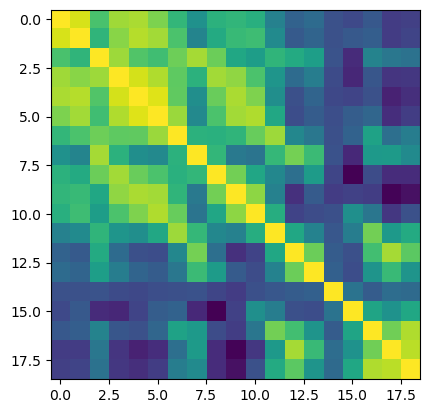

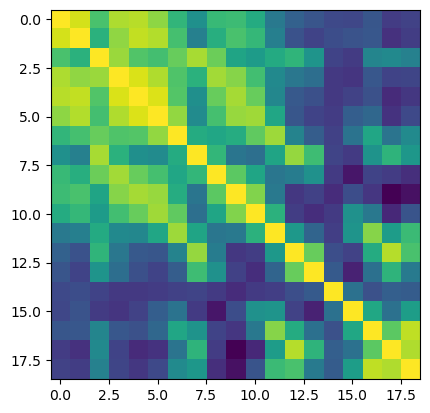

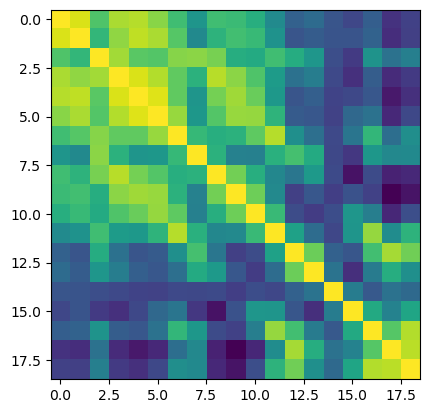

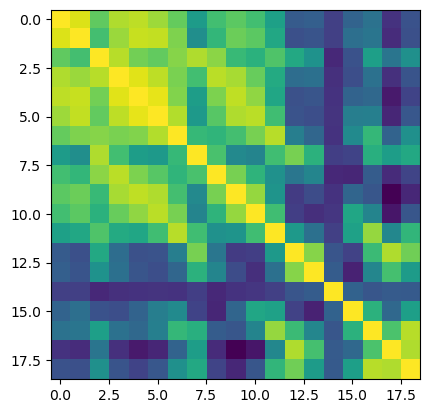

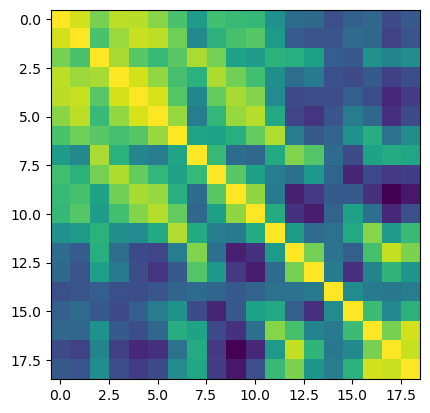

In [3]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(train_graphs[0, i])
    plt.show()

In [10]:
train_graphs.shape

(2717, 50, 19, 19)

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 30 07:34:26 2025

@author: mohamedr
"""

import scipy.sparse as sp
import numpy as np

from torch_geometric.data import Data
import torch
#from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = (adj - adj.min())/(adj.max() - adj.min())
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)) # D
    d_inv_sqrt = np.power(rowsum, -0.5).flatten() # D^-0.5
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt) # D^-0.5
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo() # D^-0.5AD^0.5

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model 
    and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0])).toarray()
    return adj_normalized

def normalize_all_adj(graphs):
    for graph_idx in range(graphs.shape[0]):
        for band_idx in range(graphs.shape[-1]):
            graphs[graph_idx, :, :, band_idx] = preprocess_adj(graphs[graph_idx, :, :, band_idx])
    return graphs


def build_pyg_dl(x, a, y, time_points, device):
    """Convert features and adjacency to PyTorch Geometric Dataloader"""
    a = torch.from_numpy(a)
    a = a + 1e-10 
    edge_attr = []
    
    for edge_time_idx in range(time_points):
        Af = a[edge_time_idx, :, :]
        Af.fill_diagonal_(1)
        edge_index, attrf = dense_to_sparse(Af)
        edge_attr.append(attrf)
    
    edge_attr = torch.stack(edge_attr)
    edge_attr = torch.moveaxis(edge_attr, 0, 1).to(device)
    edge_index = edge_index.to(device)
    x = torch.from_numpy(x).to(device)
    y = torch.tensor([y], dtype=torch.float).to(device)
    data = Data(x=x, edge_index=edge_index, 
                edge_attr=edge_attr, 
                y=y)
    return data


#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        X = X.reshape(-1, X.shape[1]*X.shape[3])
        self.scaler.fit(X)
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape(-1, X.shape[1]*X.shape[3])).reshape(X.shape)
        
def std_data(train_X, val_X):
    scaler = StandardScaler3D()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    return train_X, val_X


def fill_diag(x):
    num_channels = x.shape[1]
    num_bands = x.shape[0]
    x_diag = np.zeros((num_bands, num_channels, num_channels))
    for band_idx, band in enumerate(x):
        for idx, i in enumerate(band):
            x_diag[band_idx, idx, idx] = 0
            if idx == 0:
                x_diag[band_idx, idx, 1:] = i
            elif idx > 0 and idx < num_channels-1:
                x_diag[band_idx, idx, idx+1:] = i[idx:]
                x_diag[band_idx, idx, :idx] = i[:idx]
            elif idx == num_channels-1:
                x_diag[band_idx, idx, :-1] = i
    return x_diag

In [3]:
import torch, gc
from torch_geometric.loader import DataLoader
import random
from sklearn.model_selection import KFold    
from sklearn.preprocessing import OneHotEncoder


def loaders(train_X, train_graphs, train_y, test_X, test_graphs, test_y, device):
    #ohe
    ohe = OneHotEncoder()
    train_y_ohe = ohe.fit_transform(train_y).toarray()
    test_y_ohe = ohe.transform(test_y).toarray()
    
    # build pyg dataloader
    train_dataset = [build_pyg_dl(x, g, y, 100, device) for x, g, y in zip(train_X, train_graphs, train_y_ohe)]
    test_dataset = [build_pyg_dl(x, g, y, 100, device) for x, g, y in zip(test_X, test_graphs, test_y_ohe)]
    train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_iter, test_iter

In [4]:
train_iter, val_iter = loaders(train_X, train_graphs, train_y, test_X, test_graphs, test_y, DEVICE)

/var/folders/4k/d3wc_jw93m12xqfn1fcfg_2w0000gr/T/ipykernel_15515/4170408070.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)


In [16]:
#from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.nn.recurrent import GConvGRU

In [18]:
model = GConvGRU(in_channels=10, out_channels=32, K=1)

x = torch.randn(128*19, 10)
out = model(x, idx, attr)
out.shape

torch.Size([2432, 32])

In [5]:
# Temporal operators......etc.
from torch_geometric.nn import GCNConv, GATConv, ChebConv, TransformerConv, GINConv, SGConv, GeneralConv, SAGEConv
from torch_geometric_temporal.nn.recurrent import TGCN2, DCRNN, MPNNLSTM, A3TGCN2, GConvGRU, GConvLSTM, GCLSTM
from torch_geometric.nn import global_mean_pool, global_add_pool
import torch.nn as nn


class GraphTemporal(nn.Module):
    def __init__(self, num_ch, num_t, op="DCRNN"):
        super(GraphTemporal, self).__init__()
        self.lstm = nn.LSTM(input_size=32, hidden_size=10, num_layers=1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(32, 2)
        self.BN2 = nn.BatchNorm1d(296)
        self.BN1 = nn.BatchNorm2d(num_ch, 494)
        self.conv1 = nn.Conv2d(num_ch, num_ch, (3, 3), stride=(2, 1), padding=(0, 1), dilation=(3, 1))
        self.conv2 = nn.Conv2d(num_ch, num_ch, (5, 3), stride=(2, 1), padding=(1, 1), dilation=(3, 1))
        self.conv3 = nn.Conv2d(num_ch, num_ch, (10, 3), stride=(2, 1), padding=(3, 1), dilation=(3, 1))
        self.maxpool = nn.MaxPool2d((5, 1))
        self.relu = nn.ReLU()
        
        if op=="GCLSTM":
            self.GraphOp = GCLSTM(in_channels=296, out_channels=32, K=2)
        elif op=="GConvLSTM":
            self.GraphOp = GConvLSTM(in_channels=296, out_channels=32, K=2)
        elif op=="A3TGCN2":
            self.GraphOp = A3TGCN2(in_channels=296, out_channels=32, periods=50, batch_size=128)
        elif op=="MPNNLSTM":
            self.GraphOp = MPNNLSTM(in_channels=296, hidden_size=32, num_nodes=19, window=50, dropout=0.3)
        elif op=="DCRNN":
            self.GraphOp =  DCRNN(in_channels=296, out_channels=32, K=2)
        elif op=="GConvGRU":
            self.GraphOp = GConvGRU(in_channels=296, out_channels=32, K=2)
        self.num_ch = num_ch
        self.num_t = num_t

    
    def forward(self, x, idx, attr, batch=False):
        batch_size = int(x.shape[0]/self.num_ch)
        
        """
        x_stft = []
        for t_idx in range(self.num_t):
            x_t = x[:, :, t_idx]
            x_t = torch.stft(x_t, n_fft=256, return_complex=False)
            x_t = torch.mean(x_t[:, :, 0], -1)
            x_stft.append(x_t)
        x_stft = torch.stack(x_stft, -1)
        x_stft = x_stft.permute(0, 2, 1)
        x = x_stft
        x = x.permute(0, 2, 1)
        x = self.BN2(x)
        x = x.permute(0, 2, 1)
        """
        
        x = x.reshape(batch_size, self.num_ch, x.shape[-2], x.shape[-1])
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x = torch.cat([x1, x2, x3], dim=-2)
        x = self.maxpool(x)
        #x = self.BN1(x)
        x = self.relu(x)
        x = x.permute(0, 1, 3, 2)

        x = x.reshape(x.shape[0]*x.shape[1], x.shape[2], x.shape[3])
        x = x.permute(0, 2, 1)
        x = self.BN2(x)
        x = x.permute(0, 2, 1)
        #print(x.shape)
        
        for t_idx in range(self.num_t):
            attr_t = attr[:, t_idx]
            x_t = x[:, t_idx]
            if t_idx == 0:
                HS = self.GraphOp(x_t, idx, attr_t)
            else:
                HS = self.GraphOp(x_t, idx, attr_t, HS)
            if type(HS) == tuple:
                    HS = HS[0]
                
            out = self.relu(HS)
        out = global_mean_pool(out, batch)

        #out = torch.stack(all_G, -1)
        #out = out.permute(0, 2, 1)
        #out, (hn, cn) = self.lstm(out)
        #hn = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim = 1)
        #out = torch.flatten(out, start_dim=1)
        #out = self.BN2(out)
        #out = global_mean_pool(out, batch)
        out = self.linear(out)
        return out


model = GraphTemporal(num_ch=19, num_t=50, op="GConvGRU").to(DEVICE)
num_epochs = 100
x = next(iter(train_iter)).x.float()
idx = next(iter(train_iter)).edge_index.long()
attr = next(iter(train_iter)).edge_attr.float()
y = next(iter(train_iter)).y
batch = next(iter(train_iter)).batch
out = model(x, idx, attr, batch)
out.shape

torch.Size([128, 2])

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score
from tqdm import tqdm
import torch
import numpy as np


def print_acc(model, data_iter):
    outs= []
    ys = []
    
    model.eval()
    with torch.no_grad():
        for batch in data_iter:
            x = batch.x.float()
            idx = batch.edge_index.long()
            attr = batch.edge_attr.float()
            y = batch.y
            batch = batch.batch
            y = torch.argmax(y, -1)
            out = model(x, idx, attr, batch)
            out = torch.exp(out)
            outs.extend(out.cpu().detach().numpy())
            ys.extend(y.cpu().detach().numpy())
    
    outs = np.array(outs)
    ys = np.array(ys)
    outs = np.argmax(outs, -1)

    metrics = [accuracy_score(outs, ys), f1_score(outs, ys), 
               precision_score(outs, ys), recall_score(outs, ys),
               confusion_matrix(outs, ys)]
    return metrics

    
def train_model(model, num_epochs, data_iter, val_iter=None):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)

    best_val_acc = 0
    best_model = None
    
    model.train()
    for epoch in tqdm(range(num_epochs)): 
        model.train()
        losses = 0
        for _, batch in enumerate(data_iter):
            x = batch.x.float()
            idx = batch.edge_index.long()
            attr = batch.edge_attr.float()
            y = batch.y
            batch = batch.batch
            y = torch.argmax(y, -1)
            optimizer.zero_grad()
            out = model(x, idx, attr, batch)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            losses += loss.item() 

        print(print_acc(model, test_iter))
        #if print_acc(model, val_iter)[0] >= best_val_acc:
        best_model = model
    return best_model            

In [7]:
num_epochs = 40
train_iter, test_iter  = loaders(train_X, train_graphs, train_y, test_X, test_graphs, test_y, DEVICE)

model = GraphTemporal(num_ch=19, num_t=50, op="GConvGRU").to(DEVICE)

#kf = KFold(n_splits=5, shuffle=True)
#for i, (train_index, val_index) in enumerate(kf.split(train_X)):
    #model = LSTMmodel(num_ch=19, num_t=50, op="GConvGRU")
    #train_sub_X = train_X[train_index]
    #val_X = train_X[val_index]
    #train_sub_graphs = train_graphs[train_index]
    #val_graphs = train_graphs[val_index]
    #train_sub_y = train_y[train_index]
    #val_y = train_y[val_index]
    #train_iter, val_iter = loaders(train_sub_X, train_sub_graphs, train_sub_y, val_X, val_graphs, val_y, DEVICE)
model = train_model(model, num_epochs, train_iter)
print("Finished Training")
print("Evaluation on Test Data")
print(print_acc(model, test_iter))

  2%|▎         | 1/40 [05:58<3:52:49, 358.20s/it]

[0.6455223880597015, 0.6925566343042071, 0.8699186991869918, 0.5752688172043011, array([[ 66,  16],
       [ 79, 107]])]


  5%|▌         | 2/40 [12:03<3:49:19, 362.09s/it]

[0.746268656716418, 0.7068965517241379, 0.6666666666666666, 0.7522935779816514, array([[118,  41],
       [ 27,  82]])]


  8%|▊         | 3/40 [17:57<3:41:04, 358.51s/it]

[0.7761194029850746, 0.75, 0.7317073170731707, 0.7692307692307693, array([[118,  33],
       [ 27,  90]])]


 10%|█         | 4/40 [23:58<3:35:48, 359.68s/it]

[0.7574626865671642, 0.752851711026616, 0.8048780487804879, 0.7071428571428572, array([[104,  24],
       [ 41,  99]])]


 10%|█         | 4/40 [26:30<3:58:31, 397.55s/it]


KeyboardInterrupt: 

features        train_X1900.npy train_X500.npy  train_y1500.npy train_y2600.npy
train_X0.npy    train_X200.npy  train_X600.npy  train_y1600.npy train_y2700.npy
train_X100.npy  train_X2000.npy train_X700.npy  train_y1700.npy train_y300.npy
train_X1000.npy train_X2100.npy train_X800.npy  train_y1800.npy train_y400.npy
train_X1100.npy train_X2200.npy train_X900.npy  train_y1900.npy train_y500.npy
train_X1200.npy train_X2300.npy train_y0.npy    train_y200.npy  train_y600.npy
train_X1300.npy train_X2400.npy train_y100.npy  train_y2000.npy train_y700.npy
train_X1400.npy train_X2500.npy train_y1000.npy train_y2100.npy train_y800.npy
train_X1500.npy train_X2600.npy train_y1100.npy train_y2200.npy train_y900.npy
train_X1600.npy train_X2700.npy train_y1200.npy train_y2300.npy
train_X1700.npy train_X300.npy  train_y1300.npy train_y2400.npy
train_X1800.npy train_X400.npy  train_y1400.npy train_y2500.npy


In [23]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
import torch.nn as nn
from torch_scatter import scatter_add
from torch_geometric.utils import add_self_loops


class TGCN(torch.nn.Module):
    r"""An implementation of the Temporal Graph Convolutional Gated Recurrent Cell.
    For details see this paper: `"T-GCN: A Temporal Graph ConvolutionalNetwork for
    Traffic Prediction." <https://arxiv.org/abs/1811.05320>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        improved (bool): Stronger self loops. Default is False.
        cached (bool): Caching the message weights. Default is False.
        add_self_loops (bool): Adding self-loops for smoothing. Default is True.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
    ):
        super(TGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops

        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_z = GATConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels)

        self.linear_z = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_reset_gate_parameters_and_layers(self):

        self.conv_r = GATConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels)

        self.linear_r = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_h = GATConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels)

        self.linear_h = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_weight, H):
        Z = torch.cat([self.conv_z(X, edge_index, edge_weight), H], axis=1)
        Z = self.linear_z(Z)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_weight, H):
        R = torch.cat([self.conv_r(X, edge_index, edge_weight), H], axis=1)
        R = self.linear_r(R)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_weight, H, R):
        H_tilde = torch.cat([self.conv_h(X, edge_index, edge_weight), H * R], axis=1)
        H_tilde = self.linear_h(H_tilde)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** *(PyTorch Float Tensor)* - Node features.
            * **edge_index** *(PyTorch Long Tensor)* - Graph edge indices.
            * **edge_weight** *(PyTorch Long Tensor, optional)* - Edge weight vector.
            * **H** *(PyTorch Float Tensor, optional)* - Hidden state matrix for all nodes.

        Return types:
            * **H** *(PyTorch Float Tensor)* - Hidden state matrix for all nodes.
        """
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_weight, H)
        R = self._calculate_reset_gate(X, edge_index, edge_weight, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_weight, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H
    
    
    
class A3TGCN(torch.nn.Module):
    r"""An implementation of the Attention Temporal Graph Convolutional Cell.
    For details see this paper: `"A3T-GCN: Attention Temporal Graph Convolutional
    Network for Traffic Forecasting." <https://arxiv.org/abs/2006.11583>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        periods (int): Number of time periods.
        improved (bool): Stronger self loops (default :obj:`False`).
        cached (bool): Caching the message weights (default :obj:`False`).
        add_self_loops (bool): Adding self-loops for smoothing (default :obj:`True`).
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        periods: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True
    ):
        super(A3TGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.periods = periods
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self._setup_layers()

    def _setup_layers(self):
        self._base_tgcn = TGCN(
            in_channels=4,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )
        #self.Encoder =  Encoder(timepoints=100, num_nodes=19)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.attention = torch.nn.Parameter(torch.empty(self.periods, device=device))
        torch.nn.init.uniform_(self.attention)


        num_ch = 19
        self.num_ch = num_ch
        self.linear = nn.Linear(20, 2)
        self.BN2 = nn.BatchNorm1d(18)
        self.BN1 = nn.BatchNorm2d(num_ch, 4)
        self.conv1 = nn.Conv2d(num_ch, num_ch, (5, 5), stride=(3, 1), padding=(4, 2), dilation=(3, 1))
        self.conv2 = nn.Conv2d(num_ch, num_ch, (5, 5), stride=(3, 1), padding=(4, 2), dilation=(3, 1))
        self.conv3 = nn.Conv2d(num_ch, num_ch, (5, 5), stride=(3, 1), padding=(4, 2), dilation=(3, 1))
        self.maxpool = nn.MaxPool2d((8, 1))
        self.relu = nn.ReLU()
        

    def forward(self, x, idx, attr):
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** (PyTorch Float Tensor): Node features for T time periods.
            * **edge_index** (PyTorch Long Tensor): Graph edge indices.
            * **edge_weight** (PyTorch Long Tensor, optional)*: Edge weight vector.
            * **H** (PyTorch Float Tensor, optional): Hidden state matrix for all nodes.

        Return types:
            * **H** (PyTorch Float Tensor): Hidden state matrix for all nodes.
        """

        
        batch_size = int(x.shape[0]/self.num_ch)
        x = x.reshape(batch_size, self.num_ch, x.shape[-2], x.shape[-1])
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.BN1(x)
        x = self.relu(x)
        x = x.permute(0, 1, 3, 2)
        x = x.reshape(x.shape[0]*x.shape[1], x.shape[2], x.shape[3])

        
        H_accum = 0
        H = None
        probs = torch.nn.functional.softmax(self.attention, dim=0)
        for period in range(self.periods):
            attr_t = attr[:, period]
            x_t = x[:, period]            
            temp_emb = self._base_tgcn(x_t, idx, attr_t, H)
            temp_emb = temp_emb.reshape(batch_size, 19, 32)
            H_accum = H_accum + probs[period] * temp_emb #([32, 207, 32]
        H_accum = H_accum.reshape(batch_size*19, 32)
        return H_accum

class A3TGCNClassifier(torch.nn.Module):
    def __init__(self, num_ch, num_t):
        super().__init__()
        self.enc = A3TGCN(in_channels=4,
                          out_channels=32,
                          periods=num_t)
        self.linear = nn.Linear(32, 2)

    def forward(self, x, idx, attr, batch=False):
        out = self.enc(x, idx, attr)
        out = global_mean_pool(out, batch)
        out = self.linear(out)
        return out

model = A3TGCNClassifier(num_ch=19, num_t=30)
num_epochs = 100
x = next(iter(train_iter)).x.float()
idx = next(iter(train_iter)).edge_index.long()
attr = next(iter(train_iter)).edge_attr.float()
y = next(iter(train_iter)).y
batch = next(iter(train_iter)).batch
out = model(x, idx, attr, batch)
out.shape

torch.Size([16, 2])

In [10]:
2717/32

84.90625

torch.Size([32, 2])

In [75]:
import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = JODIEDataset("test_data", name='wikipedia')
data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
data = data.to(device)

data.msg.shape

torch.Size([157474, 172])

In [77]:
157474/9227

17.066652216321664

In [76]:
data.num_nodes

9227

In [ ]:
# This code achieves a performance of around 96.60%. However, it is not
# directly comparable to the results reported by the TGN paper since a
# slightly different evaluation setup is used here.
# In particular, predictions in the same batch are made in parallel, i.e.
# predictions for interactions later in the batch have no access to any
# information whatsoever about previous interactions in the same batch.
# On the contrary, when sampling node neighborhoods for interactions later in
# the batch, the TGN paper code has access to previous interactions in the
# batch.
# While both approaches are correct, together with the authors of the paper we
# decided to present this version here as it is more realsitic and a better
# test bed for future methods.

import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'JODIE')
dataset = JODIEDataset(path, name='wikipedia')
data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
data = data.to(device)


class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                    dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)

"""
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)
"""

memory_dim = time_dim = embedding_dim = 30
num_nodes = 19
embedding_dim = 32


memory = TGNMemory(
    num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)



model = gnn()
num_epochs = 100
x = next(iter(train_iter)).x.float()
idx = next(iter(train_iter)).edge_index.long()
attr = next(iter(train_iter)).edge_attr.float()
y = next(iter(train_iter)).y
batch = next(iter(train_iter)).batch
out = model(x, idx, attr, batch)
out.shape




"""
link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters())
    | set(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

# Helper vector to map global node indices to local ones.
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)
"""




def train():
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()  # Start with a fresh memory.
    neighbor_loader.reset_state()  # Start with an empty graph.

    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Get updated memory of all nodes involved in the computation.
        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))

        # Update memory and neighbor loader with ground-truth state.
        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events


In [162]:
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, GRUCell
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Linear
import numpy as np

class ROLANDGNN(torch.nn.Module):
    def __init__(self, input_dim, num_nodes, dropout=0.0, update='mlp'):
        
        super(ROLANDGNN, self).__init__()
        #Architecture: 
            #2 MLP layers to preprocess BERT repr, 
            #2 GCN layer to aggregate node embeddings
            #HadamardMLP as link prediction decoder
        
        #You can change the layer dimensions but 
        #if you change the architecture you need to change the forward method too
        #TODO: make the architecture parameterizable
        
        hidden_conv_1 = 64 
        hidden_conv_2 = 32
        self.preprocess1 = Linear(input_dim, 256)
        self.preprocess2 = Linear(256, 128)
        self.conv1 = GCNConv(128, hidden_conv_1)
        self.conv2 = GCNConv(hidden_conv_1, hidden_conv_2)
        self.postprocess1 = Linear(hidden_conv_2, 2)
        
        #Initialize the loss function to BCEWithLogitsLoss
        self.loss_fn = loss()

        self.dropout = dropout
        self.update = update
        if update=='moving':
            self.tau = torch.Tensor([0])
        elif update=='lwa':
            self.tau = torch.nn.Parameter(torch.Tensor([0]))
        elif update=='gru':
            self.gru1 = GRUCell(hidden_conv_1, hidden_conv_1)
            self.gru2 = GRUCell(hidden_conv_2, hidden_conv_2)
        elif update=='mlp':
            self.mlp1 = Linear(hidden_conv_1*2, hidden_conv_1)
            self.mlp2 = Linear(hidden_conv_2*2, hidden_conv_2)
        else:
            assert(update>=0 and update <=1)
            self.tau = torch.Tensor([update])
        self.previous_embeddings = [torch.Tensor([[0 for i in range(hidden_conv_1)] for j in range(num_nodes)]),\
                                    torch.Tensor([[0 for i in range(hidden_conv_2)] for j in range(num_nodes)])]
                                    
        
    def reset_loss(self,loss=BCEWithLogitsLoss):
        self.loss_fn = loss()
        
    def reset_parameters(self):
        self.preprocess1.reset_parameters()
        self.preprocess2.reset_parameters()
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.postprocess1.reset_parameters()  

    def forward(self, x, edge_index, edge_label_index, previous_embeddings=None, num_current_edges=None, num_previous_edges=None):
        
        batch_size = int(x.shape[0]/self.num_ch)
        x = x.reshape(batch_size, self.num_ch, x.shape[-2], x.shape[-1])
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.BN1(x)
        x = self.relu(x)
        x = x.permute(0, 1, 3, 2)
        x = x.reshape(x.shape[0]*x.shape[1], x.shape[2], x.shape[3])
        
        #You do not need all the parameters to be different to None in test phase
        #You can just use the saved previous embeddings and tau
        if previous_embeddings is not None: #None if test
            self.previous_embeddings = [previous_embeddings[0].clone(),previous_embeddings[1].clone()]
        if self.update=='moving' and num_current_edges is not None and num_previous_edges is not None: #None if test
            #compute moving average parameter
            self.tau = torch.Tensor([num_previous_edges / (num_previous_edges + num_current_edges)]).clone() # tau -- past weight
        
        current_embeddings = [torch.Tensor([]),torch.Tensor([])]
        
        #Preprocess text
        h = self.preprocess1(x)
        h = F.leaky_relu(h,inplace=True)
        h = F.dropout(h, p=self.dropout,inplace=True)
        h = self.preprocess2(h)
        h = F.leaky_relu(h,inplace=True)
        h = F.dropout(h, p=self.dropout, inplace=True)
        
        #GRAPHCONV
        #GraphConv1
        h = self.conv1(h, edge_index)
        h = F.leaky_relu(h,inplace=True)
        h = F.dropout(h, p=self.dropout,inplace=True)
        #Embedding Update after first layer
        if self.update=='gru':
            h = torch.Tensor(self.gru1(h, self.previous_embeddings[0].clone()).detach().numpy())
        elif self.update=='mlp':
            hin = torch.cat((h,self.previous_embeddings[0].clone()),dim=1)
            h = torch.Tensor(self.mlp1(hin).detach().numpy())
        else:
            h = torch.Tensor((self.tau * self.previous_embeddings[0].clone() + (1-self.tau) * h.clone()).detach().numpy())
       
        current_embeddings[0] = h.clone()
        #GraphConv2
        h = self.conv2(h, edge_index)
        h = F.leaky_relu(h,inplace=True)
        h = F.dropout(h, p=self.dropout,inplace=True)
        #Embedding Update after second layer
        if self.update=='gru':
            h = torch.Tensor(self.gru2(h, self.previous_embeddings[1].clone()).detach().numpy())
        elif self.update=='mlp':
            hin = torch.cat((h,self.previous_embeddings[1].clone()),dim=1)
            h = torch.Tensor(self.mlp2(hin).detach().numpy())
        else:
            h = torch.Tensor((self.tau * self.previous_embeddings[1].clone() + (1-self.tau) * h.clone()).detach().numpy())
      
        current_embeddings[1] = h.clone()
        #HADAMARD MLP
        h_src = h[edge_label_index[0]]
        h_dst = h[edge_label_index[1]]
        h_hadamard = torch.mul(h_src, h_dst) #hadamard product
        h = self.postprocess1(h_hadamard)
        h = torch.sum(h.clone(), dim=-1).clone()
        
        #return both 
        #i)the predictions for the current snapshot 
        #ii) the embeddings of current snapshot

        return h, current_embeddings



model = A3TGCNClassifier(num_ch=19, num_t=30)
num_epochs = 100
x = next(iter(train_iter)).x.float()
idx = next(iter(train_iter)).edge_index.long()
attr = next(iter(train_iter)).edge_attr.float()
y = next(iter(train_iter)).y
batch = next(iter(train_iter)).batch
out = model(x, idx, attr, batch)
out.shape

torch.Size([32, 2])

In [82]:
from torch_geometric.datasets import BitcoinOTC

data = BitcoinOTC('bitcoinOTC/')

Extracting bitcoinOTC/raw/soc-sign-bitcoinotc.csv.gz
Processing...
Done!


In [88]:
data.num_nodes

6005

In [83]:
input_dim = data[0].num_node_features
hidden_conv1 = 64
hidden_conv2 = 32
num_classes = 2
num_nodes = data[0].num_nodes

BitcoinOTC(138)

  0%|          | 0/2 [00:00<?, ?it/s]

accuracy: 0.8744939271255061 f1 score: 0.8645212554628526 precision: 0.8083209509658247 recall: 0.9291204099060631 confusion matrix: [[1288  258]
 [  83 1088]]
[0.8744939271255061, 0.8645212554628526, 0.8083209509658247, 0.9291204099060631, array([[1288,  258],
       [  83, 1088]])]


In [160]:
print(print_acc(model, test_iter))

accuracy: 0.7717391304347826 f1 score: 0.7364016736401674 precision: 0.6984126984126984 recall: 0.7787610619469026 confusion matrix: [[125  38]
 [ 25  88]]
[0.7717391304347826, 0.7364016736401674, 0.6984126984126984, 0.7787610619469026, array([[125,  38],
       [ 25,  88]])]


In [7]:
x_idx_row = []
x_idx_col = []
x_idx = []

for i in range(4):
    for j in range(3):
        x_idx_row.append(i)
        x_idx_col.append(j)
x_idx = (np.array(x_idx_row), np.array(x_idx_col))

In [8]:
x_idx

(array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]))

In [78]:
conn.get_data(output="dense").shape

(20, 19, 19, 89)

torch.Size([32, 2])

In [3]:
import numpy as np
import networkx as nx
from typing import List
from karateclub.estimator import Estimator
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from karateclub.utils.treefeatures import WeisfeilerLehmanHashing

class Graph2Vec(Estimator):
    r"""An implementation of `"Graph2Vec" <https://arxiv.org/abs/1707.05005>`_
    from the MLGWorkshop '17 paper "Graph2Vec: Learning Distributed Representations of Graphs".
    The procedure creates Weisfeiler-Lehman tree features for nodes in graphs. Using
    these features a document (graph) - feature co-occurrence matrix is decomposed in order
    to generate representations for the graphs.

    The procedure assumes that nodes have no string feature present and the WL-hashing
    defaults to the degree centrality. However, if a node feature with the key "feature"
    is supported for the nodes the feature extraction happens based on the values of this key.

    Args:
        wl_iterations (int): Number of Weisfeiler-Lehman iterations. Default is 2.
        attributed (bool): Presence of graph attributes. Default is False.
        dimensions (int): Dimensionality of embedding. Default is 128.
        workers (int): Number of cores. Default is 4.
        down_sampling (float): Down sampling frequency. Default is 0.0001.
        epochs (int): Number of epochs. Default is 10.
        learning_rate (float): HogWild! learning rate. Default is 0.025.
        min_count (int): Minimal count of graph feature occurrences. Default is 5.
        seed (int): Random seed for the model. Default is 42.
        erase_base_features (bool): Erasing the base features. Default is False.
    """

    def __init__(
        self,
        wl_iterations: int = 2,
        attributed: bool = False,
        dimensions: int = 128,
        workers: int = 4,
        down_sampling: float = 0.0001,
        epochs: int = 10,
        learning_rate: float = 0.025,
        min_count: int = 5,
        seed: int = 42,
        erase_base_features: bool = False):

        self.wl_iterations = wl_iterations
        self.attributed = attributed
        self.dimensions = dimensions
        self.workers = workers
        self.down_sampling = down_sampling
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.min_count = min_count
        self.seed = seed
        self.erase_base_features = erase_base_features

    def fit(self, graphs: List[nx.classes.graph.Graph]):
        """
        Fitting a Graph2Vec model.

        Arg types:
            * **graphs** *(List of NetworkX graphs)* - The graphs to be embedded.
        """
        self._set_seed()
        #graphs = self._check_graphs(graphs)
        documents = [
            WeisfeilerLehmanHashing(
                graph, self.wl_iterations, self.attributed, self.erase_base_features
            )
            for graph in graphs
        ]
        documents = [
            TaggedDocument(words=doc.get_graph_features(), tags=[str(i)])
            for i, doc in enumerate(documents)
        ]

        self.model = Doc2Vec(
            documents,
            vector_size=self.dimensions,
            window=0,
            min_count=self.min_count,
            dm=0,
            sample=self.down_sampling,
            workers=self.workers,
            epochs=self.epochs,
            alpha=self.learning_rate,
            seed=self.seed,
        )

        self._embedding = [self.model.docvecs[str(i)] for i, _ in enumerate(documents)]


    def get_embedding(self) -> np.array:
        r"""Getting the embedding of graphs.

        Return types:
            * **embedding** *(Numpy array)* - The embedding of graphs.
        """
        return np.array(self._embedding)


    def infer(self, graphs) -> np.array:
        """Infer the graph embeddings.
    
        Arg types:
            * **graphs** *(List of NetworkX graphs)* - The graphs to be embedded.

        Return types:
            * **embedding** *(Numpy array)* - The embedding of graphs.
        """
        self._set_seed()
        graphs = self._check_graphs(graphs)
        documents = [
            WeisfeilerLehmanHashing(
                graph, self.wl_iterations, self.attributed, self.erase_base_features
            )
            for graph in graphs
        ]

        documents = [doc.get_graph_features() for _, doc in enumerate(documents)]

        embedding = np.array(
            [
                self.model.infer_vector(
                    doc, alpha=self.learning_rate, min_alpha=0.00001, epochs=self.epochs
                )
                for doc in documents
            ]
        )

        return embedding


In [4]:
import numpy as np

In [5]:
import torch
import torch.nn as nn
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=1, batch_first=True)
input = torch.randn(5, 3, 10)
output, (hn, cn) = rnn(input)
output.shape, hn.shape, cn.shape

(torch.Size([5, 3, 20]), torch.Size([1, 5, 20]), torch.Size([1, 5, 20]))

In [26]:
#from karateclub import Graph2Vec
import os


for i in range(5):
    G = nx.fast_gnp_random_graph(n=10 + i, p=0.5)
    nx.write_gml(G, 'graphs/graph_{i}.gml')


graphs = []
for i in range(5):
    G = nx.read_gml('graphs/graph_{i}.gml')
    graphs.append(G)

In [98]:
import networkx as nx
train_num_graphs = train_graphs.shape[0]
test_num_graphs = test_graphs.shape[0]
#train_y = train_y[:100]
#test_y = test_y[:100]
num_tgraphs = train_graphs.shape[1]
num_dim = 16

graphs = []
for i in range(train_num_graphs):
    for j in range(num_tgraphs):
        a = train_graphs[i, j, :, :]
        a = (a - a.min())/(a.max() - a.min())
        #a[a<0.5] = 0
        #a[a>0.5] = 1
        G = nx.from_numpy_array(a)
        graphs.append(G)

for i in range(test_num_graphs):
    for j in range(num_tgraphs):
        a = test_graphs[i, j, :, :]
        a = (a - a.min())/(a.max() - a.min())
        #a[a<0.5] = 0
        #a[a>0.5] = 1
        G = nx.from_numpy_array(a)
        graphs.append(G)
        
g2v = Graph2Vec(dimensions=num_dim, wl_iterations=2, attributed=False)
g2v.fit(graphs)

embeddings = g2v.get_embedding()
train_embeddings = embeddings[:train_num_graphs*num_tgraphs]
test_embeddings = embeddings[train_num_graphs*num_tgraphs:]
train_embeddings = train_embeddings.reshape(train_num_graphs, num_tgraphs, num_dim)
test_embeddings = test_embeddings.reshape(test_num_graphs, num_tgraphs, num_dim)
test_embeddings.shape, train_embeddings.shape

/var/folders/4k/d3wc_jw93m12xqfn1fcfg_2w0000gr/T/ipykernel_21922/3971639751.py:13: RuntimeWarning: invalid value encountered in divide
/var/folders/4k/d3wc_jw93m12xqfn1fcfg_2w0000gr/T/ipykernel_21922/3265339465.py:90: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).


((276, 30, 16), (2717, 30, 16))

In [18]:
#std = train_embeddings.std()
#mean = train_embeddings.mean()
#test_embeddings = (test_embeddings - mean)/(std)
#train_embeddings = (train_embeddings - mean)/(std)

In [99]:
import sklearn
for i in range(test_embeddings.shape[0]):
    test_embeddings[i, :, :] = sklearn.preprocessing.normalize(test_embeddings[i, :, :], norm='l2')

for i in range(train_embeddings.shape[0]):
    train_embeddings[i, :, :] = sklearn.preprocessing.normalize(train_embeddings[i, :, :], norm='l2')

In [31]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
train_y = enc.fit_transform(train_y).toarray()
test_y = enc.transform(test_y).toarray()

In [100]:
device = "cpu"
train_embeddings = torch.Tensor(train_embeddings).to(device)
ytrain = torch.Tensor(train_y).to(device)
batch_size = 64
train_data = torch.utils.data.TensorDataset(train_embeddings, ytrain)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)

In [101]:
device = "cpu"
test_embeddings = torch.Tensor(test_embeddings).to(device)
ytest = torch.Tensor(test_y).to(device)
batch_size = 64
test_data = torch.utils.data.TensorDataset(test_embeddings, ytest)
test_iter = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

In [102]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score
from tqdm import tqdm
import torch
import numpy as np


def print_acc(model, data_iter):
    outs= []
    ys = []
    
    model.eval()
    with torch.no_grad():
        for X, y in data_iter:
            y = torch.argmax(y, -1)
            out = model(X)
            out = torch.exp(out)
            outs.extend(out.cpu().detach().numpy())
            ys.extend(y.cpu().detach().numpy())
    
    outs = np.array(outs)
    ys = np.array(ys)
    outs = np.argmax(outs, -1)

    print("accuracy:", accuracy_score(outs, ys),
          "f1 score:", f1_score(outs, ys),
          "precision:",precision_score(outs, ys),
          "recall:", recall_score(outs, ys),
          "confusion matrix:", confusion_matrix(outs, ys))

    metrics = [accuracy_score(outs, ys), f1_score(outs, ys), 
               precision_score(outs, ys), recall_score(outs, ys),
               confusion_matrix(outs, ys)]
    
    return metrics

    
def train_model(model, num_epochs, data_iter, lr=1e-4):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    
    model.train()
    for epoch in tqdm(range(num_epochs)): 
        model.train()
        losses = 0
        for idx, (X, y) in enumerate(data_iter):
            y = torch.argmax(y, -1)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            losses += loss
        print(print_acc(model, test_iter))
    return model

In [104]:
class LSTMmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=32, hidden_size=10, num_layers=1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(20, 2)
        self.BN = nn.BatchNorm1d(32)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.BN(x)
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.lstm(x)
        hn = hn.permute(1, 0, 2)
        #x = hn.squeeze()
        x = torch.flatten(hn, start_dim=1)
        x = self.linear(x)
        return x

model = LSTMmodel()
num_epochs = 100
model = train_model(model, num_epochs, train_iter, lr=1e-3)

  1%|          | 1/100 [00:00<00:38,  2.60it/s]

accuracy: 0.48188405797101447 f1 score: 0.5572755417956656 precision: 0.7142857142857143 recall: 0.45685279187817257 confusion matrix: [[ 43  36]
 [107  90]]
[0.48188405797101447, 0.5572755417956656, 0.7142857142857143, 0.45685279187817257, array([[ 43,  36],
       [107,  90]])]


  2%|▏         | 2/100 [00:00<00:34,  2.86it/s]

accuracy: 0.5181159420289855 f1 score: 0.4340425531914894 precision: 0.40476190476190477 recall: 0.46788990825688076 confusion matrix: [[92 75]
 [58 51]]
[0.5181159420289855, 0.4340425531914894, 0.40476190476190477, 0.46788990825688076, array([[92, 75],
       [58, 51]])]


  3%|▎         | 3/100 [00:01<00:34,  2.80it/s]

accuracy: 0.5362318840579711 f1 score: 0.4576271186440678 precision: 0.42857142857142855 recall: 0.4909090909090909 confusion matrix: [[94 72]
 [56 54]]
[0.5362318840579711, 0.4576271186440678, 0.42857142857142855, 0.4909090909090909, array([[94, 72],
       [56, 54]])]


  5%|▌         | 5/100 [00:01<00:26,  3.60it/s]

accuracy: 0.532608695652174 f1 score: 0.4266666666666667 precision: 0.38095238095238093 recall: 0.48484848484848486 confusion matrix: [[99 78]
 [51 48]]
[0.532608695652174, 0.4266666666666667, 0.38095238095238093, 0.48484848484848486, array([[99, 78],
       [51, 48]])]
accuracy: 0.5434782608695652 f1 score: 0.4473684210526316 precision: 0.40476190476190477 recall: 0.5 confusion matrix: [[99 75]
 [51 51]]
[0.5434782608695652, 0.4473684210526316, 0.40476190476190477, 0.5, array([[99, 75],
       [51, 51]])]


  7%|▋         | 7/100 [00:01<00:21,  4.25it/s]

accuracy: 0.5398550724637681 f1 score: 0.4641350210970464 precision: 0.4365079365079365 recall: 0.4954954954954955 confusion matrix: [[94 71]
 [56 55]]
[0.5398550724637681, 0.4641350210970464, 0.4365079365079365, 0.4954954954954955, array([[94, 71],
       [56, 55]])]
accuracy: 0.5108695652173914 f1 score: 0.43983402489626555 precision: 0.42063492063492064 recall: 0.4608695652173913 confusion matrix: [[88 73]
 [62 53]]
[0.5108695652173914, 0.43983402489626555, 0.42063492063492064, 0.4608695652173913, array([[88, 73],
       [62, 53]])]


  8%|▊         | 8/100 [00:02<00:21,  4.34it/s]

accuracy: 0.5398550724637681 f1 score: 0.44541484716157204 precision: 0.40476190476190477 recall: 0.49514563106796117 confusion matrix: [[98 75]
 [52 51]]
[0.5398550724637681, 0.44541484716157204, 0.40476190476190477, 0.49514563106796117, array([[98, 75],
       [52, 51]])]


  9%|▉         | 9/100 [00:02<00:20,  4.41it/s]

accuracy: 0.5362318840579711 f1 score: 0.452991452991453 precision: 0.42063492063492064 recall: 0.49074074074074076 confusion matrix: [[95 73]
 [55 53]]
[0.5362318840579711, 0.452991452991453, 0.42063492063492064, 0.49074074074074076, array([[95, 73],
       [55, 53]])]


 10%|█         | 10/100 [00:02<00:22,  4.09it/s]

accuracy: 0.5434782608695652 f1 score: 0.4661016949152542 precision: 0.4365079365079365 recall: 0.5 confusion matrix: [[95 71]
 [55 55]]
[0.5434782608695652, 0.4661016949152542, 0.4365079365079365, 0.5, array([[95, 71],
       [55, 55]])]


 11%|█         | 11/100 [00:02<00:23,  3.76it/s]

accuracy: 0.5543478260869565 f1 score: 0.4675324675324675 precision: 0.42857142857142855 recall: 0.5142857142857142 confusion matrix: [[99 72]
 [51 54]]
[0.5543478260869565, 0.4675324675324675, 0.42857142857142855, 0.5142857142857142, array([[99, 72],
       [51, 54]])]


 12%|█▏        | 12/100 [00:03<00:22,  4.00it/s]

accuracy: 0.5579710144927537 f1 score: 0.5 precision: 0.48412698412698413 recall: 0.5169491525423728 confusion matrix: [[93 65]
 [57 61]]
[0.5579710144927537, 0.5, 0.48412698412698413, 0.5169491525423728, array([[93, 65],
       [57, 61]])]


 13%|█▎        | 13/100 [00:03<00:21,  4.11it/s]

accuracy: 0.5471014492753623 f1 score: 0.5136186770428015 precision: 0.5238095238095238 recall: 0.5038167938931297 confusion matrix: [[85 60]
 [65 66]]
[0.5471014492753623, 0.5136186770428015, 0.5238095238095238, 0.5038167938931297, array([[85, 60],
       [65, 66]])]


 14%|█▍        | 14/100 [00:03<00:21,  3.97it/s]

accuracy: 0.5144927536231884 f1 score: 0.46825396825396826 precision: 0.46825396825396826 recall: 0.46825396825396826 confusion matrix: [[83 67]
 [67 59]]
[0.5144927536231884, 0.46825396825396826, 0.46825396825396826, 0.46825396825396826, array([[83, 67],
       [67, 59]])]


 15%|█▌        | 15/100 [00:03<00:21,  3.98it/s]

accuracy: 0.5362318840579711 f1 score: 0.488 precision: 0.48412698412698413 recall: 0.49193548387096775 confusion matrix: [[87 65]
 [63 61]]
[0.5362318840579711, 0.488, 0.48412698412698413, 0.49193548387096775, array([[87, 65],
       [63, 61]])]


 17%|█▋        | 17/100 [00:04<00:18,  4.43it/s]

accuracy: 0.5543478260869565 f1 score: 0.5099601593625498 precision: 0.5079365079365079 recall: 0.512 confusion matrix: [[89 62]
 [61 64]]
[0.5543478260869565, 0.5099601593625498, 0.5079365079365079, 0.512, array([[89, 62],
       [61, 64]])]
accuracy: 0.5362318840579711 f1 score: 0.518796992481203 precision: 0.5476190476190477 recall: 0.4928571428571429 confusion matrix: [[79 57]
 [71 69]]
[0.5362318840579711, 0.518796992481203, 0.5476190476190477, 0.4928571428571429, array([[79, 57],
       [71, 69]])]


 19%|█▉        | 19/100 [00:04<00:18,  4.39it/s]

accuracy: 0.532608695652174 f1 score: 0.5204460966542751 precision: 0.5555555555555556 recall: 0.48951048951048953 confusion matrix: [[77 56]
 [73 70]]
[0.532608695652174, 0.5204460966542751, 0.5555555555555556, 0.48951048951048953, array([[77, 56],
       [73, 70]])]
accuracy: 0.5471014492753623 f1 score: 0.5059288537549407 precision: 0.5079365079365079 recall: 0.5039370078740157 confusion matrix: [[87 62]
 [63 64]]
[0.5471014492753623, 0.5059288537549407, 0.5079365079365079, 0.5039370078740157, array([[87, 62],
       [63, 64]])]


 20%|██        | 20/100 [00:05<00:20,  3.93it/s]

accuracy: 0.5543478260869565 f1 score: 0.5214007782101168 precision: 0.5317460317460317 recall: 0.5114503816793893 confusion matrix: [[86 59]
 [64 67]]
[0.5543478260869565, 0.5214007782101168, 0.5317460317460317, 0.5114503816793893, array([[86, 59],
       [64, 67]])]


 21%|██        | 21/100 [00:05<00:21,  3.67it/s]

accuracy: 0.5615942028985508 f1 score: 0.5217391304347826 precision: 0.5238095238095238 recall: 0.5196850393700787 confusion matrix: [[89 60]
 [61 66]]
[0.5615942028985508, 0.5217391304347826, 0.5238095238095238, 0.5196850393700787, array([[89, 60],
       [61, 66]])]
accuracy: 0.5398550724637681 f1 score: 0.5415162454873647 precision: 0.5952380952380952 recall: 0.4966887417218543 confusion matrix: [[74 51]
 [76 75]]


 23%|██▎       | 23/100 [00:05<00:18,  4.26it/s]

[0.5398550724637681, 0.5415162454873647, 0.5952380952380952, 0.4966887417218543, array([[74, 51],
       [76, 75]])]
accuracy: 0.5579710144927537 f1 score: 0.5196850393700787 precision: 0.5238095238095238 recall: 0.515625 confusion matrix: [[88 60]
 [62 66]]
[0.5579710144927537, 0.5196850393700787, 0.5238095238095238, 0.515625, array([[88, 60],
       [62, 66]])]


 24%|██▍       | 24/100 [00:06<00:17,  4.37it/s]

accuracy: 0.5507246376811594 f1 score: 0.5303030303030303 precision: 0.5555555555555556 recall: 0.5072463768115942 confusion matrix: [[82 56]
 [68 70]]
[0.5507246376811594, 0.5303030303030303, 0.5555555555555556, 0.5072463768115942, array([[82, 56],
       [68, 70]])]


 26%|██▌       | 26/100 [00:06<00:17,  4.33it/s]

accuracy: 0.5615942028985508 f1 score: 0.5291828793774319 precision: 0.5396825396825397 recall: 0.5190839694656488 confusion matrix: [[87 58]
 [63 68]]
[0.5615942028985508, 0.5291828793774319, 0.5396825396825397, 0.5190839694656488, array([[87, 58],
       [63, 68]])]
accuracy: 0.5760869565217391 f1 score: 0.5338645418326693 precision: 0.5317460317460317 recall: 0.536 confusion matrix: [[92 59]
 [58 67]]
[0.5760869565217391, 0.5338645418326693, 0.5317460317460317, 0.536, array([[92, 59],
       [58, 67]])]


 27%|██▋       | 27/100 [00:06<00:16,  4.45it/s]

accuracy: 0.5507246376811594 f1 score: 0.5407407407407407 precision: 0.5793650793650794 recall: 0.5069444444444444 confusion matrix: [[79 53]
 [71 73]]
[0.5507246376811594, 0.5407407407407407, 0.5793650793650794, 0.5069444444444444, array([[79, 53],
       [71, 73]])]


 28%|██▊       | 28/100 [00:07<00:16,  4.28it/s]

accuracy: 0.5579710144927537 f1 score: 0.5158730158730159 precision: 0.5158730158730159 recall: 0.5158730158730159 confusion matrix: [[89 61]
 [61 65]]
[0.5579710144927537, 0.5158730158730159, 0.5158730158730159, 0.5158730158730159, array([[89, 61],
       [61, 65]])]


 29%|██▉       | 29/100 [00:07<00:16,  4.23it/s]

accuracy: 0.5688405797101449 f1 score: 0.5333333333333333 precision: 0.5396825396825397 recall: 0.5271317829457365 confusion matrix: [[89 58]
 [61 68]]
[0.5688405797101449, 0.5333333333333333, 0.5396825396825397, 0.5271317829457365, array([[89, 58],
       [61, 68]])]


 30%|███       | 30/100 [00:07<00:18,  3.70it/s]

accuracy: 0.5615942028985508 f1 score: 0.5217391304347826 precision: 0.5238095238095238 recall: 0.5196850393700787 confusion matrix: [[89 60]
 [61 66]]
[0.5615942028985508, 0.5217391304347826, 0.5238095238095238, 0.5196850393700787, array([[89, 60],
       [61, 66]])]


 32%|███▏      | 32/100 [00:08<00:16,  4.06it/s]

accuracy: 0.5579710144927537 f1 score: 0.5158730158730159 precision: 0.5158730158730159 recall: 0.5158730158730159 confusion matrix: [[89 61]
 [61 65]]
[0.5579710144927537, 0.5158730158730159, 0.5158730158730159, 0.5158730158730159, array([[89, 61],
       [61, 65]])]
accuracy: 0.5543478260869565 f1 score: 0.5358490566037736 precision: 0.5634920634920635 recall: 0.5107913669064749 confusion matrix: [[82 55]
 [68 71]]
[0.5543478260869565, 0.5358490566037736, 0.5634920634920635, 0.5107913669064749, array([[82, 55],
       [68, 71]])]


 33%|███▎      | 33/100 [00:08<00:15,  4.22it/s]

accuracy: 0.5362318840579711 f1 score: 0.5259259259259259 precision: 0.5634920634920635 recall: 0.4930555555555556 confusion matrix: [[77 55]
 [73 71]]
[0.5362318840579711, 0.5259259259259259, 0.5634920634920635, 0.4930555555555556, array([[77, 55],
       [73, 71]])]


 34%|███▍      | 34/100 [00:08<00:15,  4.18it/s]

accuracy: 0.5543478260869565 f1 score: 0.5176470588235295 precision: 0.5238095238095238 recall: 0.5116279069767442 confusion matrix: [[87 60]
 [63 66]]
[0.5543478260869565, 0.5176470588235295, 0.5238095238095238, 0.5116279069767442, array([[87, 60],
       [63, 66]])]


 35%|███▌      | 35/100 [00:08<00:15,  4.13it/s]

accuracy: 0.5507246376811594 f1 score: 0.5230769230769231 precision: 0.5396825396825397 recall: 0.5074626865671642 confusion matrix: [[84 58]
 [66 68]]
[0.5507246376811594, 0.5230769230769231, 0.5396825396825397, 0.5074626865671642, array([[84, 58],
       [66, 68]])]


 36%|███▌      | 36/100 [00:09<00:17,  3.71it/s]

accuracy: 0.5652173913043478 f1 score: 0.5238095238095238 precision: 0.5238095238095238 recall: 0.5238095238095238 confusion matrix: [[90 60]
 [60 66]]
[0.5652173913043478, 0.5238095238095238, 0.5238095238095238, 0.5238095238095238, array([[90, 60],
       [60, 66]])]


 37%|███▋      | 37/100 [00:09<00:17,  3.52it/s]

accuracy: 0.5471014492753623 f1 score: 0.50199203187251 precision: 0.5 recall: 0.504 confusion matrix: [[88 63]
 [62 63]]
[0.5471014492753623, 0.50199203187251, 0.5, 0.504, array([[88, 63],
       [62, 63]])]


 38%|███▊      | 38/100 [00:09<00:18,  3.35it/s]

accuracy: 0.5471014492753623 f1 score: 0.5059288537549407 precision: 0.5079365079365079 recall: 0.5039370078740157 confusion matrix: [[87 62]
 [63 64]]
[0.5471014492753623, 0.5059288537549407, 0.5079365079365079, 0.5039370078740157, array([[87, 62],
       [63, 64]])]


 39%|███▉      | 39/100 [00:10<00:18,  3.30it/s]

accuracy: 0.5434782608695652 f1 score: 0.5153846153846153 precision: 0.5317460317460317 recall: 0.5 confusion matrix: [[83 59]
 [67 67]]
[0.5434782608695652, 0.5153846153846153, 0.5317460317460317, 0.5, array([[83, 59],
       [67, 67]])]


 40%|████      | 40/100 [00:10<00:18,  3.30it/s]

accuracy: 0.5471014492753623 f1 score: 0.5136186770428015 precision: 0.5238095238095238 recall: 0.5038167938931297 confusion matrix: [[85 60]
 [65 66]]
[0.5471014492753623, 0.5136186770428015, 0.5238095238095238, 0.5038167938931297, array([[85, 60],
       [65, 66]])]


 41%|████      | 41/100 [00:10<00:18,  3.24it/s]

accuracy: 0.5543478260869565 f1 score: 0.5358490566037736 precision: 0.5634920634920635 recall: 0.5107913669064749 confusion matrix: [[82 55]
 [68 71]]
[0.5543478260869565, 0.5358490566037736, 0.5634920634920635, 0.5107913669064749, array([[82, 55],
       [68, 71]])]


 42%|████▏     | 42/100 [00:11<00:17,  3.26it/s]

accuracy: 0.5579710144927537 f1 score: 0.5413533834586466 precision: 0.5714285714285714 recall: 0.5142857142857142 confusion matrix: [[82 54]
 [68 72]]
[0.5579710144927537, 0.5413533834586466, 0.5714285714285714, 0.5142857142857142, array([[82, 54],
       [68, 72]])]


 43%|████▎     | 43/100 [00:11<00:18,  3.10it/s]

accuracy: 0.5434782608695652 f1 score: 0.5078125 precision: 0.5158730158730159 recall: 0.5 confusion matrix: [[85 61]
 [65 65]]
[0.5434782608695652, 0.5078125, 0.5158730158730159, 0.5, array([[85, 61],
       [65, 65]])]


 44%|████▍     | 44/100 [00:11<00:20,  2.75it/s]

accuracy: 0.5362318840579711 f1 score: 0.5076923076923077 precision: 0.5238095238095238 recall: 0.4925373134328358 confusion matrix: [[82 60]
 [68 66]]
[0.5362318840579711, 0.5076923076923077, 0.5238095238095238, 0.4925373134328358, array([[82, 60],
       [68, 66]])]


 45%|████▌     | 45/100 [00:12<00:20,  2.74it/s]

accuracy: 0.5434782608695652 f1 score: 0.5263157894736842 precision: 0.5555555555555556 recall: 0.5 confusion matrix: [[80 56]
 [70 70]]
[0.5434782608695652, 0.5263157894736842, 0.5555555555555556, 0.5, array([[80, 56],
       [70, 70]])]


 46%|████▌     | 46/100 [00:12<00:18,  2.85it/s]

accuracy: 0.5543478260869565 f1 score: 0.5176470588235295 precision: 0.5238095238095238 recall: 0.5116279069767442 confusion matrix: [[87 60]
 [63 66]]
[0.5543478260869565, 0.5176470588235295, 0.5238095238095238, 0.5116279069767442, array([[87, 60],
       [63, 66]])]


 47%|████▋     | 47/100 [00:12<00:17,  2.96it/s]

accuracy: 0.5362318840579711 f1 score: 0.5259259259259259 precision: 0.5634920634920635 recall: 0.4930555555555556 confusion matrix: [[77 55]
 [73 71]]
[0.5362318840579711, 0.5259259259259259, 0.5634920634920635, 0.4930555555555556, array([[77, 55],
       [73, 71]])]


 48%|████▊     | 48/100 [00:13<00:16,  3.09it/s]

accuracy: 0.5434782608695652 f1 score: 0.5263157894736842 precision: 0.5555555555555556 recall: 0.5 confusion matrix: [[80 56]
 [70 70]]
[0.5434782608695652, 0.5263157894736842, 0.5555555555555556, 0.5, array([[80, 56],
       [70, 70]])]


 49%|████▉     | 49/100 [00:13<00:16,  3.11it/s]

accuracy: 0.5579710144927537 f1 score: 0.5271317829457365 precision: 0.5396825396825397 recall: 0.5151515151515151 confusion matrix: [[86 58]
 [64 68]]
[0.5579710144927537, 0.5271317829457365, 0.5396825396825397, 0.5151515151515151, array([[86, 58],
       [64, 68]])]


 50%|█████     | 50/100 [00:13<00:15,  3.20it/s]

accuracy: 0.5289855072463768 f1 score: 0.5422535211267606 precision: 0.6111111111111112 recall: 0.4873417721518987 confusion matrix: [[69 49]
 [81 77]]
[0.5289855072463768, 0.5422535211267606, 0.6111111111111112, 0.4873417721518987, array([[69, 49],
       [81, 77]])]


 51%|█████     | 51/100 [00:14<00:15,  3.18it/s]

accuracy: 0.5652173913043478 f1 score: 0.5384615384615384 precision: 0.5555555555555556 recall: 0.5223880597014925 confusion matrix: [[86 56]
 [64 70]]
[0.5652173913043478, 0.5384615384615384, 0.5555555555555556, 0.5223880597014925, array([[86, 56],
       [64, 70]])]


 52%|█████▏    | 52/100 [00:14<00:15,  3.18it/s]

accuracy: 0.5471014492753623 f1 score: 0.5318352059925093 precision: 0.5634920634920635 recall: 0.5035460992907801 confusion matrix: [[80 55]
 [70 71]]
[0.5471014492753623, 0.5318352059925093, 0.5634920634920635, 0.5035460992907801, array([[80, 55],
       [70, 71]])]


 53%|█████▎    | 53/100 [00:14<00:14,  3.17it/s]

accuracy: 0.5398550724637681 f1 score: 0.5480427046263345 precision: 0.6111111111111112 recall: 0.4967741935483871 confusion matrix: [[72 49]
 [78 77]]
[0.5398550724637681, 0.5480427046263345, 0.6111111111111112, 0.4967741935483871, array([[72, 49],
       [78, 77]])]


 54%|█████▍    | 54/100 [00:14<00:14,  3.16it/s]

accuracy: 0.5362318840579711 f1 score: 0.5524475524475524 precision: 0.626984126984127 recall: 0.49375 confusion matrix: [[69 47]
 [81 79]]
[0.5362318840579711, 0.5524475524475524, 0.626984126984127, 0.49375, array([[69, 47],
       [81, 79]])]


 55%|█████▌    | 55/100 [00:15<00:14,  3.18it/s]

accuracy: 0.5289855072463768 f1 score: 0.5422535211267606 precision: 0.6111111111111112 recall: 0.4873417721518987 confusion matrix: [[69 49]
 [81 77]]
[0.5289855072463768, 0.5422535211267606, 0.6111111111111112, 0.4873417721518987, array([[69, 49],
       [81, 77]])]


 56%|█████▌    | 56/100 [00:15<00:13,  3.17it/s]

accuracy: 0.5652173913043478 f1 score: 0.5419847328244275 precision: 0.5634920634920635 recall: 0.5220588235294118 confusion matrix: [[85 55]
 [65 71]]
[0.5652173913043478, 0.5419847328244275, 0.5634920634920635, 0.5220588235294118, array([[85, 55],
       [65, 71]])]


 57%|█████▋    | 57/100 [00:15<00:14,  3.03it/s]

accuracy: 0.572463768115942 f1 score: 0.5241935483870968 precision: 0.5158730158730159 recall: 0.5327868852459017 confusion matrix: [[93 61]
 [57 65]]
[0.572463768115942, 0.5241935483870968, 0.5158730158730159, 0.5327868852459017, array([[93, 61],
       [57, 65]])]


 58%|█████▊    | 58/100 [00:16<00:13,  3.01it/s]

accuracy: 0.5760869565217391 f1 score: 0.5447470817120622 precision: 0.5555555555555556 recall: 0.5343511450381679 confusion matrix: [[89 56]
 [61 70]]
[0.5760869565217391, 0.5447470817120622, 0.5555555555555556, 0.5343511450381679, array([[89, 56],
       [61, 70]])]


 59%|█████▉    | 59/100 [00:16<00:13,  3.06it/s]

accuracy: 0.572463768115942 f1 score: 0.5461538461538461 precision: 0.5634920634920635 recall: 0.5298507462686567 confusion matrix: [[87 55]
 [63 71]]
[0.572463768115942, 0.5461538461538461, 0.5634920634920635, 0.5298507462686567, array([[87, 55],
       [63, 71]])]


 60%|██████    | 60/100 [00:16<00:12,  3.12it/s]

accuracy: 0.5652173913043478 f1 score: 0.5384615384615384 precision: 0.5555555555555556 recall: 0.5223880597014925 confusion matrix: [[86 56]
 [64 70]]
[0.5652173913043478, 0.5384615384615384, 0.5555555555555556, 0.5223880597014925, array([[86, 56],
       [64, 70]])]


 61%|██████    | 61/100 [00:17<00:12,  3.08it/s]

accuracy: 0.572463768115942 f1 score: 0.5390625 precision: 0.5476190476190477 recall: 0.5307692307692308 confusion matrix: [[89 57]
 [61 69]]
[0.572463768115942, 0.5390625, 0.5476190476190477, 0.5307692307692308, array([[89, 57],
       [61, 69]])]


 62%|██████▏   | 62/100 [00:17<00:12,  3.12it/s]

accuracy: 0.5688405797101449 f1 score: 0.5333333333333333 precision: 0.5396825396825397 recall: 0.5271317829457365 confusion matrix: [[89 58]
 [61 68]]
[0.5688405797101449, 0.5333333333333333, 0.5396825396825397, 0.5271317829457365, array([[89, 58],
       [61, 68]])]


 63%|██████▎   | 63/100 [00:17<00:11,  3.14it/s]

accuracy: 0.5615942028985508 f1 score: 0.5363984674329502 precision: 0.5555555555555556 recall: 0.5185185185185185 confusion matrix: [[85 56]
 [65 70]]
[0.5615942028985508, 0.5363984674329502, 0.5555555555555556, 0.5185185185185185, array([[85, 56],
       [65, 70]])]


 64%|██████▍   | 64/100 [00:18<00:11,  3.15it/s]

accuracy: 0.5579710144927537 f1 score: 0.5514705882352942 precision: 0.5952380952380952 recall: 0.5136986301369864 confusion matrix: [[79 51]
 [71 75]]
[0.5579710144927537, 0.5514705882352942, 0.5952380952380952, 0.5136986301369864, array([[79, 51],
       [71, 75]])]


 65%|██████▌   | 65/100 [00:18<00:10,  3.25it/s]

accuracy: 0.5543478260869565 f1 score: 0.5393258426966292 precision: 0.5714285714285714 recall: 0.5106382978723404 confusion matrix: [[81 54]
 [69 72]]
[0.5543478260869565, 0.5393258426966292, 0.5714285714285714, 0.5106382978723404, array([[81, 54],
       [69, 72]])]


 66%|██████▌   | 66/100 [00:18<00:10,  3.23it/s]

accuracy: 0.572463768115942 f1 score: 0.528 precision: 0.5238095238095238 recall: 0.532258064516129 confusion matrix: [[92 60]
 [58 66]]
[0.572463768115942, 0.528, 0.5238095238095238, 0.532258064516129, array([[92, 60],
       [58, 66]])]


 67%|██████▋   | 67/100 [00:19<00:10,  3.21it/s]

accuracy: 0.5797101449275363 f1 score: 0.5166666666666667 precision: 0.49206349206349204 recall: 0.543859649122807 confusion matrix: [[98 64]
 [52 62]]
[0.5797101449275363, 0.5166666666666667, 0.49206349206349204, 0.543859649122807, array([[98, 64],
       [52, 62]])]


 68%|██████▊   | 68/100 [00:19<00:10,  3.17it/s]

accuracy: 0.5688405797101449 f1 score: 0.5369649805447471 precision: 0.5476190476190477 recall: 0.5267175572519084 confusion matrix: [[88 57]
 [62 69]]
[0.5688405797101449, 0.5369649805447471, 0.5476190476190477, 0.5267175572519084, array([[88, 57],
       [62, 69]])]


 69%|██████▉   | 69/100 [00:19<00:09,  3.22it/s]

accuracy: 0.5471014492753623 f1 score: 0.5098039215686274 precision: 0.5158730158730159 recall: 0.5038759689922481 confusion matrix: [[86 61]
 [64 65]]
[0.5471014492753623, 0.5098039215686274, 0.5158730158730159, 0.5038759689922481, array([[86, 61],
       [64, 65]])]


 70%|███████   | 70/100 [00:20<00:09,  3.26it/s]

accuracy: 0.5579710144927537 f1 score: 0.5481481481481482 precision: 0.5873015873015873 recall: 0.5138888888888888 confusion matrix: [[80 52]
 [70 74]]
[0.5579710144927537, 0.5481481481481482, 0.5873015873015873, 0.5138888888888888, array([[80, 52],
       [70, 74]])]


 71%|███████   | 71/100 [00:20<00:08,  3.25it/s]

accuracy: 0.5507246376811594 f1 score: 0.5303030303030303 precision: 0.5555555555555556 recall: 0.5072463768115942 confusion matrix: [[82 56]
 [68 70]]
[0.5507246376811594, 0.5303030303030303, 0.5555555555555556, 0.5072463768115942, array([[82, 56],
       [68, 70]])]


 72%|███████▏  | 72/100 [00:20<00:08,  3.27it/s]

accuracy: 0.5833333333333334 f1 score: 0.5525291828793775 precision: 0.5634920634920635 recall: 0.5419847328244275 confusion matrix: [[90 55]
 [60 71]]
[0.5833333333333334, 0.5525291828793775, 0.5634920634920635, 0.5419847328244275, array([[90, 55],
       [60, 71]])]


 73%|███████▎  | 73/100 [00:20<00:08,  3.24it/s]

accuracy: 0.5434782608695652 f1 score: 0.5401459854014599 precision: 0.5873015873015873 recall: 0.5 confusion matrix: [[76 52]
 [74 74]]
[0.5434782608695652, 0.5401459854014599, 0.5873015873015873, 0.5, array([[76, 52],
       [74, 74]])]


 74%|███████▍  | 74/100 [00:21<00:08,  3.02it/s]

accuracy: 0.5688405797101449 f1 score: 0.5440613026819924 precision: 0.5634920634920635 recall: 0.5259259259259259 confusion matrix: [[86 55]
 [64 71]]
[0.5688405797101449, 0.5440613026819924, 0.5634920634920635, 0.5259259259259259, array([[86, 55],
       [64, 71]])]


 75%|███████▌  | 75/100 [00:21<00:08,  3.09it/s]

accuracy: 0.5543478260869565 f1 score: 0.5287356321839081 precision: 0.5476190476190477 recall: 0.5111111111111111 confusion matrix: [[84 57]
 [66 69]]
[0.5543478260869565, 0.5287356321839081, 0.5476190476190477, 0.5111111111111111, array([[84, 57],
       [66, 69]])]


 76%|███████▌  | 76/100 [00:21<00:07,  3.12it/s]

accuracy: 0.5507246376811594 f1 score: 0.5507246376811594 precision: 0.6031746031746031 recall: 0.5066666666666667 confusion matrix: [[76 50]
 [74 76]]
[0.5507246376811594, 0.5507246376811594, 0.6031746031746031, 0.5066666666666667, array([[76, 50],
       [74, 76]])]


 77%|███████▋  | 77/100 [00:22<00:07,  3.02it/s]

accuracy: 0.5615942028985508 f1 score: 0.550185873605948 precision: 0.5873015873015873 recall: 0.5174825174825175 confusion matrix: [[81 52]
 [69 74]]
[0.5615942028985508, 0.550185873605948, 0.5873015873015873, 0.5174825174825175, array([[81, 52],
       [69, 74]])]


 78%|███████▊  | 78/100 [00:22<00:07,  3.04it/s]

accuracy: 0.5507246376811594 f1 score: 0.5338345864661654 precision: 0.5634920634920635 recall: 0.5071428571428571 confusion matrix: [[81 55]
 [69 71]]
[0.5507246376811594, 0.5338345864661654, 0.5634920634920635, 0.5071428571428571, array([[81, 55],
       [69, 71]])]


 79%|███████▉  | 79/100 [00:22<00:06,  3.10it/s]

accuracy: 0.532608695652174 f1 score: 0.5274725274725275 precision: 0.5714285714285714 recall: 0.4897959183673469 confusion matrix: [[75 54]
 [75 72]]
[0.532608695652174, 0.5274725274725275, 0.5714285714285714, 0.4897959183673469, array([[75, 54],
       [75, 72]])]


 80%|████████  | 80/100 [00:23<00:06,  3.17it/s]

accuracy: 0.5289855072463768 f1 score: 0.5149253731343284 precision: 0.5476190476190477 recall: 0.4859154929577465 confusion matrix: [[77 57]
 [73 69]]
[0.5289855072463768, 0.5149253731343284, 0.5476190476190477, 0.4859154929577465, array([[77, 57],
       [73, 69]])]


 81%|████████  | 81/100 [00:23<00:05,  3.19it/s]

accuracy: 0.5289855072463768 f1 score: 0.5220588235294118 precision: 0.5634920634920635 recall: 0.4863013698630137 confusion matrix: [[75 55]
 [75 71]]
[0.5289855072463768, 0.5220588235294118, 0.5634920634920635, 0.4863013698630137, array([[75, 55],
       [75, 71]])]


 82%|████████▏ | 82/100 [00:23<00:05,  3.13it/s]

accuracy: 0.5217391304347826 f1 score: 0.5 precision: 0.5238095238095238 recall: 0.4782608695652174 confusion matrix: [[78 60]
 [72 66]]
[0.5217391304347826, 0.5, 0.5238095238095238, 0.4782608695652174, array([[78, 60],
       [72, 66]])]


 83%|████████▎ | 83/100 [00:24<00:05,  3.13it/s]

accuracy: 0.5507246376811594 f1 score: 0.5407407407407407 precision: 0.5793650793650794 recall: 0.5069444444444444 confusion matrix: [[79 53]
 [71 73]]
[0.5507246376811594, 0.5407407407407407, 0.5793650793650794, 0.5069444444444444, array([[79, 53],
       [71, 73]])]


 84%|████████▍ | 84/100 [00:24<00:05,  3.12it/s]

accuracy: 0.5579710144927537 f1 score: 0.5413533834586466 precision: 0.5714285714285714 recall: 0.5142857142857142 confusion matrix: [[82 54]
 [68 72]]
[0.5579710144927537, 0.5413533834586466, 0.5714285714285714, 0.5142857142857142, array([[82, 54],
       [68, 72]])]


 85%|████████▌ | 85/100 [00:24<00:04,  3.17it/s]

accuracy: 0.5253623188405797 f1 score: 0.5435540069686411 precision: 0.6190476190476191 recall: 0.484472049689441 confusion matrix: [[67 48]
 [83 78]]
[0.5253623188405797, 0.5435540069686411, 0.6190476190476191, 0.484472049689441, array([[67, 48],
       [83, 78]])]


 86%|████████▌ | 86/100 [00:25<00:04,  3.19it/s]

accuracy: 0.5507246376811594 f1 score: 0.515625 precision: 0.5238095238095238 recall: 0.5076923076923077 confusion matrix: [[86 60]
 [64 66]]
[0.5507246376811594, 0.515625, 0.5238095238095238, 0.5076923076923077, array([[86, 60],
       [64, 66]])]


 87%|████████▋ | 87/100 [00:25<00:04,  3.18it/s]

accuracy: 0.532608695652174 f1 score: 0.49411764705882355 precision: 0.5 recall: 0.4883720930232558 confusion matrix: [[84 63]
 [66 63]]
[0.532608695652174, 0.49411764705882355, 0.5, 0.4883720930232558, array([[84, 63],
       [66, 63]])]


 88%|████████▊ | 88/100 [00:25<00:03,  3.20it/s]

accuracy: 0.5144927536231884 f1 score: 0.5109489051094891 precision: 0.5555555555555556 recall: 0.47297297297297297 confusion matrix: [[72 56]
 [78 70]]
[0.5144927536231884, 0.5109489051094891, 0.5555555555555556, 0.47297297297297297, array([[72, 56],
       [78, 70]])]


 89%|████████▉ | 89/100 [00:26<00:03,  3.20it/s]

accuracy: 0.5434782608695652 f1 score: 0.5298507462686567 precision: 0.5634920634920635 recall: 0.5 confusion matrix: [[79 55]
 [71 71]]
[0.5434782608695652, 0.5298507462686567, 0.5634920634920635, 0.5, array([[79, 55],
       [71, 71]])]


 90%|█████████ | 90/100 [00:26<00:03,  3.25it/s]

accuracy: 0.5579710144927537 f1 score: 0.512 precision: 0.5079365079365079 recall: 0.5161290322580645 confusion matrix: [[90 62]
 [60 64]]
[0.5579710144927537, 0.512, 0.5079365079365079, 0.5161290322580645, array([[90, 62],
       [60, 64]])]


 91%|█████████ | 91/100 [00:26<00:02,  3.27it/s]

accuracy: 0.532608695652174 f1 score: 0.4901185770750988 precision: 0.49206349206349204 recall: 0.4881889763779528 confusion matrix: [[85 64]
 [65 62]]
[0.532608695652174, 0.4901185770750988, 0.49206349206349204, 0.4881889763779528, array([[85, 64],
       [65, 62]])]


 92%|█████████▏| 92/100 [00:27<00:02,  3.29it/s]

accuracy: 0.5471014492753623 f1 score: 0.5210727969348659 precision: 0.5396825396825397 recall: 0.5037037037037037 confusion matrix: [[83 58]
 [67 68]]
[0.5471014492753623, 0.5210727969348659, 0.5396825396825397, 0.5037037037037037, array([[83, 58],
       [67, 68]])]


 93%|█████████▎| 93/100 [00:27<00:02,  3.28it/s]

accuracy: 0.5362318840579711 f1 score: 0.518796992481203 precision: 0.5476190476190477 recall: 0.4928571428571429 confusion matrix: [[79 57]
 [71 69]]
[0.5362318840579711, 0.518796992481203, 0.5476190476190477, 0.4928571428571429, array([[79, 57],
       [71, 69]])]


 94%|█████████▍| 94/100 [00:27<00:01,  3.26it/s]

accuracy: 0.5253623188405797 f1 score: 0.48221343873517786 precision: 0.48412698412698413 recall: 0.48031496062992124 confusion matrix: [[84 65]
 [66 61]]
[0.5253623188405797, 0.48221343873517786, 0.48412698412698413, 0.48031496062992124, array([[84, 65],
       [66, 61]])]


 95%|█████████▌| 95/100 [00:27<00:01,  3.25it/s]

accuracy: 0.5362318840579711 f1 score: 0.5151515151515151 precision: 0.5396825396825397 recall: 0.4927536231884058 confusion matrix: [[80 58]
 [70 68]]
[0.5362318840579711, 0.5151515151515151, 0.5396825396825397, 0.4927536231884058, array([[80, 58],
       [70, 68]])]


 96%|█████████▌| 96/100 [00:28<00:01,  3.27it/s]

accuracy: 0.5434782608695652 f1 score: 0.5367647058823529 precision: 0.5793650793650794 recall: 0.5 confusion matrix: [[77 53]
 [73 73]]
[0.5434782608695652, 0.5367647058823529, 0.5793650793650794, 0.5, array([[77, 53],
       [73, 73]])]


 97%|█████████▋| 97/100 [00:28<00:00,  3.04it/s]

accuracy: 0.572463768115942 f1 score: 0.5354330708661418 precision: 0.5396825396825397 recall: 0.53125 confusion matrix: [[90 58]
 [60 68]]
[0.572463768115942, 0.5354330708661418, 0.5396825396825397, 0.53125, array([[90, 58],
       [60, 68]])]


 98%|█████████▊| 98/100 [00:28<00:00,  3.09it/s]

accuracy: 0.5253623188405797 f1 score: 0.5270758122743683 precision: 0.5793650793650794 recall: 0.48344370860927155 confusion matrix: [[72 53]
 [78 73]]
[0.5253623188405797, 0.5270758122743683, 0.5793650793650794, 0.48344370860927155, array([[72, 53],
       [78, 73]])]


 99%|█████████▉| 99/100 [00:29<00:00,  3.08it/s]

accuracy: 0.5362318840579711 f1 score: 0.5114503816793893 precision: 0.5317460317460317 recall: 0.49264705882352944 confusion matrix: [[81 59]
 [69 67]]
[0.5362318840579711, 0.5114503816793893, 0.5317460317460317, 0.49264705882352944, array([[81, 59],
       [69, 67]])]


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]

accuracy: 0.5398550724637681 f1 score: 0.5207547169811321 precision: 0.5476190476190477 recall: 0.49640287769784175 confusion matrix: [[80 57]
 [70 69]]
[0.5398550724637681, 0.5207547169811321, 0.5476190476190477, 0.49640287769784175, array([[80, 57],
       [70, 69]])]


In [105]:
def print_acc(model, data_iter):
    outs= []
    ys = []
    
    model.eval()
    with torch.no_grad():
        for X, y in data_iter:
            y = torch.argmax(y, -1)
            out = model(X)
            out = np.argmax(out, -1)
            outs.extend(out.cpu().detach().numpy())
            ys.extend(y.cpu().detach().numpy())
    outs = np.array(outs)
    ys = np.array(ys)
    
    print("accuracy:", accuracy_score(outs, ys),
          "f1 score:", f1_score(outs, ys),
          "precision:",precision_score(outs, ys),
          "recall:", recall_score(outs, ys),
          "confusion matrix:", confusion_matrix(outs, ys))

    metrics = [accuracy_score(outs, ys), f1_score(outs, ys), 
               precision_score(outs, ys), recall_score(outs, ys),
               confusion_matrix(outs, ys)]
    
    return metrics
    
print(print_acc(model, test_iter))

accuracy: 0.5398550724637681 f1 score: 0.5207547169811321 precision: 0.5476190476190477 recall: 0.49640287769784175 confusion matrix: [[80 57]
 [70 69]]
[0.5398550724637681, 0.5207547169811321, 0.5476190476190477, 0.49640287769784175, array([[80, 57],
       [70, 69]])]


In [106]:
print(print_acc(model, train_iter))

accuracy: 0.8251748251748252 f1 score: 0.8233544068426925 precision: 0.8224368499257058 recall: 0.8242740134028295 confusion matrix: [[1135  239]
 [ 236 1107]]
[0.8251748251748252, 0.8233544068426925, 0.8224368499257058, 0.8242740134028295, array([[1135,  239],
       [ 236, 1107]])]


In [107]:
train_X.shape

(2717, 19, 1000, 30)

In [120]:
# non-square kernels and unequal stride and with padding and dilation
m1 = nn.Conv2d(19, 19, (5, 5), stride=(3, 1), padding=(4, 2), dilation=(3, 1))
m2 = nn.Conv2d(19, 19, (5, 5), stride=(3, 1), padding=(4, 2), dilation=(3, 1))
m3 = nn.Conv2d(19, 19, (5, 5), stride=(3, 1), padding=(4, 2), dilation=(3, 1))
m4 = nn.MaxPool2d((3, 1), stride=(2, 1))
m5 = nn.ReLU()

input = torch.randn(3, 19, 1000, 30)
output = m1(input)
output = m2(output)
output = m3(output)
output = m4(output)
output = m5(output)
output.shape

torch.Size([3, 19, 17, 30])

In [126]:
from torch_geometric.nn import GCNConv
class LSTMmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=32, hidden_size=10, num_layers=1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(20, 2)
        self.BN = nn.BatchNorm1d(32)
        self.conv1 = nn.Conv2d(19, 19, (5, 5), stride=(3, 1), padding=(4, 2), dilation=(3, 1))
        self.conv2 = nn.Conv2d(19, 19, (5, 5), stride=(3, 1), padding=(4, 2), dilation=(3, 1))
        self.conv3 = nn.Conv2d(19, 19, (5, 5), stride=(3, 1), padding=(4, 2), dilation=(3, 1))
        self.mx = nn.MaxPool2d((3, 1), stride=(2, 1))
        self.relu = nn.ReLU()
        self.GCN = GCNConv(in_channels=17, out_channels=32)

    def forward(self, x, idx, attr, batch=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.mx(x)
        x = self.relu(x)
        x = x.permute(0, 1, 3, 2)
        out = self.GCN(x, idx, attr)
        out = self.relu(out)
        print(out.shape)
        out = out.permute(0, 1, 3, 2)
        x, (hn, cn) = self.lstm(x)
        hn = hn.permute(1, 0, 2)
        #x = hn.squeeze()
        x = torch.flatten(hn, start_dim=1)
        x = self.linear(x)
        return x

model = LSTMmodel()
num_epochs = 100
x = torch.randn(3, 19, 1000, 30)
idx = torch.ones(2, 3*19).long()
attr = torch.randn(3*19)
#batch = torch.tensor([])
out = model(x, idx, attr)
#model = train_model(model, num_epochs, train_iter, lr=1e-3)

torch.Size([3, 19, 30, 32])


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

In [6]:
import networkx as nx
import random
import numpy as np
from typing import List
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec


class DeepWalk:
    def __init__(self, window_size: int, embedding_size: int, walk_length: int, walks_per_node: int):
        """
        :param window_size: window size for the Word2Vec model
        :param embedding_size: size of the final embedding
        :param walk_length: length of the walk
        :param walks_per_node: number of walks per node
        """
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.walk_length = walk_length
        self.walk_per_node = walks_per_node

    def random_walk(self, g: nx.Graph, start: str, use_probabilities: bool = False) -> List[str]:
        """
        Generate a random walk starting on start
        :param g: Graph
        :param start: starting node for the random walk
        :param use_probabilities: if True take into account the weights assigned to each edge to select the next candidate
        :return:
        """
        walk = [start]
        for i in range(self.walk_length):
            neighbours = g.neighbors(walk[i])
            neighs = list(neighbours)
            if use_probabilities:
                probabilities = [g.get_edge_data(walk[i], neig)["weight"] for neig in neighs]
                sum_probabilities = sum(probabilities)
                probabilities = list(map(lambda t: t / sum_probabilities, probabilities))
                p = np.random.choice(neighs, p=probabilities)
            else:
                p = random.choice(neighs)
            walk.append(p)
        return walk

    def get_walks(self, g: nx.Graph, use_probabilities: bool = False) -> List[List[str]]:
        """
        Generate all the random walks
        :param g: Graph
        :param use_probabilities:
        :return:
        """
        random_walks = []
        for _ in range(self.walk_per_node):
            random_nodes = list(g.nodes)
            random.shuffle(random_nodes)
            for node in tqdm(random_nodes):
                random_walks.append(self.random_walk(g=g, start=node, use_probabilities=use_probabilities))
        return random_walks

    def compute_embeddings(self, walks: List[List[str]]):
        """
        Compute the node embeddings for the generated walks
        :param walks: List of walks
        :return:
        """
        model = Word2Vec(sentences=walks, window=self.window_size, vector_size=self.embedding_size)
        return model.wv

In [ ]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)  # dowload or load the Cora dataset
data = dataset[0]
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # check if cuda is available to send the model and tensors to the GPU
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)  # data loader to speed the train
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)  # initzialize the optimizer

def train():
    model.train()  # put model in train model
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()  # set the gradients to 0
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))  # compute the loss for the batch
        loss.backward()
        optimizer.step()  # optimize the parameters
        total_loss += loss.item()
    return total_loss / len(loader)


for epoch in range(1, 100):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

all_vectors = ""
for tensor in model(torch.arange(data.num_nodes, device=device)):
    s = "\t".join([str(value) for value in tensor.detach().cpu().numpy()])
    all_vectors += s + "\n"
# save the vectors
with open("vectors.txt", "w") as f:
    f.write(all_vectors)
# save the labels
with open("labels.txt", "w") as f:
    f.write("\n".join([str(label) for label in data.y.numpy()]))

In [41]:
train_embeddings.max(), train_embeddings.min()

(tensor(3.2175), tensor(-3.7791))

In [3]:
train_X.shape, train_graphs.shape, test_X.shape, test_graphs.shape

((2717, 19, 200, 100), (2717, 19, 19), (276, 19, 200, 100), (276, 19, 19))

/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/libpyg.so, 0x0006): tried: '/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/libpyg.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/libpyg.so' (no such file), '/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/libpyg.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
Processing...
Done!


Epoch: 001, Loss: 8.1199, Acc: 0.1300
Epoch: 002, Loss: 6.0738, Acc: 0.1500
Epoch: 003, Loss: 4.9487, Acc: 0.1880
Epoch: 004, Loss: 4.1355, Acc: 0.2160
Epoch: 005, Loss: 3.4855, Acc: 0.2460
Epoch: 006, Loss: 2.9646, Acc: 0.2930
Epoch: 007, Loss: 2.5540, Acc: 0.3290
Epoch: 008, Loss: 2.2243, Acc: 0.3620
Epoch: 009, Loss: 1.9599, Acc: 0.3950
Epoch: 010, Loss: 1.7470, Acc: 0.4220
Epoch: 011, Loss: 1.5709, Acc: 0.4550
Epoch: 012, Loss: 1.4355, Acc: 0.4780
Epoch: 013, Loss: 1.3228, Acc: 0.5010
Epoch: 014, Loss: 1.2343, Acc: 0.5340
Epoch: 015, Loss: 1.1628, Acc: 0.5640
Epoch: 016, Loss: 1.1083, Acc: 0.5850
Epoch: 017, Loss: 1.0611, Acc: 0.6070
Epoch: 018, Loss: 1.0237, Acc: 0.6300
Epoch: 019, Loss: 0.9966, Acc: 0.6350
Epoch: 020, Loss: 0.9723, Acc: 0.6430
Epoch: 021, Loss: 0.9523, Acc: 0.6560
Epoch: 022, Loss: 0.9369, Acc: 0.6630
Epoch: 023, Loss: 0.9227, Acc: 0.6640
Epoch: 024, Loss: 0.9130, Acc: 0.6690
Epoch: 025, Loss: 0.9008, Acc: 0.6730
Epoch: 026, Loss: 0.8927, Acc: 0.6810
Epoch: 027, 

/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


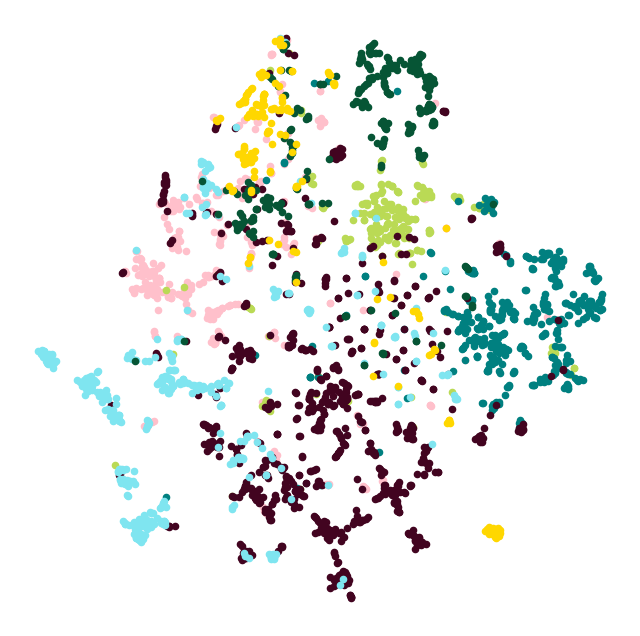

In [1]:
import os.path as osp
import sys

import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

path = "test_data"
dataset = Planetoid(path, name='Cora')
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)


num_workers = 4 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc


for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

"""
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)
"""

In [5]:
train_X.shape, train_graphs.shape, test_X.shape, test_graphs.shape

((2717, 19, 200, 100),
 (2717, 100, 19, 19),
 (276, 19, 200, 100),
 (276, 100, 19, 19))

In [7]:
data.edge_index

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

In [8]:
19*19*276

99636

In [9]:
2717*19*19

980837

In [2]:
from torch_geometric.data import Data
import torch
from torch_geometric.loader import DataLoader

def build_pyg_dl(x, a, y, device):
    """Convert features and adjacency to PyTorch Geometric Dataloader"""
    a = torch.from_numpy(a)
    a[a<0.3] = 0
    a.fill_diagonal_(1)
    edge_index, edge_attr = dense_to_sparse(a)

    edge_index = edge_index.to(device)
    edge_attr = edge_attr.to(device)
    x = torch.from_numpy(x).to(device)
    y = torch.tensor([y], dtype=torch.float).to(device)
    #y = y*x.shape[0]
    data = Data(x=x, edge_index=edge_index, 
                edge_attr=edge_attr, 
                y=y)
    return data

In [3]:
DEVICE = "cpu"
train_graphs = train_graphs[:, 0, :, :]
test_graphs = test_graphs[:, 0, :, :]
train_dataset = [build_pyg_dl(x, g, y, DEVICE) for x, g, y in zip(train_X, train_graphs, train_y)]
#test_dataset = [build_pyg_dl(x, g, y, DEVICE) for x, g, y in zip(test_X, test_graphs, test_y)]
BATCH_SIZE = len(train_dataset)
train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
#test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/var/folders/4k/d3wc_jw93m12xqfn1fcfg_2w0000gr/T/ipykernel_74585/3830467214.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  y = torch.tensor([y], dtype=torch.float).to(device)


In [6]:
import os.path as osp
import sys

import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from torch_geometric.nn import global_mean_pool

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

#path = "test_data"
#dataset = Planetoid(path, name='Cora')
#data = dataset[0]

device = 'cpu'

model = Node2Vec(
    next(iter(train_iter)).edge_index,
    embedding_dim=128,
    walk_length=5,
    context_size=3,
    walks_per_node=5,
    num_negative_samples=5,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)


num_workers = 4 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    data = next(iter(train_iter))
    batch = data.batch
    z = global_mean_pool(z, batch)
    print(z.shape)
    acc = model.test(
        train_z=z,
        train_y=data.y,
        test_z=z,
        test_y=data.y,
        max_iter=150,
    )
    return acc

for epoch in range(0, 100):
    loss = train()
    acc = test()
    print("Epoch", epoch, "Loss", loss, "acc", acc)

torch.Size([2717, 128])
Epoch 0 Loss 7.092021577429064 acc 0.590357011409643


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 1 Loss 4.446312600433236 acc 0.5951417004048583


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 2 Loss 3.5480849211758905 acc 0.5969819654030181


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 3 Loss 2.8630006567086324 acc 0.5936694884063305


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 4 Loss 2.335180969521551 acc 0.5944055944055944


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 5 Loss 1.9418017704888146 acc 0.5962458594037542


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 6 Loss 1.6464766992790865 acc 0.590357011409643


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 7 Loss 1.424071326409236 acc 0.5951417004048583


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 8 Loss 1.257737711514577 acc 0.5929333824070666


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 9 Loss 1.1332773616408358 acc 0.597718071402282


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 10 Loss 1.0408315338415675 acc 0.5984541774015458


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 11 Loss 0.9716871336545094 acc 0.5969819654030181


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 12 Loss 0.9207838223417206 acc 0.59735001840265


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 13 Loss 0.8828492803443776 acc 0.5914611704085388


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 14 Loss 0.8533267418641856 acc 0.5944055944055944


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 15 Loss 0.8306014986321477 acc 0.5958778064041222


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 16 Loss 0.813185052411391 acc 0.5984541774015458


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 17 Loss 0.7993109543429743 acc 0.5929333824070666


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 18 Loss 0.7884466494664107 acc 0.5933014354066986


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 19 Loss 0.7800525325064612 acc 0.5936694884063305


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 20 Loss 0.772773609450548 acc 0.5947736474052263


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 21 Loss 0.7671566496391108 acc 0.5896209054103791


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 22 Loss 0.7623803066735221 acc 0.5859403754140596


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 23 Loss 0.7588565373184657 acc 0.5863084284136916


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 24 Loss 0.7554646363057712 acc 0.5910931174089069


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 25 Loss 0.7533005318134138 acc 0.5866764814133235


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 26 Loss 0.750977376309952 acc 0.5859403754140596


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 27 Loss 0.74954355353176 acc 0.5896209054103791


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 28 Loss 0.7482999197327265 acc 0.5925653294074347


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 29 Loss 0.7472275097181301 acc 0.5914611704085388


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 30 Loss 0.7467125232266908 acc 0.5892528524107471


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 31 Loss 0.745982417080662 acc 0.5859403754140596


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 32 Loss 0.7457339827081945 acc 0.5870445344129555


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 33 Loss 0.7457350803778904 acc 0.590357011409643


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 34 Loss 0.7456935549726581 acc 0.5910931174089069


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 35 Loss 0.7459294586488516 acc 0.5888847994111152


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 36 Loss 0.7463180126235036 acc 0.590725064409275


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 37 Loss 0.746620509884145 acc 0.5874125874125874


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 38 Loss 0.7470668824297366 acc 0.5921972764078027


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 39 Loss 0.7474678726774631 acc 0.590357011409643


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 40 Loss 0.7481617666412108 acc 0.5885167464114832


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 41 Loss 0.7488051546682225 acc 0.5929333824070666


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 42 Loss 0.7494791012884366 acc 0.5969819654030181


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 43 Loss 0.7500882907078998 acc 0.5944055944055944


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 44 Loss 0.7506375280347201 acc 0.5940375414059624


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 45 Loss 0.7512172559405318 acc 0.5955097534044902


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 46 Loss 0.7517851980605929 acc 0.5870445344129555


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 47 Loss 0.7522723819359695 acc 0.5852042694147958


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 48 Loss 0.7529518425759703 acc 0.5863084284136916


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 49 Loss 0.7533010788778267 acc 0.5888847994111152


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 50 Loss 0.7538802989638678 acc 0.5885167464114832


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 51 Loss 0.754614061795839 acc 0.5815237394184762


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 52 Loss 0.7547296161698823 acc 0.5852042694147958


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 53 Loss 0.755409642758936 acc 0.5855723224144277


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [3]:
from typing import List, Optional, Tuple, Union

import torch
from torch import Tensor
from torch.nn import Embedding
from torch.utils.data import DataLoader

from torch_geometric.index import index2ptr
from torch_geometric.typing import WITH_PYG_LIB, WITH_TORCH_CLUSTER
from torch_geometric.utils import sort_edge_index
from torch_geometric.utils.num_nodes import maybe_num_nodes


class Node2Vec(torch.nn.Module):
    r"""The Node2Vec model from the
    `"node2vec: Scalable Feature Learning for Networks"
    <https://arxiv.org/abs/1607.00653>`_ paper where random walks of
    length :obj:`walk_length` are sampled in a given graph, and node embeddings
    are learned via negative sampling optimization.

    .. note::

        For an example of using Node2Vec, see `examples/node2vec.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        node2vec.py>`_.

    Args:
        edge_index (torch.Tensor): The edge indices.
        embedding_dim (int): The size of each embedding vector.
        walk_length (int): The walk length.
        context_size (int): The actual context size which is considered for
            positive samples. This parameter increases the effective sampling
            rate by reusing samples across different source nodes.
        walks_per_node (int, optional): The number of walks to sample for each
            node. (default: :obj:`1`)
        p (float, optional): Likelihood of immediately revisiting a node in the
            walk. (default: :obj:`1`)
        q (float, optional): Control parameter to interpolate between
            breadth-first strategy and depth-first strategy (default: :obj:`1`)
        num_negative_samples (int, optional): The number of negative samples to
            use for each positive sample. (default: :obj:`1`)
        num_nodes (int, optional): The number of nodes. (default: :obj:`None`)
        sparse (bool, optional): If set to :obj:`True`, gradients w.r.t. to the
            weight matrix will be sparse. (default: :obj:`False`)
    """
    def __init__(
        self,
        edge_index: Tensor,
        embedding_dim: int,
        walk_length: int,
        context_size: int,
        walks_per_node: int = 1,
        p: float = 1.0,
        q: float = 1.0,
        num_negative_samples: int = 1,
        num_nodes: Optional[int] = None,
        sparse: bool = False,
    ):
        super().__init__()

        if WITH_PYG_LIB and p == 1.0 and q == 1.0:
            self.random_walk_fn = torch.ops.pyg.random_walk
        elif WITH_TORCH_CLUSTER:
            self.random_walk_fn = torch.ops.torch_cluster.random_walk
        else:
            if p == 1.0 and q == 1.0:
                raise ImportError(f"'{self.__class__.__name__}' "
                                  f"requires either the 'pyg-lib' or "
                                  f"'torch-cluster' package")
            else:
                raise ImportError(f"'{self.__class__.__name__}' "
                                  f"requires the 'torch-cluster' package")

        self.num_nodes = maybe_num_nodes(edge_index, num_nodes)

        row, col = sort_edge_index(edge_index, num_nodes=self.num_nodes).cpu()
        self.rowptr, self.col = index2ptr(row, self.num_nodes), col

        self.EPS = 1e-15
        assert walk_length >= context_size

        self.embedding_dim = embedding_dim
        self.walk_length = walk_length - 1
        self.context_size = context_size
        self.walks_per_node = walks_per_node
        self.p = p
        self.q = q
        self.num_negative_samples = num_negative_samples

        self.embedding = Embedding(self.num_nodes, embedding_dim,
                                   sparse=sparse)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.embedding.reset_parameters()

    def forward(self, batch: Optional[Tensor] = None) -> Tensor:
        """Returns the embeddings for the nodes in :obj:`batch`."""
        emb = self.embedding.weight
        return emb if batch is None else emb[batch]

    def loader(self, **kwargs) -> DataLoader:
        return DataLoader(range(self.num_nodes), collate_fn=self.sample,
                          **kwargs)

    @torch.jit.export
    def pos_sample(self, batch: Tensor) -> Tensor:
        batch = batch.repeat(self.walks_per_node)
        rw = self.random_walk_fn(self.rowptr, self.col, batch,
                                 self.walk_length, self.p, self.q)
        if not isinstance(rw, Tensor):
            rw = rw[0]

        walks = []
        num_walks_per_rw = 1 + self.walk_length + 1 - self.context_size
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + self.context_size])
        return torch.cat(walks, dim=0)

    @torch.jit.export
    def neg_sample(self, batch: Tensor) -> Tensor:
        batch = batch.repeat(self.walks_per_node * self.num_negative_samples)

        rw = torch.randint(self.num_nodes, (batch.size(0), self.walk_length),
                           dtype=batch.dtype, device=batch.device)
        rw = torch.cat([batch.view(-1, 1), rw], dim=-1)

        walks = []
        num_walks_per_rw = 1 + self.walk_length + 1 - self.context_size
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + self.context_size])
        return torch.cat(walks, dim=0)

    @torch.jit.export
    def sample(self, batch: Union[List[int], Tensor]) -> Tuple[Tensor, Tensor]:
        if not isinstance(batch, Tensor):
            batch = torch.tensor(batch)
        return self.pos_sample(batch), self.neg_sample(batch)

    @torch.jit.export
    def loss(self, pos_rw: Tensor, neg_rw: Tensor) -> Tensor:
        r"""Computes the loss given positive and negative random walks."""
        # Positive loss.
        start, rest = pos_rw[:, 0], pos_rw[:, 1:].contiguous()

        h_start = self.embedding(start).view(pos_rw.size(0), 1,
                                             self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(pos_rw.size(0), -1,
                                                    self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1)
        pos_loss = -torch.log(torch.sigmoid(out) + self.EPS).mean()

        # Negative loss.
        start, rest = neg_rw[:, 0], neg_rw[:, 1:].contiguous()

        h_start = self.embedding(start).view(neg_rw.size(0), 1,
                                             self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(neg_rw.size(0), -1,
                                                    self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1)
        neg_loss = -torch.log(1 - torch.sigmoid(out) + self.EPS).mean()

        return pos_loss + neg_loss

    def test(
        self,
        train_z: Tensor,
        train_y: Tensor,
        test_z: Tensor,
        test_y: Tensor,
        solver: str = 'lbfgs',
        *args,
        **kwargs,
    ) -> float:
        r"""Evaluates latent space quality via a logistic regression downstream
        task.
        """
        from sklearn.linear_model import LogisticRegression
        
        
        clf = LogisticRegression(solver=solver, *args,
                                 **kwargs).fit(train_z.detach().cpu().numpy(),
                                               train_y.detach().cpu().numpy())
        return clf.score(test_z.detach().cpu().numpy(),
                         test_y.detach().cpu().numpy())

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.embedding.weight.size(0)}, '
                f'{self.embedding.weight.size(1)})')

torch.Size([2717, 128])
Epoch 0 Loss 8.738882663226363 acc 0.5848362164151638


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 1 Loss 6.917682267651699 acc 0.5848362164151638


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 2 Loss 5.737519422380051 acc 0.583732057416268


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 3 Loss 5.058818203387874 acc 0.5826278984173721


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 4 Loss 4.673042870984219 acc 0.5870445344129555


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 5 Loss 4.405732757974379 acc 0.5888847994111152


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 6 Loss 4.1833011218816925 acc 0.5844681634155319


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 7 Loss 3.97217199648961 acc 0.5852042694147958


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 8 Loss 3.7691991240671365 acc 0.5855723224144277


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 9 Loss 3.5705463844950835 acc 0.5859403754140596


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 10 Loss 3.3748542855281642 acc 0.5888847994111152


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 11 Loss 3.19108120934798 acc 0.5874125874125874


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 12 Loss 3.0091350326443664 acc 0.5874125874125874


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 13 Loss 2.839173326397886 acc 0.5885167464114832


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 14 Loss 2.6796588885902177 acc 0.5892528524107471


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 15 Loss 2.528540054170212 acc 0.5896209054103791


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 16 Loss 2.386043641826894 acc 0.5899889584100111


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 17 Loss 2.2546077411953767 acc 0.590725064409275


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 18 Loss 2.130965450612625 acc 0.5925653294074347


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 19 Loss 2.0155093714152232 acc 0.5925653294074347


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 20 Loss 1.9079210955907804 acc 0.5933014354066986


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 21 Loss 1.8067975224244712 acc 0.5921972764078027


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2717, 128])
Epoch 22 Loss 1.7125185229400597 acc 0.590357011409643


/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [ ]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55']#, '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'

plot_points(colors)

/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [ ]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
import torch.nn as nn
from torch_scatter import scatter_add
from torch_geometric.utils import add_self_loops

class TGCN(torch.nn.Module):
    
    """
    Edited and adopted after pytorch geometric temporal library.
    Ref : https://pytorch-geometric-temporal.readthedocs.io/en/latest/index.html
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
    ):
        super(TGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops

        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_z = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_z = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_reset_gate_parameters_and_layers(self):

        self.conv_r = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_r = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_h = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_h = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_weight, H):
        Z = torch.cat([self.conv_z(X, edge_index, edge_weight), H], axis=1)
        Z = self.linear_z(Z)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_weight, H):
        R = torch.cat([self.conv_r(X, edge_index, edge_weight), H], axis=1)
        R = self.linear_r(R)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_weight, H, R):
        H_tilde = torch.cat([self.conv_h(X, edge_index, edge_weight), H * R], axis=1)
        H_tilde = self.linear_h(H_tilde)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:

        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_weight, H)
        R = self._calculate_reset_gate(X, edge_index, edge_weight, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_weight, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H

    
class A3TGCN(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        periods: int,
        num_nodes: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True
        ):
        
        super(A3TGCN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.periods = periods
        self.num_nodes = num_nodes
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self._setup_layers()

    def _setup_layers(self):
        self._base_tgcn = TGCN(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )
        #device = torch.device('mps')
        device = next(self.parameters()).device
        self.attention = torch.nn.Parameter(torch.empty(self.periods, device=device))
        torch.nn.init.uniform_(self.attention)
        self.Conv2Dblock =  Conv2Dblock(timepoints=100, num_nodes=self.num_nodes, node_features=self.in_channels)
        
    def forward(
        self,
        X: torch.FloatTensor,
        A: torch.FloatTensor,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:

        
        H_accum = 0
        probs = torch.nn.functional.softmax(self.attention, dim=-1)
        X = self.Conv2Dblock(X)
        
        # init HS
        H = None
        for period in range(self.periods):
            Xt = X[:, :, :, period]
            batch_size = Xt.shape[0]
            Xt = Xt.reshape(Xt.shape[0]*Xt.shape[1], Xt.shape[-1])
            At = A[:, :, :, period]
            At = torch.block_diag(*At)
            idx = (At > 0).nonzero().t().contiguous().long().to(X.device)
            row, col = idx
            w = At[row, col].float().to(X.device)           
            H = self._base_tgcn(Xt, idx, w, H)
            H = H.reshape(batch_size, self.num_nodes, self.out_channels)
            H_accum = H_accum + probs[period] * H 
            H = H.reshape(batch_size*self.num_nodes, self.out_channels)
        return H_accum
    
            
class EEGModel(nn.Module):
    def __init__(self, num_nodes, node_features, num_classes, num_windows, device):
        super(EEGModel, self).__init__()
        self.forwardA3TGCN = A3TGCN(in_channels=node_features, out_channels=32, periods=num_windows, num_nodes=num_nodes).to(device)
        self.backwardA3TGCN = A3TGCN(in_channels=node_features, out_channels=32, periods=num_windows, num_nodes=num_nodes).to(device)
        self.num_nodes = num_nodes
        self.BN = nn.BatchNorm1d(self.num_nodes)
        self.num_windows = num_windows
        self.fc2 = nn.Linear(self.num_nodes*64, num_classes)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, X, A):
        X = self.dropout(X)
        HS1 = self.forwardA3TGCN(X, A)
        X_flip = torch.flip(X, dims=[1])
        A_flip = torch.flip(A, dims=[1])
        HS2 = self.backwardA3TGCN(X_flip, A_flip)
        HS = torch.cat((HS1, HS2), -1)
        HS = nn.functional.relu(HS)
        HS = self.BN(HS)
        HS = HS.reshape(HS.shape[0], self.num_nodes*64)
        out = self.fc2(HS)
        out = nn.LogSoftmax(dim=-1)(out)
        return out